In [2]:
from medmnist import PneumoniaMNIST
from medmnist import INFO

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl
from pennylane.qnn import TorchLayer
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json


In [3]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [4]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [5]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [6]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [8]:
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)
train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(batch_size=32, train_fraction=1)

In [9]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_raw_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_raw_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_raw_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_raw_loader)

In [10]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


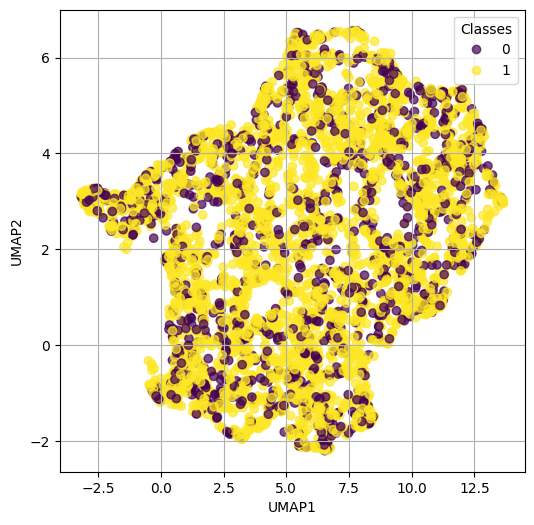

In [11]:
y_train = torch.cat([y for _, y in train_raw_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


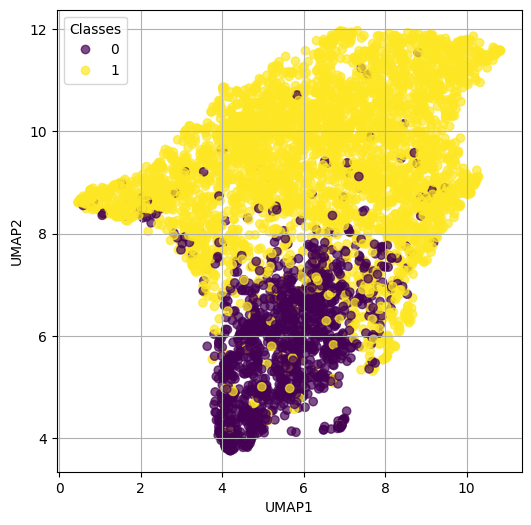

In [12]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_raw_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

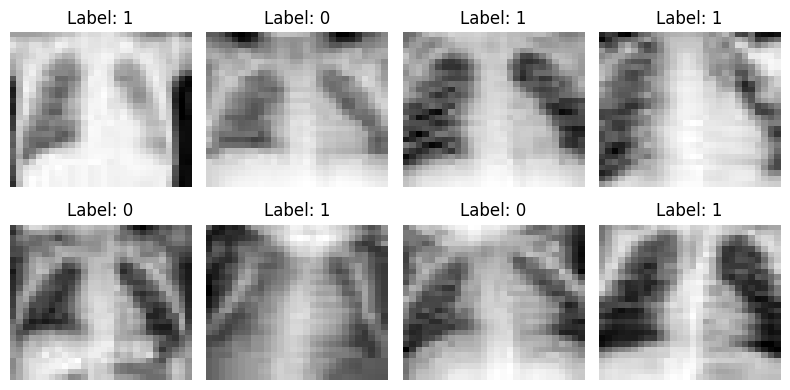

In [13]:
#original images
x_batch, y_batch = sample_batch(train_raw_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_690584/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


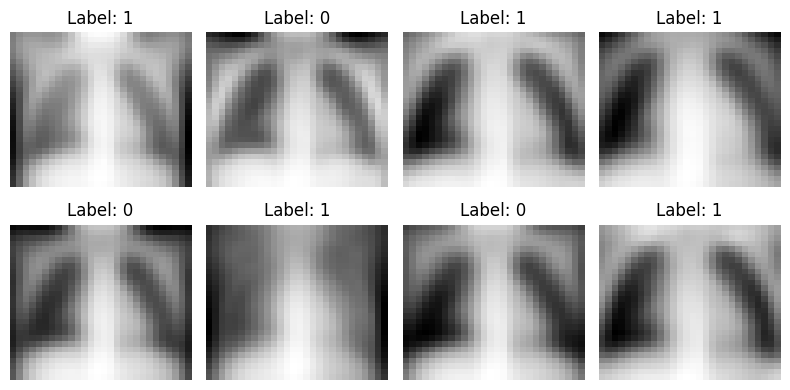

In [14]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

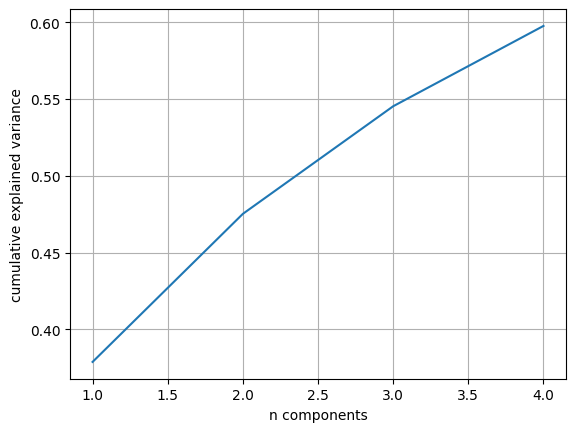

In [15]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

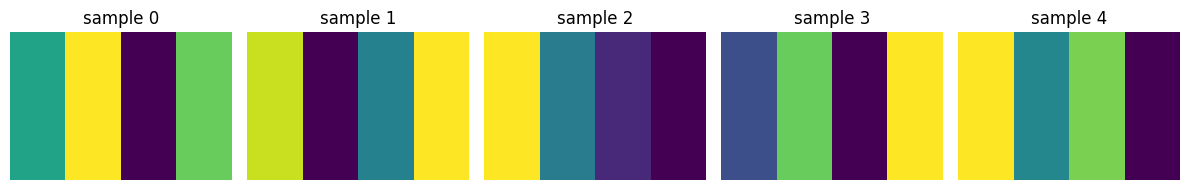

In [16]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [18]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


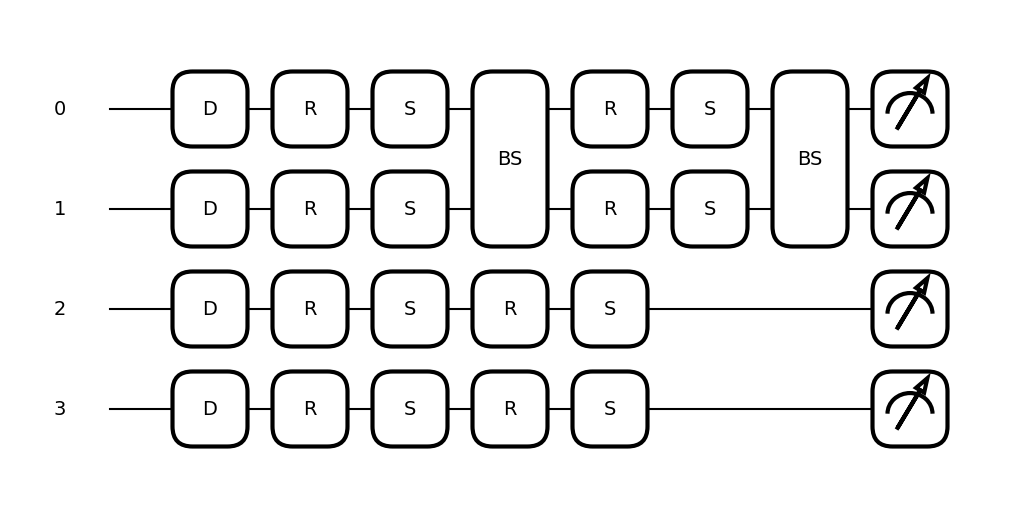

In [19]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [20]:

# scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train_scaled = scaler.fit_transform(x_train_encoded)
# x_val_scaled = scaler.fit_transform(x_val_encoded)
# x_test_scaled = scaler.fit_transform(x_test_encoded)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.transform(x_val_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [21]:
print(x_train_tensor[0])

tensor([ 0.1456,  1.0729, -0.9294,  0.8709])


In [22]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [23]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [24]:
print(output)

tensor([-1.6596, -0.1367,  0.3214,  0.0393], dtype=torch.float64)


In [25]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

    def get_quantum_features(self, x):
        with torch.no_grad():
            return torch.stack([self.quantum(sample) for sample in x])

In [27]:
class QuantumLinear(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)

        self.head = nn.Sequential(
            nn.Linear(n_qumodes, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [28]:
# class ClassicalModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.head = nn.Sequential(
#             nn.Linear(4, 16),
#             nn.ReLU(),
#             nn.Linear(16, 2),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         return self.head(x)

In [29]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 4),
            nn.ReLU(),
            # nn.Linear(16, 2),
            nn.Linear(4, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.head(x)

In [30]:
# def train_v2(model, dataloader, optimizer, loss_fn, device, results_path, model_path):
def train_v2(model, dataloader, optimizer, loss_fn, device):

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    model.train()

    total_loss = 0
    total_samples = 0
    correct = 0
    all_labels = []
    all_preds = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)
        loss.backward()

        # for name, param in model.named_parameters():
        #     print(f"{name:30s} requires_grad={param.requires_grad} | grad={param.grad}")
        # break
        
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}",
        })

        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics

In [31]:
# def train(model, dataloader, optimizer, loss_fn, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     for x_batch, y_batch in progress_bar:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         # print(x_batch.shape)
#         optimizer.zero_grad()
#         logits = model(x_batch)
#         y_batch = y_batch.view(-1).long()
#         # print(logits.shape)
#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x_batch.size(0)
#         pred = logits.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()
#         total_samples += x_batch.size(0)

#         progress_bar.set_postfix({
#             "loss": f"{loss.item():.4f}",
#             "acc": f"{(correct/total_samples):.4f}"
#         })

#     avg_loss = total_loss / total_samples
#     avg_acc = correct / total_samples
#     return avg_loss, avg_acc

In [32]:
def evaluate_v2(model, dataloader, loss_fn, device):
    model.eval()

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    all_probs = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = recall_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics, all_preds, all_probs, all_labels
    

In [33]:
from sklearn.model_selection import StratifiedKFold

def run_kfold_training(model_class, dataset, optimizer, criterion, model_save_name=False, classical=False, k=5, num_epochs=10, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    labels = np.array([label for _, label in dataset])

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n Fold {fold+1}/{k}")

        all_train_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        all_val_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

        if classical:
            # model = ClassicalModel().to(device)
            model = model_class().to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        elif model_save_name:
            # model = model_class(n_qumodes=4, n_classes=2).to(device)
            model = model_class(4, 2).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        else:
            # model = QuantumWrapper().to(device)
            model = model_class(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            

        for epoch in range(num_epochs):
            # train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model_class, train_loader, optimizer, criterion, device)
            train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model, train_loader, optimizer, criterion, device)
            # val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model_class, val_loader, criterion, device)
            val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model, val_loader, criterion, device)



            all_train_metrics["acc"].append(train_acc)
            all_train_metrics["loss"].append(train_loss)
            all_train_metrics["prec"].append(train_prec)
            all_train_metrics["rec"].append(train_rec)
            all_train_metrics["f1"].append(train_f1)

            all_val_metrics["acc"].append(val_acc)
            all_val_metrics["loss"].append(val_loss)
            all_val_metrics["prec"].append(val_prec)
            all_val_metrics["rec"].append(val_rec)
            all_val_metrics["f1"].append(val_f1)

            tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
            tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

        if classical:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            # torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")
            torch.save(model.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")

        else:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_save_name}_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            # torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_best.pth")
            torch.save(model.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_save_name}_fold_{fold+1}_best.pth")

    # return all_train_metrics, all_val_metrics

In [34]:
def plot_metric_with_std(metric_name, train_folds, val_folds, epochs, classical=False, save_name=None):
    
    train_array = np.array(train_folds[metric_name])
    val_array = np.array(val_folds[metric_name])

    train_mean = np.mean(train_array, axis=0)
    train_std = np.std(train_array, axis=0)
    val_mean = np.mean(val_array, axis=0)
    val_std = np.std(val_array, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mean, label="Train", color="blue", marker="o")
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

    plt.plot(epochs, val_mean, label="Validation", color="green", marker="^")
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

    plt.xlabel("Epochs")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_name:

        if classical:
            plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-" + save_name, dpi=300)
        else:
            plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/quantum-" + save_name, dpi=300)
    plt.show()

    return {
        "metric": metric_name,
        "train_name": float(train_mean[-1]),
        "train_std": float(train_std[-1]),
        "val_mean": float(val_mean[-1]),
        "val_std": float(val_std[-1]),
    }

In [35]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     with torch.no_grad():
#         for x_batch, y_batch in progress_bar:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(x_batch)
#             y_batch = y_batch.view(-1).long()
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)
#             pred = outputs.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()
#             total_samples += x_batch.size(0)

#             progress_bar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total_samples):.4f}"
#             })

#         avg_loss = total_loss / total_samples
#         avg_acc = correct / total_samples
#         return avg_loss, avg_acc

In [36]:
# epochs = 10
epochs = 30
device = "cpu"
# cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [37]:
from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumLinear                            --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
│    └─Softmax: 2-2                      --
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [38]:
cv_model.train()
for name, param in cv_model.named_parameters():
    print(f"{name} grad:", param.grad)
    print(f"{name} grad: requires_grad={param.requires_grad}")

quantum.weights grad: None
quantum.weights grad: requires_grad=True
head.0.weight grad: None
head.0.weight grad: requires_grad=True
head.0.bias grad: None
head.0.bias grad: requires_grad=True


In [39]:
quantum_weights = list(cv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[4.242787   2.794745   2.7682662  3.4000487 ]
  [4.94775    1.4620672  2.8943484  4.5028667 ]
  [1.7568316  1.8931605  3.8094969  3.4317307 ]
  [3.5226421  5.3881965  5.7405834  3.3577054 ]]

 [[2.5310473  0.27203965 0.41522533 0.21528874]
  [3.167214   2.3208425  3.3191192  5.845844  ]
  [2.418257   6.188794   0.3293752  4.9353204 ]
  [2.72025    3.7107775  0.504531   3.5777917 ]]]


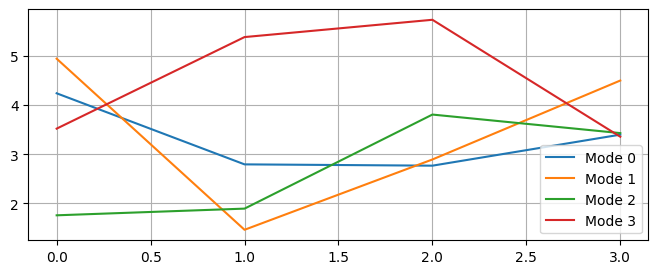

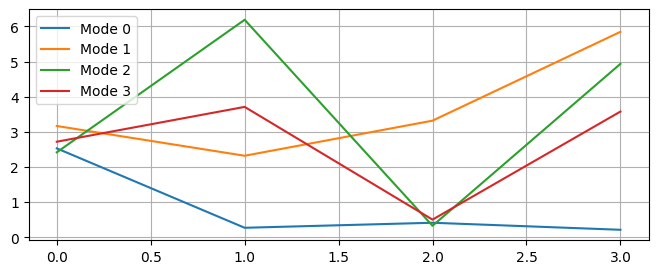

In [40]:
for layer in range(quantum_weights.shape[0]):
    plt.figure(figsize=(8, 3))
    for mode in range(quantum_weights.shape[1]):
        plt.plot(quantum_weights[layer, mode], label=f"Mode {mode}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
model_name = "linear"
# model_name = "chead"

In [41]:
# run_kfold_training(cv_model, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=epochs, seed=42)

# run_kfold_training(QuantumWrapper, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=epochs, seed=42)

run_kfold_training(QuantumLinear, train_dataset, optimizer, criterion, model_name, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|████████| 50/50 [00:05<00:00,  9.51it/s, loss=0.4904, acc=0.8115]


Train loss: 0.4929 | Train acc: 0.8126 | Train rec: 0.8126 | Train prec: 0.8747 | Train f1: 0.8235
Val loss: 0.4904 | Val acc: 0.8115 | Val rec: 0.8115 | Val prec: 0.8724 | Val f1: 0.8115


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4537, acc=0.8707]


Train loss: 0.4593 | Train acc: 0.8528 | Train rec: 0.8528 | Train prec: 0.8856 | Train f1: 0.8596
Val loss: 0.4537 | Val acc: 0.8707 | Val rec: 0.8707 | Val prec: 0.8887 | Val f1: 0.8707


Training: 100%|████████| 50/50 [00:05<00:00,  9.72it/s, loss=0.4471, acc=0.8739]


Train loss: 0.4431 | Train acc: 0.8748 | Train rec: 0.8748 | Train prec: 0.8892 | Train f1: 0.8786
Val loss: 0.4471 | Val acc: 0.8739 | Val rec: 0.8739 | Val prec: 0.8906 | Val f1: 0.8739


Training: 100%|████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.4427, acc=0.8783]


Train loss: 0.4384 | Train acc: 0.8799 | Train rec: 0.8799 | Train prec: 0.8925 | Train f1: 0.8833
Val loss: 0.4427 | Val acc: 0.8783 | Val rec: 0.8783 | Val prec: 0.8913 | Val f1: 0.8783


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4410, acc=0.8783]


Train loss: 0.4351 | Train acc: 0.8821 | Train rec: 0.8821 | Train prec: 0.8907 | Train f1: 0.8847
Val loss: 0.4410 | Val acc: 0.8783 | Val rec: 0.8783 | Val prec: 0.8887 | Val f1: 0.8783


Training: 100%|████████| 50/50 [00:05<00:00,  9.30it/s, loss=0.4365, acc=0.8841]


Train loss: 0.4325 | Train acc: 0.8815 | Train rec: 0.8815 | Train prec: 0.8891 | Train f1: 0.8839
Val loss: 0.4365 | Val acc: 0.8841 | Val rec: 0.8841 | Val prec: 0.8877 | Val f1: 0.8841


Training: 100%|████████| 50/50 [00:05<00:00,  9.11it/s, loss=0.4338, acc=0.8828]


Train loss: 0.4323 | Train acc: 0.8846 | Train rec: 0.8846 | Train prec: 0.8892 | Train f1: 0.8863
Val loss: 0.4338 | Val acc: 0.8828 | Val rec: 0.8828 | Val prec: 0.8917 | Val f1: 0.8828


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.4315, acc=0.8854]


Train loss: 0.4284 | Train acc: 0.8853 | Train rec: 0.8853 | Train prec: 0.8900 | Train f1: 0.8870
Val loss: 0.4315 | Val acc: 0.8854 | Val rec: 0.8854 | Val prec: 0.8928 | Val f1: 0.8854


Training: 100%|████████| 50/50 [00:05<00:00,  9.29it/s, loss=0.4294, acc=0.8911]


Train loss: 0.4276 | Train acc: 0.8859 | Train rec: 0.8859 | Train prec: 0.8901 | Train f1: 0.8874
Val loss: 0.4294 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8955 | Val f1: 0.8911


Training: 100%|████████| 50/50 [00:05<00:00,  9.07it/s, loss=0.4284, acc=0.8917]


Train loss: 0.4263 | Train acc: 0.8853 | Train rec: 0.8853 | Train prec: 0.8893 | Train f1: 0.8868
Val loss: 0.4284 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8960 | Val f1: 0.8917


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.4277, acc=0.8917]


Train loss: 0.4246 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8900 | Train f1: 0.8879
Val loss: 0.4277 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8931 | Val f1: 0.8917


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4249, acc=0.8917]


Train loss: 0.4240 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8910 | Train f1: 0.8899
Val loss: 0.4249 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8942 | Val f1: 0.8917


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.4246, acc=0.8917]


Train loss: 0.4228 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8903 | Train f1: 0.8892
Val loss: 0.4246 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8947 | Val f1: 0.8917


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4230, acc=0.8930]


Train loss: 0.4227 | Train acc: 0.8859 | Train rec: 0.8859 | Train prec: 0.8883 | Train f1: 0.8869
Val loss: 0.4230 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8954 | Val f1: 0.8930


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.4225, acc=0.8930]


Train loss: 0.4221 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8893 | Train f1: 0.8889
Val loss: 0.4225 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8959 | Val f1: 0.8930


Training: 100%|████████| 50/50 [00:05<00:00,  9.53it/s, loss=0.4227, acc=0.8892]


Train loss: 0.4211 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8907 | Train f1: 0.8898
Val loss: 0.4227 | Val acc: 0.8892 | Val rec: 0.8892 | Val prec: 0.8938 | Val f1: 0.8892


Training: 100%|████████| 50/50 [00:05<00:00,  9.73it/s, loss=0.4225, acc=0.8924]


Train loss: 0.4210 | Train acc: 0.8878 | Train rec: 0.8878 | Train prec: 0.8893 | Train f1: 0.8885
Val loss: 0.4225 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8959 | Val f1: 0.8924


Training: 100%|████████| 50/50 [00:05<00:00,  9.62it/s, loss=0.4211, acc=0.8924]


Train loss: 0.4210 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8900 | Train f1: 0.8891
Val loss: 0.4211 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8949 | Val f1: 0.8924


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.4202, acc=0.8936]


Train loss: 0.4204 | Train acc: 0.8897 | Train rec: 0.8897 | Train prec: 0.8914 | Train f1: 0.8905
Val loss: 0.4202 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8921 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4207, acc=0.8936]


Train loss: 0.4203 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8884 | Train f1: 0.8879
Val loss: 0.4207 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8960 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.4205, acc=0.8911]


Train loss: 0.4197 | Train acc: 0.8894 | Train rec: 0.8894 | Train prec: 0.8909 | Train f1: 0.8900
Val loss: 0.4205 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8923 | Val f1: 0.8911


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4189, acc=0.8949]


Train loss: 0.4200 | Train acc: 0.8878 | Train rec: 0.8878 | Train prec: 0.8889 | Train f1: 0.8883
Val loss: 0.4189 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8955 | Val f1: 0.8949


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4193, acc=0.8924]


Train loss: 0.4199 | Train acc: 0.8872 | Train rec: 0.8872 | Train prec: 0.8884 | Train f1: 0.8877
Val loss: 0.4193 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8928 | Val f1: 0.8924


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.4199, acc=0.8930]


Train loss: 0.4194 | Train acc: 0.8862 | Train rec: 0.8862 | Train prec: 0.8874 | Train f1: 0.8867
Val loss: 0.4199 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8954 | Val f1: 0.8930


Training: 100%|████████| 50/50 [00:05<00:00,  9.25it/s, loss=0.4184, acc=0.8930]


Train loss: 0.4190 | Train acc: 0.8881 | Train rec: 0.8881 | Train prec: 0.8894 | Train f1: 0.8887
Val loss: 0.4184 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8937 | Val f1: 0.8930


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4184, acc=0.8930]


Train loss: 0.4196 | Train acc: 0.8881 | Train rec: 0.8881 | Train prec: 0.8882 | Train f1: 0.8882
Val loss: 0.4184 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8943 | Val f1: 0.8930


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4183, acc=0.8949]


Train loss: 0.4187 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8882 | Train f1: 0.8883
Val loss: 0.4183 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8968 | Val f1: 0.8949


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.4184, acc=0.8904]


Train loss: 0.4187 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8889 | Train f1: 0.8881
Val loss: 0.4184 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8899 | Val f1: 0.8904


Training: 100%|████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.4190, acc=0.8911]


Train loss: 0.4187 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8898 | Train f1: 0.8901
Val loss: 0.4190 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8907 | Val f1: 0.8911


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.4172, acc=0.8936]


Train loss: 0.4187 | Train acc: 0.8881 | Train rec: 0.8881 | Train prec: 0.8875 | Train f1: 0.8878
Val loss: 0.4172 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8945 | Val f1: 0.8936

 Fold 2/3


Training: 100%|████████| 50/50 [00:05<00:00,  9.52it/s, loss=0.6721, acc=0.6380]


Train loss: 0.6868 | Train acc: 0.6260 | Train rec: 0.6260 | Train prec: 0.7349 | Train f1: 0.6493
Val loss: 0.6721 | Val acc: 0.6380 | Val rec: 0.6380 | Val prec: 0.7432 | Val f1: 0.6380


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4963, acc=0.8043]


Train loss: 0.5522 | Train acc: 0.7569 | Train rec: 0.7569 | Train prec: 0.8330 | Train f1: 0.7715
Val loss: 0.4963 | Val acc: 0.8043 | Val rec: 0.8043 | Val prec: 0.8648 | Val f1: 0.8043


Training: 100%|████████| 50/50 [00:05<00:00,  9.62it/s, loss=0.4998, acc=0.8043]


Train loss: 0.4772 | Train acc: 0.8273 | Train rec: 0.8273 | Train prec: 0.8796 | Train f1: 0.8368
Val loss: 0.4998 | Val acc: 0.8043 | Val rec: 0.8043 | Val prec: 0.8561 | Val f1: 0.8043


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4583, acc=0.8528]


Train loss: 0.4612 | Train acc: 0.8493 | Train rec: 0.8493 | Train prec: 0.8853 | Train f1: 0.8566
Val loss: 0.4583 | Val acc: 0.8528 | Val rec: 0.8528 | Val prec: 0.8816 | Val f1: 0.8528


Training: 100%|████████| 50/50 [00:05<00:00,  9.19it/s, loss=0.4474, acc=0.8662]


Train loss: 0.4449 | Train acc: 0.8697 | Train rec: 0.8697 | Train prec: 0.8918 | Train f1: 0.8748
Val loss: 0.4474 | Val acc: 0.8662 | Val rec: 0.8662 | Val prec: 0.8825 | Val f1: 0.8662


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.4415, acc=0.8776]


Train loss: 0.4376 | Train acc: 0.8818 | Train rec: 0.8818 | Train prec: 0.8967 | Train f1: 0.8856
Val loss: 0.4415 | Val acc: 0.8776 | Val rec: 0.8776 | Val prec: 0.8861 | Val f1: 0.8776


Training: 100%|████████| 50/50 [00:05<00:00,  9.51it/s, loss=0.4409, acc=0.8732]


Train loss: 0.4333 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8970 | Train f1: 0.8903
Val loss: 0.4409 | Val acc: 0.8732 | Val rec: 0.8732 | Val prec: 0.8837 | Val f1: 0.8732


Training: 100%|████████| 50/50 [00:05<00:00,  9.13it/s, loss=0.4389, acc=0.8789]


Train loss: 0.4305 | Train acc: 0.8863 | Train rec: 0.8863 | Train prec: 0.8953 | Train f1: 0.8889
Val loss: 0.4389 | Val acc: 0.8789 | Val rec: 0.8789 | Val prec: 0.8841 | Val f1: 0.8789


Training: 100%|████████| 50/50 [00:05<00:00,  9.74it/s, loss=0.4345, acc=0.8802]


Train loss: 0.4287 | Train acc: 0.8853 | Train rec: 0.8853 | Train prec: 0.8928 | Train f1: 0.8877
Val loss: 0.4345 | Val acc: 0.8802 | Val rec: 0.8802 | Val prec: 0.8845 | Val f1: 0.8802


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4356, acc=0.8738]


Train loss: 0.4270 | Train acc: 0.8898 | Train rec: 0.8898 | Train prec: 0.8957 | Train f1: 0.8917
Val loss: 0.4356 | Val acc: 0.8738 | Val rec: 0.8738 | Val prec: 0.8804 | Val f1: 0.8738


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4317, acc=0.8808]


Train loss: 0.4238 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8978 | Train f1: 0.8951
Val loss: 0.4317 | Val acc: 0.8808 | Val rec: 0.8808 | Val prec: 0.8844 | Val f1: 0.8808


Training: 100%|████████| 50/50 [00:05<00:00,  9.12it/s, loss=0.4307, acc=0.8846]


Train loss: 0.4235 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8927 | Train f1: 0.8903
Val loss: 0.4307 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8864 | Val f1: 0.8846


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4306, acc=0.8840]


Train loss: 0.4217 | Train acc: 0.8952 | Train rec: 0.8952 | Train prec: 0.8970 | Train f1: 0.8959
Val loss: 0.4306 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8861 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.4294, acc=0.8853]


Train loss: 0.4208 | Train acc: 0.8926 | Train rec: 0.8926 | Train prec: 0.8967 | Train f1: 0.8941
Val loss: 0.4294 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8867 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.62it/s, loss=0.4299, acc=0.8821]


Train loss: 0.4192 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8975 | Train f1: 0.8963
Val loss: 0.4299 | Val acc: 0.8821 | Val rec: 0.8821 | Val prec: 0.8830 | Val f1: 0.8821


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4302, acc=0.8802]


Train loss: 0.4200 | Train acc: 0.8930 | Train rec: 0.8930 | Train prec: 0.8951 | Train f1: 0.8938
Val loss: 0.4302 | Val acc: 0.8802 | Val rec: 0.8802 | Val prec: 0.8821 | Val f1: 0.8802


Training: 100%|████████| 50/50 [00:05<00:00,  9.12it/s, loss=0.4278, acc=0.8878]


Train loss: 0.4187 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8941 | Train f1: 0.8929
Val loss: 0.4278 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8884 | Val f1: 0.8878


Training: 100%|████████| 50/50 [00:05<00:00,  9.62it/s, loss=0.4272, acc=0.8853]


Train loss: 0.4178 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8949 | Train f1: 0.8940
Val loss: 0.4272 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8855 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.4275, acc=0.8853]


Train loss: 0.4180 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8965 | Train f1: 0.8953
Val loss: 0.4275 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8857 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4274, acc=0.8840]


Train loss: 0.4165 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8952 | Train f1: 0.8945
Val loss: 0.4274 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8850 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4264, acc=0.8827]


Train loss: 0.4168 | Train acc: 0.8917 | Train rec: 0.8917 | Train prec: 0.8936 | Train f1: 0.8925
Val loss: 0.4264 | Val acc: 0.8827 | Val rec: 0.8827 | Val prec: 0.8829 | Val f1: 0.8827


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.4261, acc=0.8840]


Train loss: 0.4162 | Train acc: 0.8926 | Train rec: 0.8926 | Train prec: 0.8938 | Train f1: 0.8932
Val loss: 0.4261 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8844 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.4259, acc=0.8840]


Train loss: 0.4158 | Train acc: 0.8930 | Train rec: 0.8930 | Train prec: 0.8935 | Train f1: 0.8932
Val loss: 0.4259 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8836 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.4258, acc=0.8840]


Train loss: 0.4159 | Train acc: 0.8949 | Train rec: 0.8949 | Train prec: 0.8959 | Train f1: 0.8953
Val loss: 0.4258 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8838 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.71it/s, loss=0.4259, acc=0.8840]


Train loss: 0.4150 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8943 | Train f1: 0.8943
Val loss: 0.4259 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8836 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.4259, acc=0.8853]


Train loss: 0.4147 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8933 | Train f1: 0.8926
Val loss: 0.4259 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8855 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.77it/s, loss=0.4255, acc=0.8834]


Train loss: 0.4142 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8953 | Train f1: 0.8954
Val loss: 0.4255 | Val acc: 0.8834 | Val rec: 0.8834 | Val prec: 0.8831 | Val f1: 0.8834


Training: 100%|████████| 50/50 [00:05<00:00,  9.18it/s, loss=0.4251, acc=0.8834]


Train loss: 0.4147 | Train acc: 0.8923 | Train rec: 0.8923 | Train prec: 0.8931 | Train f1: 0.8927
Val loss: 0.4251 | Val acc: 0.8834 | Val rec: 0.8834 | Val prec: 0.8827 | Val f1: 0.8834


Training: 100%|████████| 50/50 [00:05<00:00,  9.20it/s, loss=0.4255, acc=0.8827]


Train loss: 0.4146 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8947 | Train f1: 0.8944
Val loss: 0.4255 | Val acc: 0.8827 | Val rec: 0.8827 | Val prec: 0.8824 | Val f1: 0.8827


Training: 100%|████████| 50/50 [00:05<00:00,  9.15it/s, loss=0.4250, acc=0.8846]


Train loss: 0.4146 | Train acc: 0.8952 | Train rec: 0.8952 | Train prec: 0.8951 | Train f1: 0.8952
Val loss: 0.4250 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8842 | Val f1: 0.8846

 Fold 3/3


Training: 100%|████████| 50/50 [00:05<00:00,  9.17it/s, loss=0.9254, acc=0.3881]


Train loss: 0.9310 | Train acc: 0.3820 | Train rec: 0.3820 | Train prec: 0.5031 | Train f1: 0.4202
Val loss: 0.9254 | Val acc: 0.3881 | Val rec: 0.3881 | Val prec: 0.5173 | Val f1: 0.3881


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.5781, acc=0.7253]


Train loss: 0.8985 | Train acc: 0.4113 | Train rec: 0.4113 | Train prec: 0.5317 | Train f1: 0.4478
Val loss: 0.5781 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.8148 | Val f1: 0.7253


Training: 100%|████████| 50/50 [00:05<00:00,  9.27it/s, loss=0.4629, acc=0.8636]


Train loss: 0.5152 | Train acc: 0.7878 | Train rec: 0.7878 | Train prec: 0.8576 | Train f1: 0.8004
Val loss: 0.4629 | Val acc: 0.8636 | Val rec: 0.8636 | Val prec: 0.8957 | Val f1: 0.8636


Training: 100%|████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.4569, acc=0.8693]


Train loss: 0.4748 | Train acc: 0.8436 | Train rec: 0.8436 | Train prec: 0.8765 | Train f1: 0.8508
Val loss: 0.4569 | Val acc: 0.8693 | Val rec: 0.8693 | Val prec: 0.8945 | Val f1: 0.8693


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4394, acc=0.8840]


Train loss: 0.4587 | Train acc: 0.8595 | Train rec: 0.8595 | Train prec: 0.8810 | Train f1: 0.8648
Val loss: 0.4394 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8977 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.4346, acc=0.8846]


Train loss: 0.4514 | Train acc: 0.8729 | Train rec: 0.8729 | Train prec: 0.8877 | Train f1: 0.8769
Val loss: 0.4346 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8958 | Val f1: 0.8846


Training: 100%|████████| 50/50 [00:05<00:00,  9.53it/s, loss=0.4327, acc=0.8846]


Train loss: 0.4478 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8866 | Train f1: 0.8787
Val loss: 0.4327 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8923 | Val f1: 0.8846


Training: 100%|████████| 50/50 [00:05<00:00,  9.11it/s, loss=0.4290, acc=0.8853]


Train loss: 0.4434 | Train acc: 0.8770 | Train rec: 0.8770 | Train prec: 0.8857 | Train f1: 0.8798
Val loss: 0.4290 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8937 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4269, acc=0.8853]


Train loss: 0.4414 | Train acc: 0.8773 | Train rec: 0.8773 | Train prec: 0.8859 | Train f1: 0.8801
Val loss: 0.4269 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8921 | Val f1: 0.8853


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.4250, acc=0.8866]


Train loss: 0.4387 | Train acc: 0.8815 | Train rec: 0.8815 | Train prec: 0.8877 | Train f1: 0.8836
Val loss: 0.4250 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8933 | Val f1: 0.8866


Training: 100%|████████| 50/50 [00:05<00:00,  9.16it/s, loss=0.4294, acc=0.8846]


Train loss: 0.4372 | Train acc: 0.8773 | Train rec: 0.8773 | Train prec: 0.8831 | Train f1: 0.8794
Val loss: 0.4294 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8898 | Val f1: 0.8846


Training: 100%|████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.4236, acc=0.8840]


Train loss: 0.4384 | Train acc: 0.8796 | Train rec: 0.8796 | Train prec: 0.8842 | Train f1: 0.8813
Val loss: 0.4236 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8918 | Val f1: 0.8840


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.4211, acc=0.8866]


Train loss: 0.4342 | Train acc: 0.8840 | Train rec: 0.8840 | Train prec: 0.8881 | Train f1: 0.8856
Val loss: 0.4211 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8918 | Val f1: 0.8866


Training: 100%|████████| 50/50 [00:05<00:00,  9.62it/s, loss=0.4205, acc=0.8910]


Train loss: 0.4323 | Train acc: 0.8837 | Train rec: 0.8837 | Train prec: 0.8873 | Train f1: 0.8851
Val loss: 0.4205 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8921 | Val f1: 0.8910


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.4187, acc=0.8936]


Train loss: 0.4308 | Train acc: 0.8844 | Train rec: 0.8844 | Train prec: 0.8864 | Train f1: 0.8852
Val loss: 0.4187 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8940 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.17it/s, loss=0.4160, acc=0.8923]


Train loss: 0.4286 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8883 | Train f1: 0.8873
Val loss: 0.4160 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8937 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.03it/s, loss=0.4155, acc=0.8936]


Train loss: 0.4298 | Train acc: 0.8856 | Train rec: 0.8856 | Train prec: 0.8867 | Train f1: 0.8861
Val loss: 0.4155 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8950 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.15it/s, loss=0.4150, acc=0.8936]


Train loss: 0.4263 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8897 | Train f1: 0.8894
Val loss: 0.4150 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8952 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.4148, acc=0.8936]


Train loss: 0.4257 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8899 | Train f1: 0.8897
Val loss: 0.4148 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8942 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.70it/s, loss=0.4144, acc=0.8942]


Train loss: 0.4248 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8873 | Train f1: 0.8869
Val loss: 0.4144 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8942 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.20it/s, loss=0.4133, acc=0.8929]


Train loss: 0.4248 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8877 | Train f1: 0.8876
Val loss: 0.4133 | Val acc: 0.8929 | Val rec: 0.8929 | Val prec: 0.8947 | Val f1: 0.8929


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.4134, acc=0.8936]


Train loss: 0.4240 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8880 | Train f1: 0.8880
Val loss: 0.4134 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8961 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.15it/s, loss=0.4127, acc=0.8955]


Train loss: 0.4246 | Train acc: 0.8856 | Train rec: 0.8856 | Train prec: 0.8860 | Train f1: 0.8858
Val loss: 0.4127 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8962 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.4158, acc=0.8955]


Train loss: 0.4233 | Train acc: 0.8907 | Train rec: 0.8907 | Train prec: 0.8909 | Train f1: 0.8908
Val loss: 0.4158 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8956 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4125, acc=0.8942]


Train loss: 0.4231 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8887 | Train f1: 0.8888
Val loss: 0.4125 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8947 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.4128, acc=0.8936]


Train loss: 0.4235 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8860 | Train f1: 0.8863
Val loss: 0.4128 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8924 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.4136, acc=0.8936]


Train loss: 0.4230 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8886 | Train f1: 0.8882
Val loss: 0.4136 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8926 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.24it/s, loss=0.4116, acc=0.8923]


Train loss: 0.4224 | Train acc: 0.8856 | Train rec: 0.8856 | Train prec: 0.8841 | Train f1: 0.8847
Val loss: 0.4116 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8917 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.68it/s, loss=0.4112, acc=0.8929]


Train loss: 0.4223 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8899 | Train f1: 0.8897
Val loss: 0.4112 | Val acc: 0.8929 | Val rec: 0.8929 | Val prec: 0.8933 | Val f1: 0.8929


Training: 100%|████████| 50/50 [00:05<00:00,  9.18it/s, loss=0.4114, acc=0.8948]

Train loss: 0.4216 | Train acc: 0.8869 | Train rec: 0.8869 | Train prec: 0.8862 | Train f1: 0.8865
Val loss: 0.4114 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8946 | Val f1: 0.8948


In [42]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}



for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

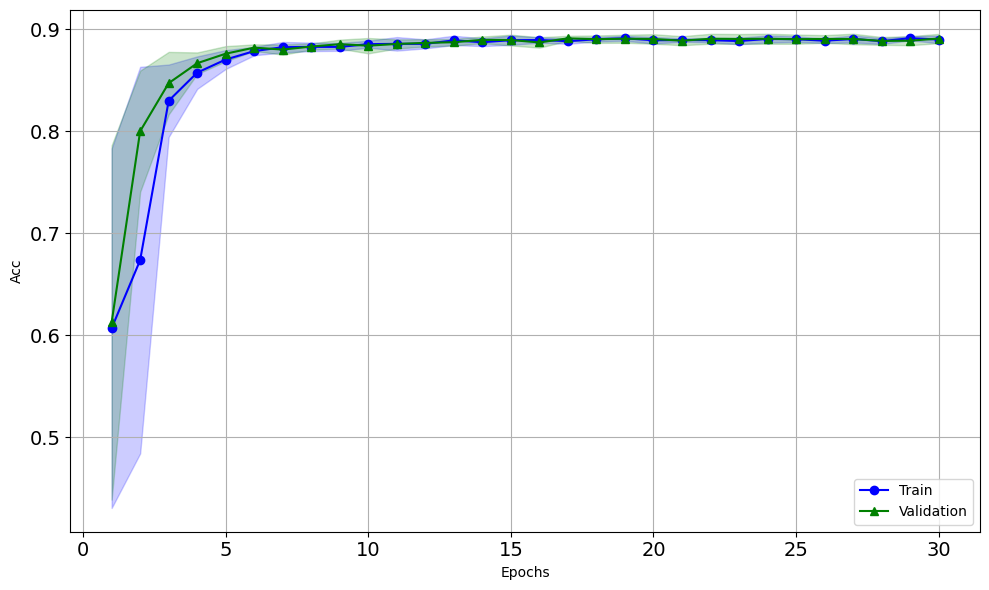

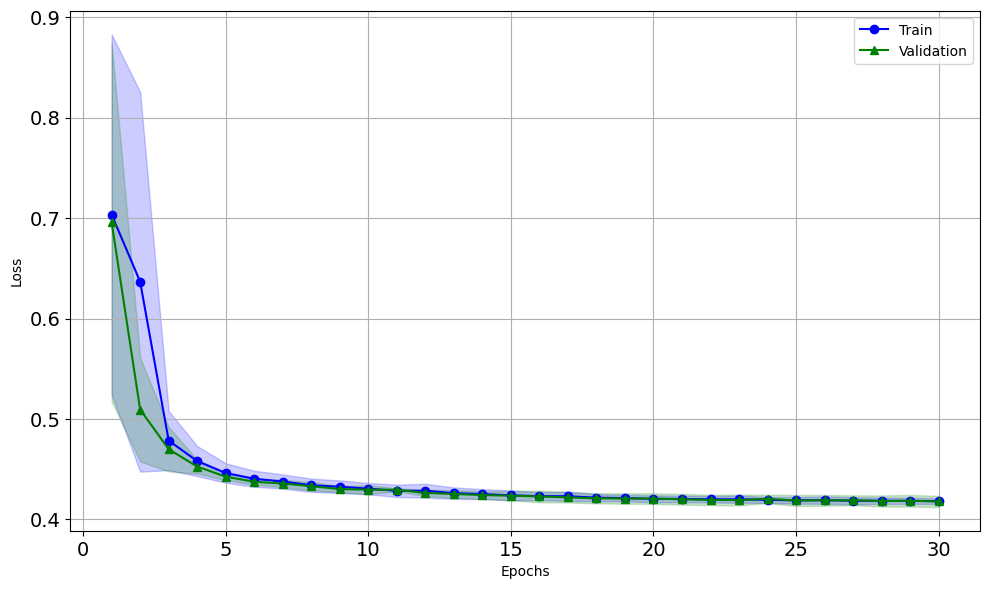

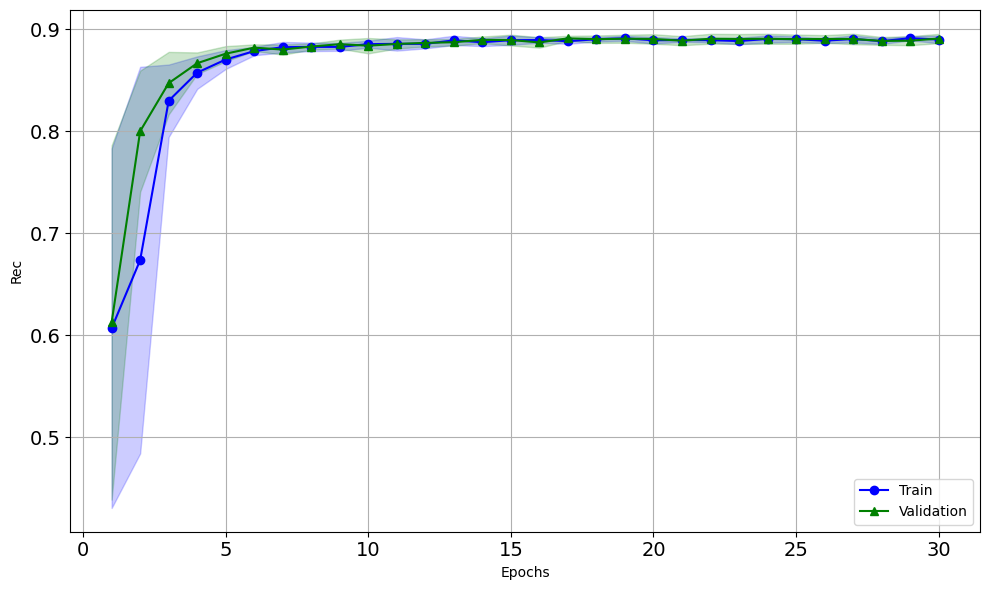

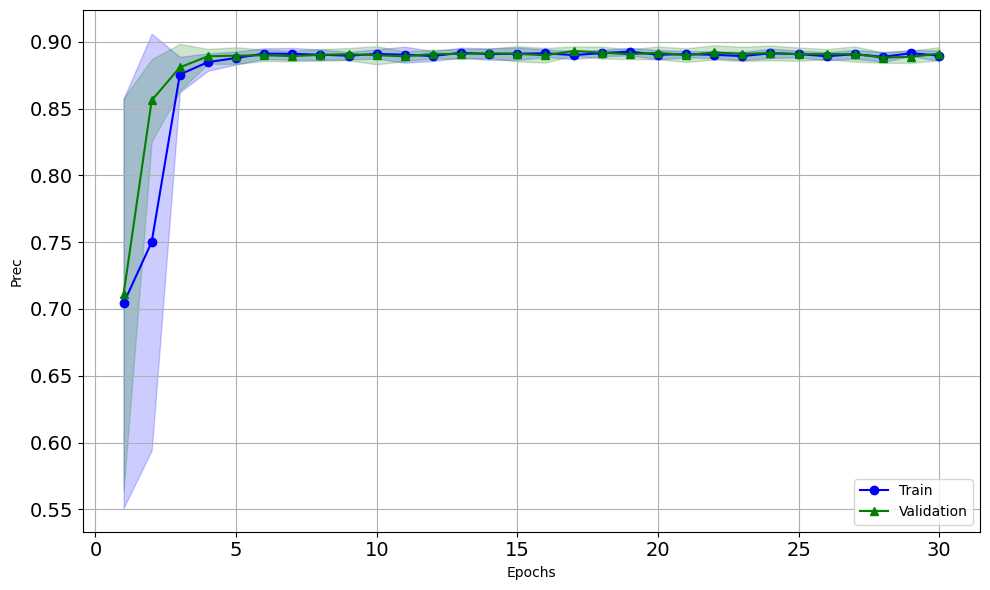

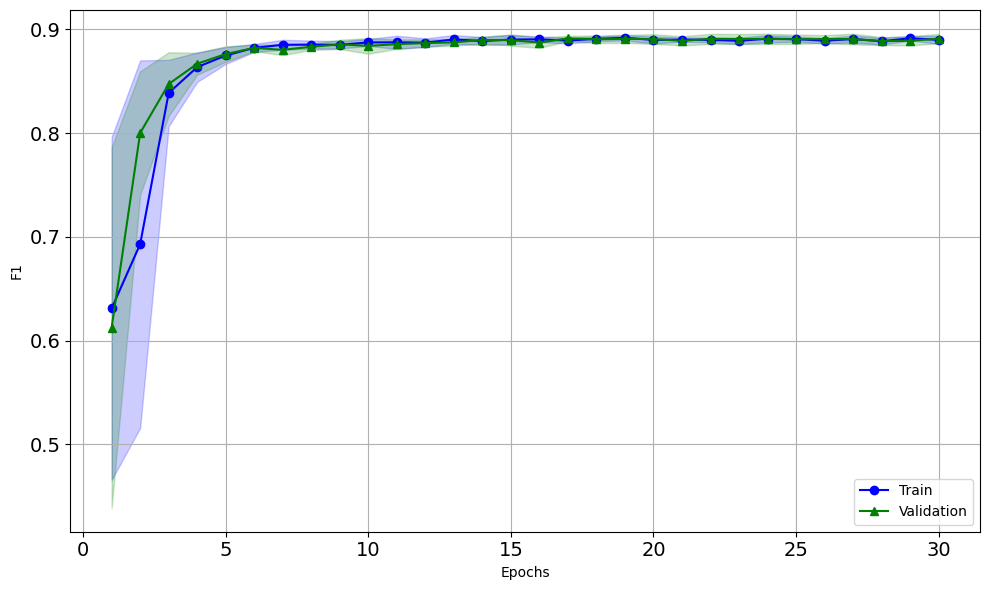

In [43]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/cv_{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [44]:
# train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     train_loss, train_acc, train_prec, train_rec, train_f1, train_report = train_v2(cv_model, train_loader, optimizer, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, val_report, val_preds, val_probs, val_labels = evaluate_v2(cv_model, val_loader, criterion, device)

#     train_metrics["acc"].append(train_acc)
#     train_metrics["loss"].append(train_loss)
#     train_metrics["rec"].append(train_rec)
#     train_metrics["prec"].append(train_prec)
#     train_metrics["f1"].append(train_f1)
    
#     val_metrics["acc"].append(val_acc)
#     val_metrics["loss"].append(val_loss)
#     val_metrics["rec"].append(val_rec)
#     val_metrics["prec"].append(val_prec)
#     val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(cv_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth")
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

# import json
# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_train_metrics.json", "w") as f:
#     json.dump(train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_val_metrics.json", "w") as f:
#     json.dump(val_metrics, f, indent=4)

In [45]:
# epochs = range(1, len(train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [46]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.8948


In [171]:
device = "cpu"
# test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{best_fold}_best.pth"))
test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/cv_{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████| 20/20 [00:01<00:00, 10.79it/s, loss=0.4611, acc=0.8429]

Test loss: 0.4611 | Test acc: 0.8429 | Test rec: 0.8429 | Test prec: 0.8433 | Test f1: 0.8429


In [172]:
for name, param in test_cv_model.quantum.named_parameters():
    print(name, param.data)

weights tensor([[[ 2.4893,  3.9480,  3.4225,  1.2793],
         [ 3.6253,  2.7028,  0.7237,  4.2782],
         [ 4.0887,  2.8591,  0.2867,  2.9777],
         [-0.3392,  3.8538,  5.2053,  6.1579]],

        [[ 5.1869,  4.6683,  3.1920,  4.4442],
         [ 0.3242,  2.4250,  0.0245,  5.4812],
         [ 1.5732,  2.9795,  1.5242,  5.2115],
         [ 3.6271,  2.7267,  1.6596,  4.6878]]])


In [173]:
quantum_weights = list(test_cv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[ 2.4893427   3.948044    3.42253     1.2792612 ]
  [ 3.6252806   2.702754    0.72365284  4.2781963 ]
  [ 4.0886536   2.8590753   0.2866945   2.9777007 ]
  [-0.33921883  3.8538132   5.2053204   6.157867  ]]

 [[ 5.186942    4.6682777   3.1919923   4.4442053 ]
  [ 0.32417852  2.4249759   0.02452534  5.4812317 ]
  [ 1.573187    2.9794948   1.5241549   5.2115493 ]
  [ 3.6271465   2.7267423   1.6596003   4.6878304 ]]]


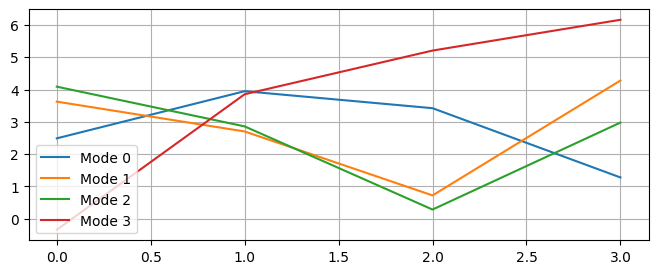

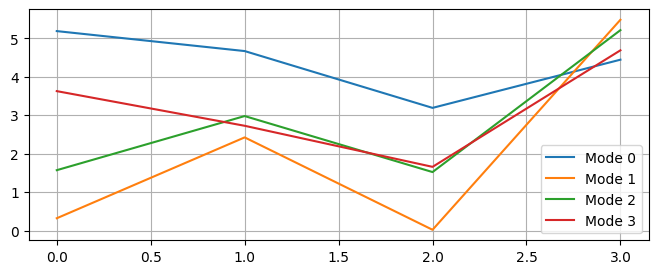

In [174]:
for layer in range(quantum_weights.shape[0]):
    plt.figure(figsize=(8, 3))
    for mode in range(quantum_weights.shape[1]):
        plt.plot(quantum_weights[layer, mode], label=f"Mode {mode}")
    plt.legend()
    plt.grid(True)
    plt.show()

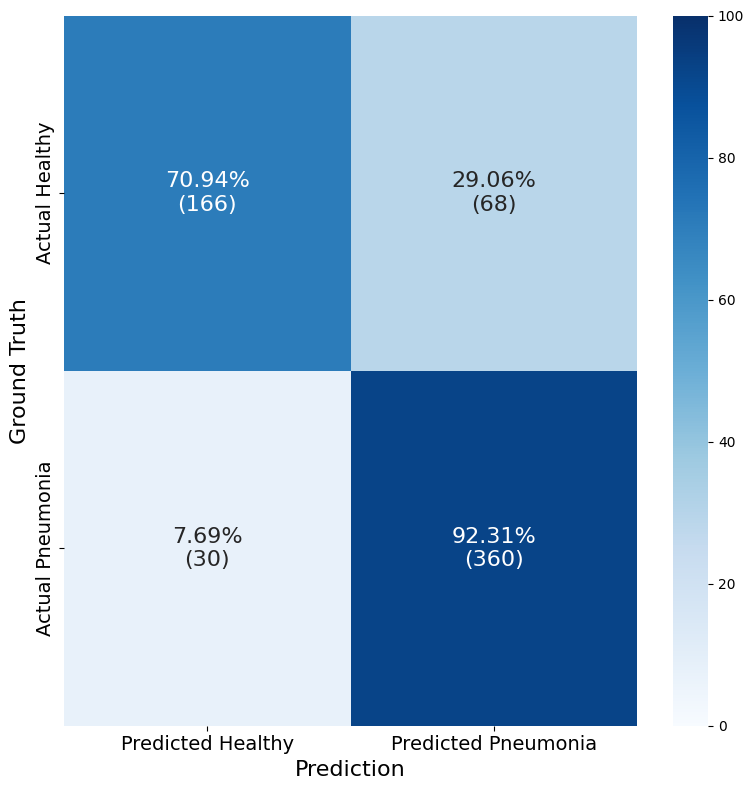

In [175]:
cm = confusion_matrix(test_labels, test_preds)

#normalize by row (for recall percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#normalize by entire sum of dataset
# cm_normalized = cm.astype('float') / cm.sum()

labels = ["Healthy", "Pneumonia"]

annot = np.empty_like(cm).astype(str)
n_classes = cm.shape[0]

for i in range(n_classes):
    for j in range(n_classes):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{percent:.2f}%\n({count})"

plt.figure(figsize=(8, 8))

sns.heatmap(cm_normalized, annot=annot, fmt="", cmap="Blues",
            vmin=0, vmax=100,
            xticklabels=[f"Predicted {lbl}" for lbl in labels],
            yticklabels=[f"Actual {lbl}" for lbl in labels],
           annot_kws={"size":16}
           )

plt.ylabel("Ground Truth", fontsize=16)
plt.xlabel("Prediction", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cm", dpi=300)
plt.show()

AUROC: 0.9132916940609248


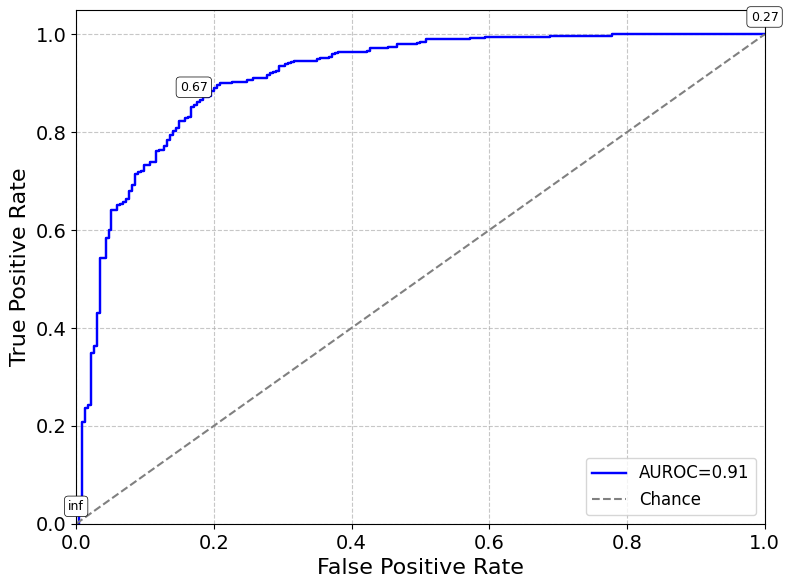

In [176]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

fpr, tpr, thresholds = roc_curve(all_labels_np, all_probs_np[:,1])
roc_auc = auc(fpr, tpr)

print("AUROC:", roc_auc)

fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(fpr, tpr, color="blue", lw=1.75, label=f"AUROC={roc_auc:.2f}")
ax.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance", lw=1.5)


for i in [0, len(thresholds) //2, len(thresholds)-1]:
    ax.annotate(f"{thresholds[i]:.2f}",
                (fpr[i], tpr[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha="center",
                fontsize=9,
                color="black",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
               )


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(loc="lower right", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()


plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cv-auroc", dpi=300)
plt.show()
            

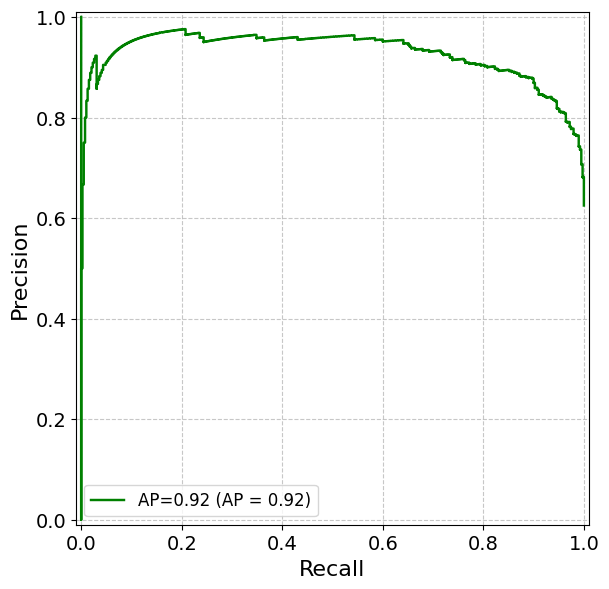

In [177]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=pr_auc
)

disp.plot(ax=ax, lw=1.75, color="green", name=f"AP={pr_auc:.2f}")

ax.set_xlabel("Recall", fontsize=16)
ax.set_ylabel("Precision", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(loc="lower left", fontsize=12)

plt.tight_layout()

plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-precision_recall_curve", dpi=300)
plt.show()

In [178]:
# def gradcam_quantum(model, input_tensor, class_idx=None):
#     model.eval()

#     input_tensor.requires_grad = True

#     quantum_features = torch.stack([model.quantum(sample) for sample in input_tensor])
#     quantum_features.retain_grad()

#     outputs = model.head(quantum_features)

#     if class_idx is None:
#         class_idx = outputs.argmax(dim=1)

#     scores = outputs[:, class_idx] if len(class_idx.shape) == 1 else outputs[0, class_idx]
#     scores.sum().backward()

#     gradients = quantum_features.grad
#     activations = quantum_features

#     weights = gradients.mean(dim=1, keepdim=True)
#     cam = weights * activations
#     # cam = cam.sum(dim=1)

#     return cam.detach().cpu(), outputs.detach().cpu(), class_idx.detach().cpu()

In [179]:
def gradcam_model(model, input_tensor, quantum=False, class_idx=None):
    model.eval()

    input_tensor.requires_grad = True

    if quantum:

        quantum_features = torch.stack([model.quantum(sample) for sample in input_tensor])
        quantum_features.retain_grad()
    
        outputs = model.head(quantum_features)
    
        if class_idx is None:
            class_idx = outputs.argmax(dim=1)
    
        scores = outputs[:, class_idx] if len(class_idx.shape) == 1 else outputs[0, class_idx]
        scores.sum().backward()
    
        gradients = quantum_features.grad
        activations = quantum_features

    else:
        activations = []
        gradients = []
        def forward_hook(module, input, output):
            activations.append(output.detach())

        def backward_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0].detach())

        target_layer = model.head[0]
        handle_fwd = target_layer.register_forward_hook(forward_hook)
        handle_bwd = target_layer.register_full_backward_hook(backward_hook)

        outputs = model(input_tensor)

        if class_idx is None:
            class_idx = outputs.argmax(dim=1)

        scores = outputs[range(len(outputs)), class_idx]
        scores.sum().backward()

        handle_fwd.remove()
        handle_bwd.remove()

        gradients = activations[0]
        activations = gradients[0]

    weights = gradients.mean(dim=1, keepdim=True)
    cam = weights * activations
    # cam = cam.sum(dim=1)

    return cam.detach().cpu(), outputs.detach().cpu(), class_idx.detach().cpu()

In [180]:
def plot_cam(cam, label="CAM Heatmap"):
    for i in range(cam.size(0)):
        plt.figure(figsize=(8,6))
        plt.bar(range(cam.size(1)), cam[i])
        plt.title(f"{label} - sample {i}")
        plt.xlabel("Qumode Index")
        plt.ylabel("Importance")
        plt.show()

In [181]:
# samples = x_test_tensor[0:8].to(device)
samples = x_test_tensor[0:16].to(device)
y_sample_labels = y_test_tensor[0:16].to(device)
print(samples.shape)

torch.Size([16, 4])


In [182]:
# cam, outputs, predictions = gradcam_quantum(test_cv_model, samples)
cam, outputs, predictions = gradcam_model(test_cv_model, samples, quantum=True)
print(cam.shape)


torch.Size([16, 4])


In [183]:
print(cam)

tensor([[-3.1697e-02, -5.8152e-01, -2.3973e-03,  5.2933e-03],
        [-3.1010e-03,  6.2920e-02,  2.2665e-03,  1.8452e-04],
        [ 2.6016e+00,  1.9970e+01,  6.0175e-01, -2.6067e-01],
        [ 3.9210e-03, -9.4450e-03, -5.8912e-04, -5.1107e-05],
        [-4.2590e-03,  1.3626e-02, -6.8998e-04,  3.6992e-04],
        [-3.4635e-03,  2.8163e-02,  1.0907e-04,  3.5320e-05],
        [-2.8936e-02,  1.3374e+00, -1.5970e-02,  2.8639e-03],
        [-3.0631e-03,  1.3149e-01, -2.7538e-04,  6.4815e-05],
        [-4.6517e-03, -2.2621e-02,  7.8643e-04, -4.8917e-05],
        [ 7.6178e-02, -2.0220e-01,  1.4156e-01, -1.7683e-02],
        [-9.9179e-03, -9.3248e-02, -1.4158e-03,  9.9922e-04],
        [-4.0920e-02, -4.9892e-01, -5.9521e-03,  4.9836e-03],
        [ 9.4869e-03,  1.2942e+00,  1.0549e-02,  2.5125e-03],
        [-4.4461e-03,  3.1412e-02, -7.5841e-04,  5.7272e-05],
        [ 1.4034e-01, -7.6753e+01, -2.0749e-02, -8.1067e-01],
        [-1.8159e-02,  2.0281e+00,  7.3480e-03, -1.5907e-02]])


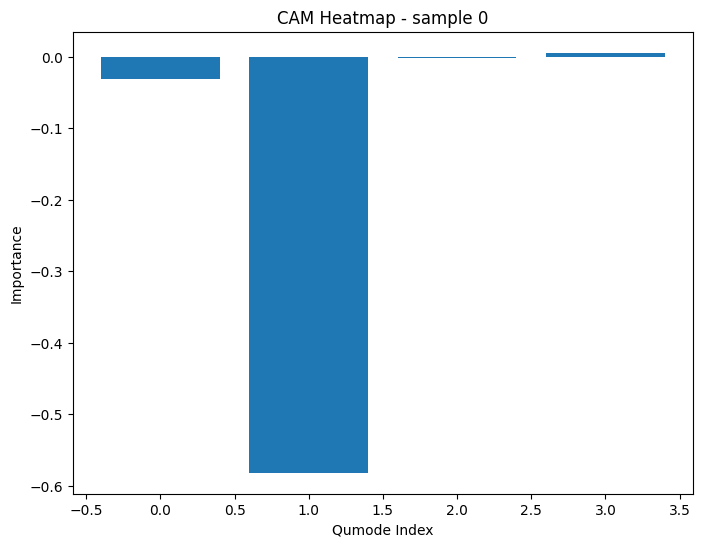

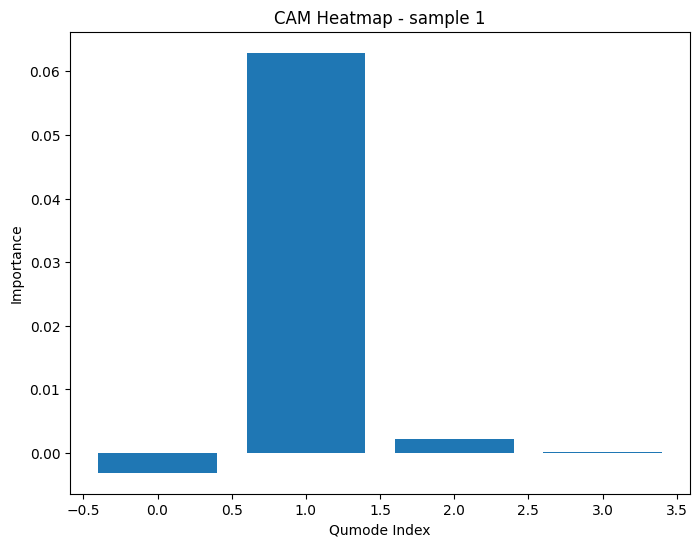

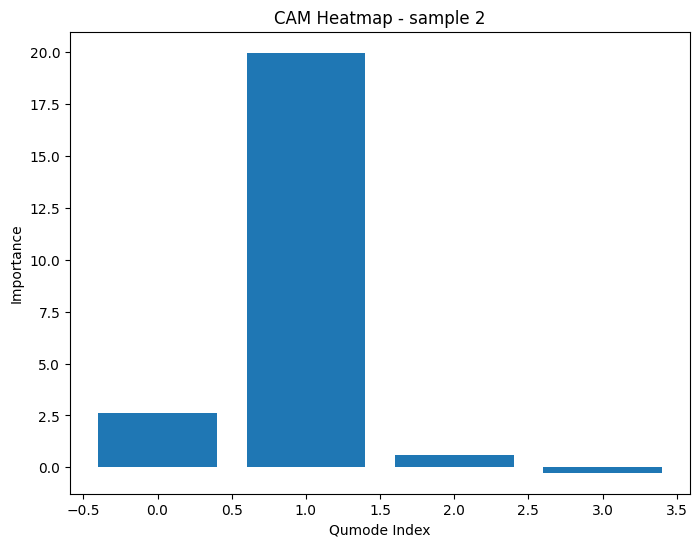

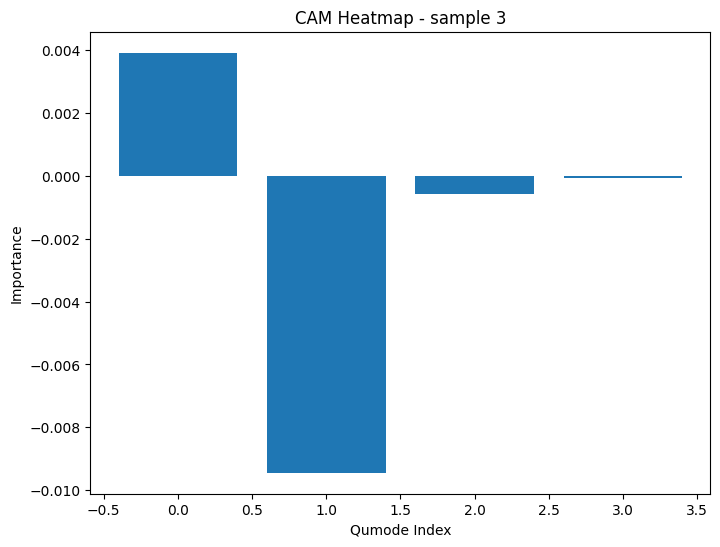

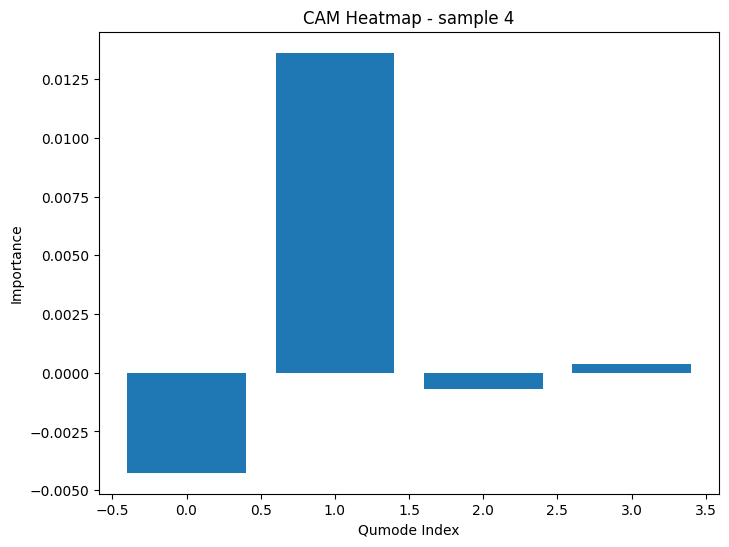

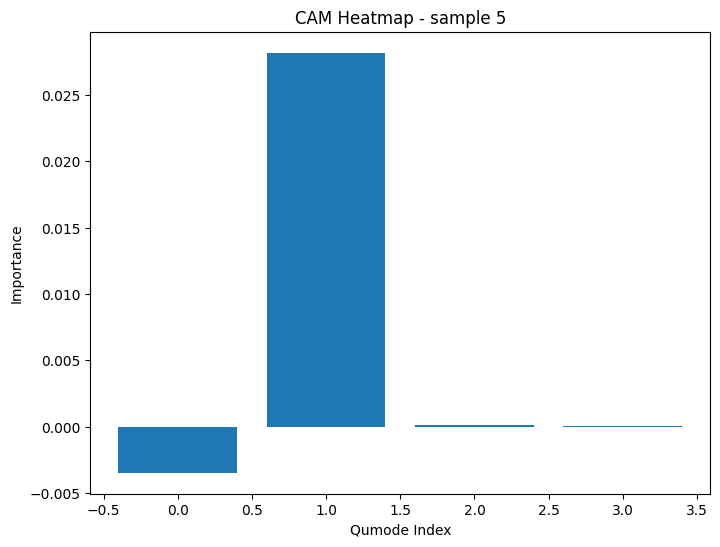

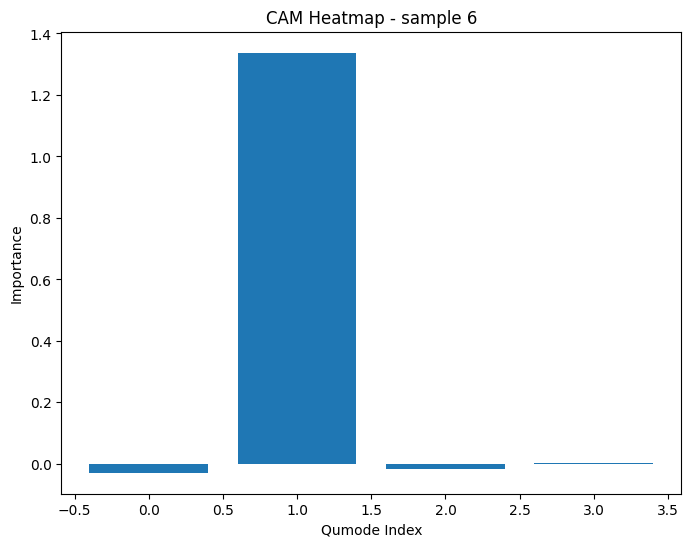

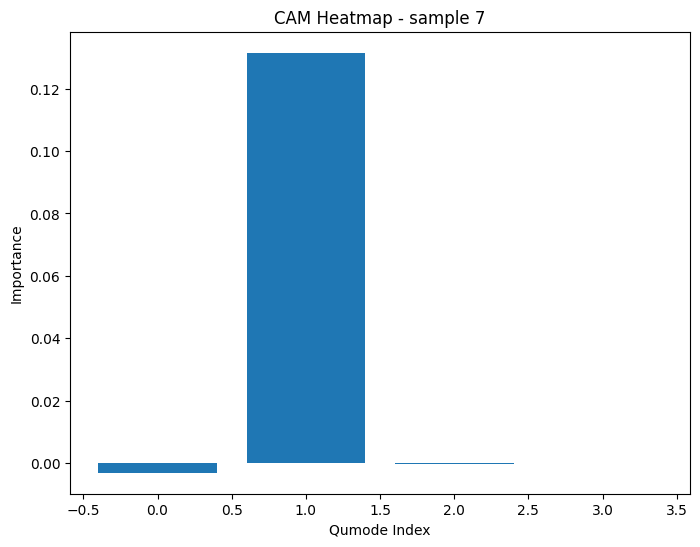

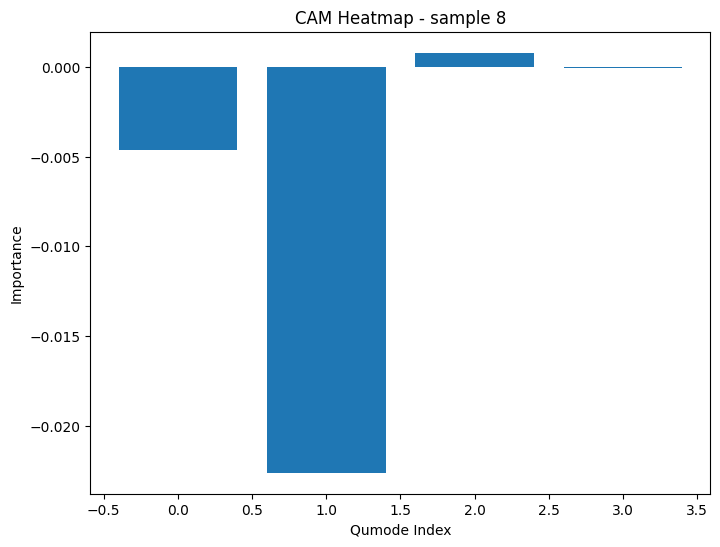

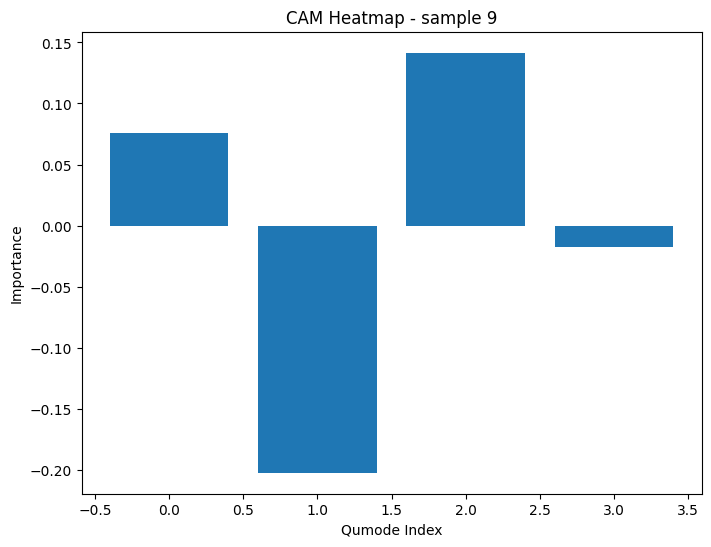

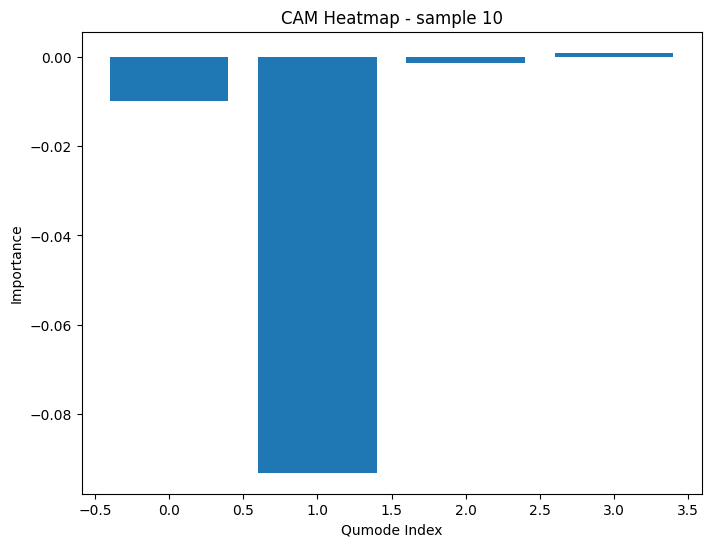

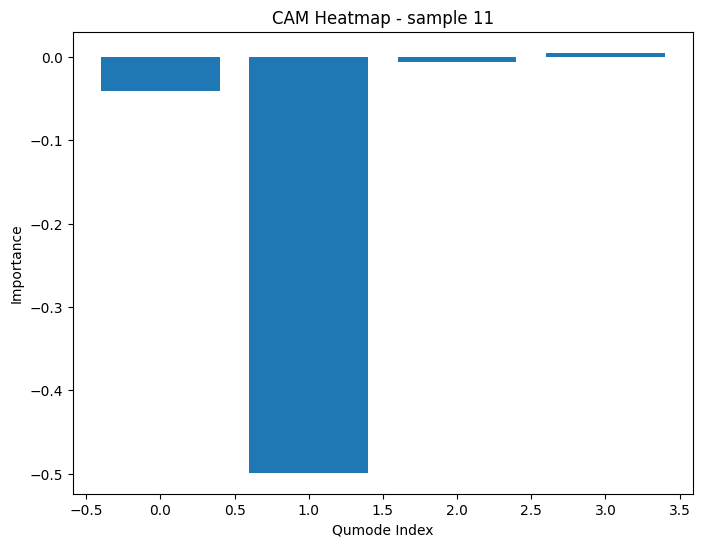

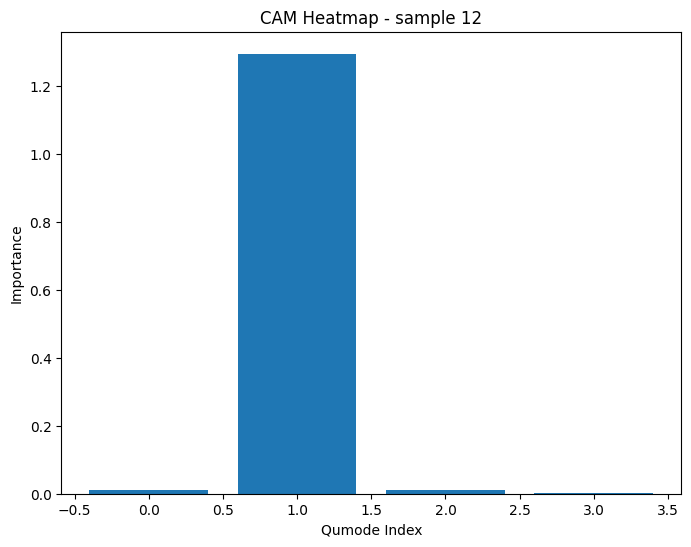

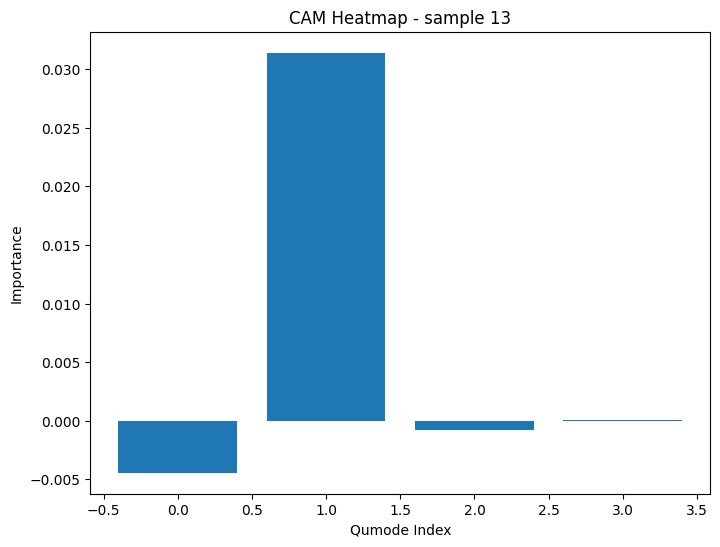

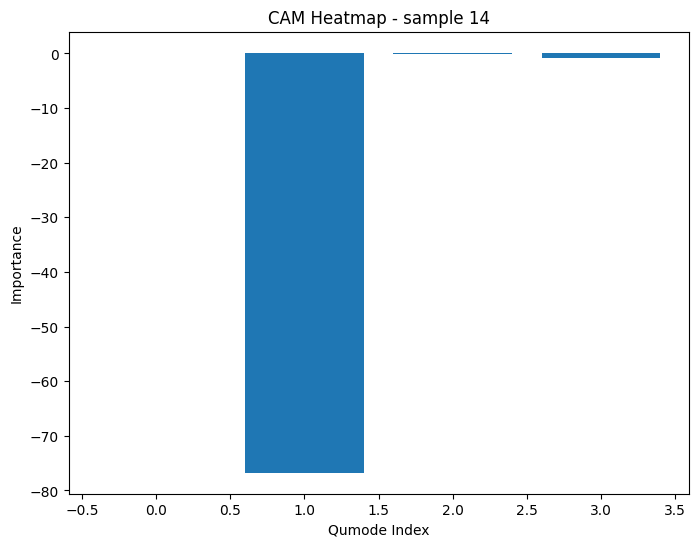

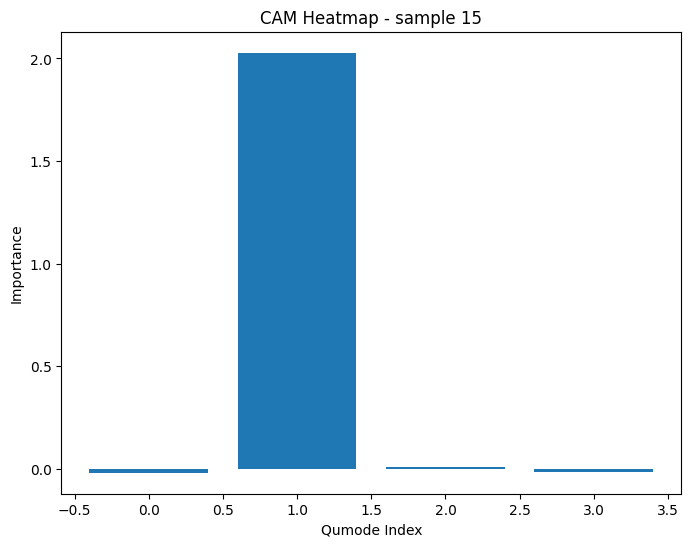

In [184]:
# plot_cam(cam)

In [185]:
components = encoder.pca.components_

In [186]:
x_batch, y_batch = sample_batch(test_raw_loader, n_samples=8)

/tmp/ipykernel_690584/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


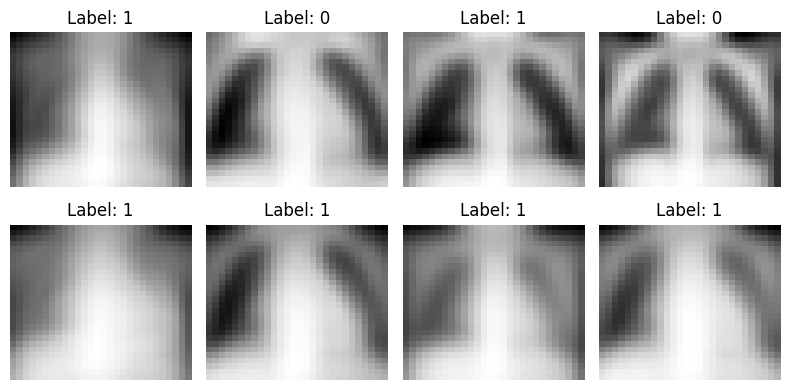

In [187]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

In [188]:
heatmap_image_space = torch.matmul(cam, torch.tensor(components))
heatmap_image_space = heatmap_image_space.view(-1, 1, 28, 28)

In [189]:
heatmap_image_space -= heatmap_image_space.min()
heatmap_image_space /= heatmap_image_space.max()

In [190]:
# for i in range(0,7):    
#     plt.imshow(x_reconstructed[idx, 0], cmap="gray")
#     plt.imshow(heatmap_image_space[idx, 0], cmap="jet", alpha=0.5)
#     plt.axis("off")
#     plt.show()

In [191]:
def plot_reconstructed_heatmaps_with_predictions(samples, cam, preds, probs, labels, encoder, class_names=None):
    n_samples = samples.shape[0]
    # n_rows, n_cols = 4, 4
    n_rows = (n_samples + 3) // 4
    n_cols = 8
    
    assert n_samples <= n_rows * n_cols, "Too many samples"

    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,12))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2.5* n_rows))

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n_samples):
        row = i// 4
        col_base = (i % 4) * 2
    
    # for i in range(n_samples):
    #     ax = axes[i // n_cols, i % n_cols]

        reconstructed = encoder.pca.inverse_transform(samples[i].detach().cpu().numpy().reshape(1, -1))
        reconstructed = torch.tensor(reconstructed).view(1, 1, 28, 28)

        heatmap_cam = cam[i].cpu().numpy().reshape(1, -1)
        heatmap_image = encoder.pca.inverse_transform(heatmap_cam)
        heatmap_image = torch.tensor(heatmap_image).view(1, 1, 28, 28)

        img = reconstructed[0, 0].numpy()
        heat = heatmap_image[0, 0].numpy()

        # ax.imshow(img, cmap="gray")
        # ax.imshow(heat, cmap="jet", alpha=0.45)

        pred_label = class_names[preds[i]] if class_names else str(preds[i].item())
        true_label = class_names[labels[i]] if class_names else str(labels[i].item())
        confidence = f"{probs[i][preds[i]]*100:.1f}%"

        ax1 = axes[row, col_base]
        ax1.imshow(img, cmap="gray")
        ax1.set_title(f"GT: {true_label}", fontsize=9)
        ax1.axis("off")

        ax2 = axes[row, col_base + 1]
        ax2.imshow(img, cmap="gray")
        ax2.imshow(heat, cmap="jet", alpha=0.45)
        ax2.set_title(f"Pred: {pred_label} ({confidence})", fontsize=9)
        ax2.axis("off")

        # ax.set_title(f"GT: {true_label} | Pred: {pred_label} ({confidence})", fontsize=10)
        # ax.axis("off")

    plt.tight_layout()
    plt.show()

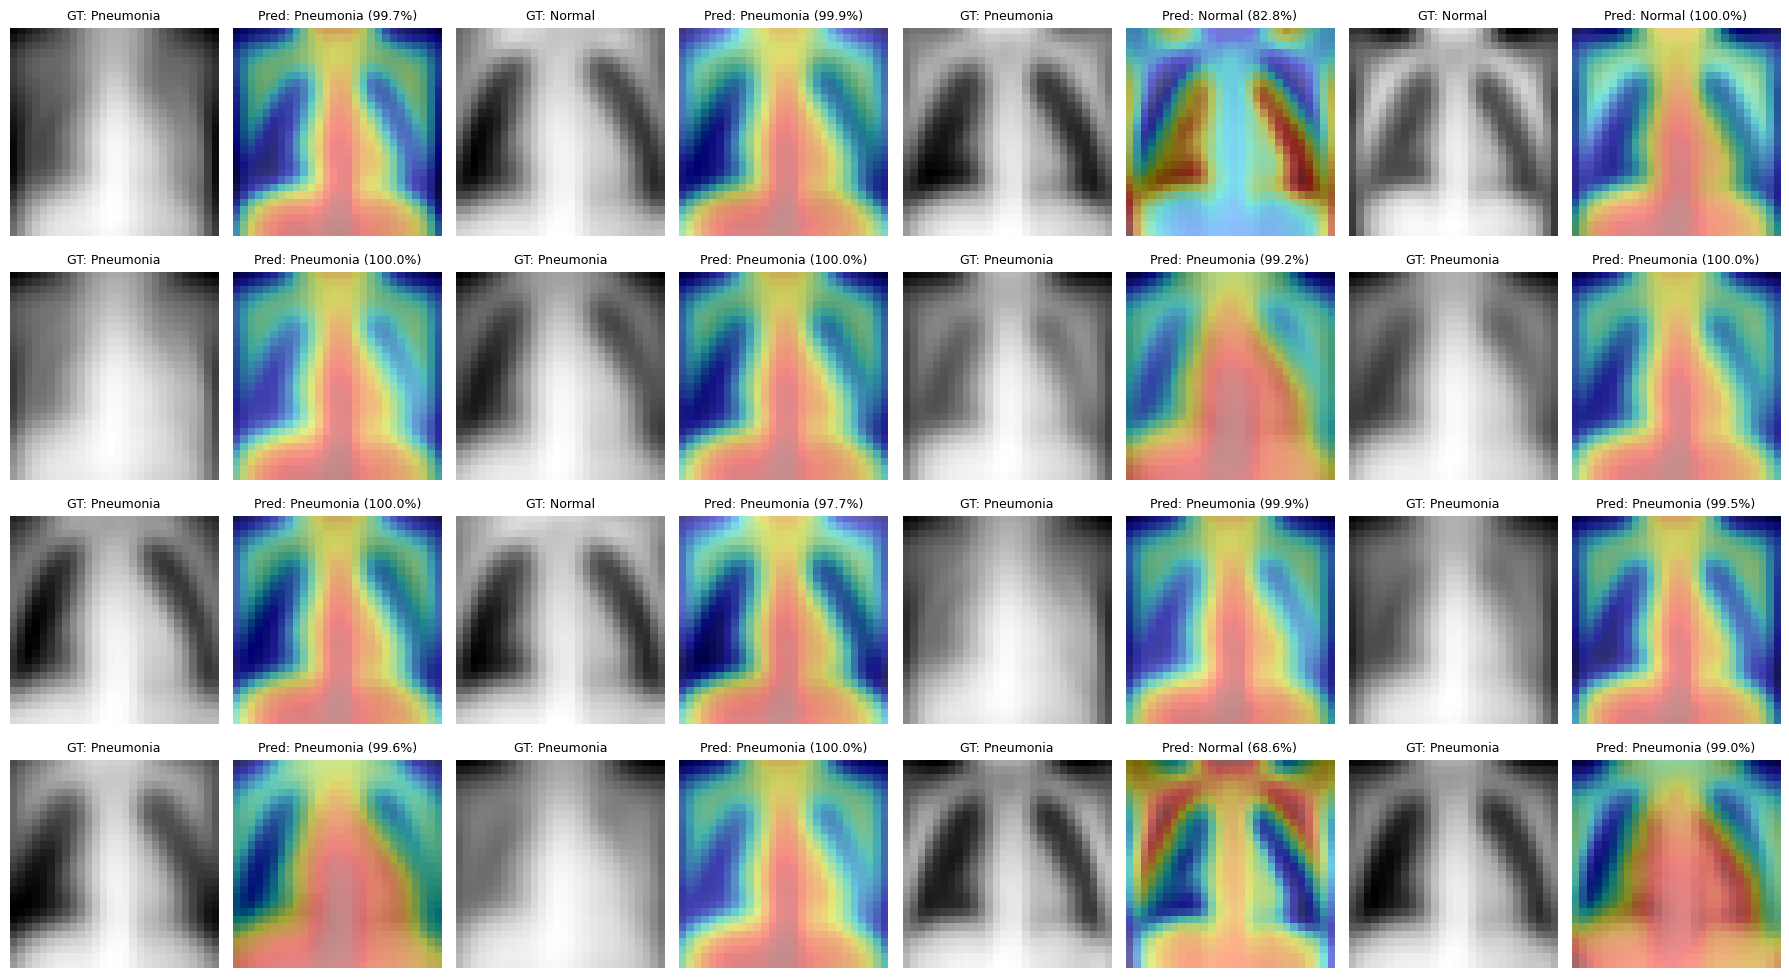

In [192]:
plot_reconstructed_heatmaps_with_predictions(
    samples=samples,
    cam=cam,
    preds=predictions,
    probs=outputs,
    labels=y_sample_labels,
    encoder=encoder,
    class_names=["Normal", "Pneumonia"]
)

In [193]:
# n_samples = len(samples)
# n_cols = 2
# # n_rows = (n_samples + n_cols -1) // n_cols
# n_rows = n_samples

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6,3 * n_rows))

# for i in range(n_samples):
#     reconstructed = encoder.pca.inverse_transform(samples[i].detach().cpu().numpy().reshape(1, -1))
#     reconstructed = torch.tensor(reconstructed).view(28, 28).detach().cpu()

#     heatmap_cam = cam[i].cpu().numpy().reshape(1, -1)
#     heatmap_image = encoder.pca.inverse_transform(heatmap_cam)
#     heatmap_image = torch.tensor(heatmap_image).view(28, 28).detach().cpu()

#     # heatmap_image = (heatmap_image, heatmap_image.min()) / (heatmap_image.max() - heatmap_image.min() + 1e-8)
#     min_val = heatmap_image.min()
#     max_val = heatmap_image.max()
#     denom = (max_val - min_val) + 1e-8

#     if isinstance(min_val, torch.Tensor):
#         min_val = min_val.item()
#     if isinstance(max_val, torch.Tensor):
#         max_val = max_val.item()
#     if isinstance(denom, torch.Tensor):
#         denom = denom.item()

#     heatmap_image = (heatmap_image - min_val) / denom

#     axes[i, 0].imshow(reconstructed, cmap="gray")
#     axes[i, 0].set_title(f"Reconstructed | GT: {y_sample_labels[i].item()}")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(reconstructed, cmap="gray")
#     axes[i, 1].imshow(heatmap_image, cmap="jet", alpha=0.5)
#     axes[i, 1].set_title(f"CAM overlay | Pred: {predictions[i].item()}")
#     axes[i, 1].axis("off")


# plt.tight_layout()
# plt.show()

In [237]:
import numpy as np
noise_std = np.arange(0.1, 1.05, 0.05)
print(noise_std)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.  ]


In [238]:
# noisy_samples = (samples + torch.randn_like(samples) * noise_std[8])
# noisy_samples = noisy_samples.detach().requires_grad_()

In [239]:
# cam_clean, probs_clean, preds_clean = gradcam_model(test_cv_model, samples.to(device), quantum=True)

In [240]:
# plot_reconstructed_heatmaps_with_predictions(
#     samples, cam_clean, preds_clean, probs_clean, y_sample_labels,
#     encoder, class_names=["Normal", "Pneumonia"]
# )

In [241]:
# cam_noisy, probs_noisy, preds_noisy = gradcam_model(test_cv_model, noisy_samples.to(device), quantum=True)

In [242]:
# plot_reconstructed_heatmaps_with_predictions(
#     samples, cam_noisy, preds_noisy, probs_noisy, y_sample_labels,
#     encoder, class_names=["Normal", "Pneumonia"]
# )

In [243]:
# import torch.nn.functional as F

# cos_sim = F.cosine_similarity(cam_clean.view(16, -1), cam_noisy.view(16, -1), dim=1)
# print("Avg CAM similarity:", cos_sim.mean().item())

In [244]:
# accuracies = []
# f1_scores = []
# recalls = []
# precision = []


# full_samples = []
# full_labels = []

# for x_batch, y_batch in test_loader:
#     full_samples.append(x_batch)
#     full_labels.append(y_batch)

# full_samples = torch.cat(full_samples)
# full_labels = torch.cat(full_labels)


# for std in noise_std:
    
#     # noisy_samples = (full_samples + torch.randn_like(full_samples) * std).clamp(0, 1).to(device)
#     noisy_samples = (full_samples + torch.randn_like(full_samples) * std).to(device)
#     full_labels = full_labels.to(device)
#     print(f"[STD: {std:.2f}] Clean mean: {full_samples.mean().item():.4f}, Noisy mean: {noisy_samples.mean().item():.4f}")
#     noisy_dataset = TensorDataset(noisy_samples, full_labels)
#     noisy_loader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)
    
#     _, acc, prec, rec, f1, _, _, _, _ = evaluate_v2(test_cv_model,
#                                                noisy_loader,
#                                               criterion,
#                                               device)
#     accuracies.append(acc)
#     recalls.append(rec)
#     precision.append(prec)
#     f1_scores.append(f1)
    
#     print(f"Noise STD: {std:.2f} -> accuracy: {acc:.4f}, f1:{f1:.4f}")

torch.Size([624, 4]) torch.Size([624, 1])
[STD: 0.10] Clean mean: 0.0186, Noisy mean: 0.0169


Training: 100%|████████| 20/20 [00:02<00:00,  9.39it/s, loss=0.4625, acc=0.8429]


Noise STD: 0.10 -> accuracy: 0.8429, f1:0.8429
[STD: 0.15] Clean mean: 0.0186, Noisy mean: 0.0137


Training: 100%|████████| 20/20 [00:02<00:00,  9.38it/s, loss=0.4633, acc=0.8462]


Noise STD: 0.15 -> accuracy: 0.8462, f1:0.8462
[STD: 0.20] Clean mean: 0.0186, Noisy mean: 0.0214


Training: 100%|████████| 20/20 [00:01<00:00, 10.81it/s, loss=0.4629, acc=0.8446]


Noise STD: 0.20 -> accuracy: 0.8446, f1:0.8446
[STD: 0.25] Clean mean: 0.0186, Noisy mean: 0.0157


Training: 100%|████████| 20/20 [00:02<00:00,  9.40it/s, loss=0.4675, acc=0.8413]


Noise STD: 0.25 -> accuracy: 0.8413, f1:0.8413
[STD: 0.30] Clean mean: 0.0186, Noisy mean: 0.0072


Training: 100%|████████| 20/20 [00:02<00:00,  9.41it/s, loss=0.4747, acc=0.8317]


Noise STD: 0.30 -> accuracy: 0.8317, f1:0.8317
[STD: 0.35] Clean mean: 0.0186, Noisy mean: 0.0149


Training: 100%|████████| 20/20 [00:02<00:00,  9.34it/s, loss=0.4901, acc=0.8125]


Noise STD: 0.35 -> accuracy: 0.8125, f1:0.8125
[STD: 0.40] Clean mean: 0.0186, Noisy mean: 0.0146


Training: 100%|████████| 20/20 [00:02<00:00,  9.37it/s, loss=0.4682, acc=0.8446]


Noise STD: 0.40 -> accuracy: 0.8446, f1:0.8446
[STD: 0.45] Clean mean: 0.0186, Noisy mean: 0.0098


Training: 100%|████████| 20/20 [00:01<00:00, 10.69it/s, loss=0.5053, acc=0.7917]


Noise STD: 0.45 -> accuracy: 0.7917, f1:0.7917
[STD: 0.50] Clean mean: 0.0186, Noisy mean: 0.0094


Training: 100%|████████| 20/20 [00:02<00:00,  9.29it/s, loss=0.4839, acc=0.8237]


Noise STD: 0.50 -> accuracy: 0.8237, f1:0.8237
[STD: 0.55] Clean mean: 0.0186, Noisy mean: 0.0206


Training: 100%|████████| 20/20 [00:02<00:00,  9.34it/s, loss=0.4925, acc=0.8109]


Noise STD: 0.55 -> accuracy: 0.8109, f1:0.8109
[STD: 0.60] Clean mean: 0.0186, Noisy mean: 0.0132


Training: 100%|████████| 20/20 [00:02<00:00,  9.27it/s, loss=0.5186, acc=0.7756]


Noise STD: 0.60 -> accuracy: 0.7756, f1:0.7756
[STD: 0.65] Clean mean: 0.0186, Noisy mean: 0.0365


Training: 100%|████████| 20/20 [00:01<00:00, 10.85it/s, loss=0.5318, acc=0.7676]


Noise STD: 0.65 -> accuracy: 0.7676, f1:0.7676
[STD: 0.70] Clean mean: 0.0186, Noisy mean: 0.0325


Training: 100%|████████| 20/20 [00:02<00:00,  9.33it/s, loss=0.5236, acc=0.7740]


Noise STD: 0.70 -> accuracy: 0.7740, f1:0.7740
[STD: 0.75] Clean mean: 0.0186, Noisy mean: 0.0235


Training: 100%|████████| 20/20 [00:02<00:00,  9.30it/s, loss=0.5298, acc=0.7740]


Noise STD: 0.75 -> accuracy: 0.7740, f1:0.7740
[STD: 0.80] Clean mean: 0.0186, Noisy mean: 0.0144


Training: 100%|████████| 20/20 [00:02<00:00,  9.30it/s, loss=0.5345, acc=0.7564]


Noise STD: 0.80 -> accuracy: 0.7564, f1:0.7564
[STD: 0.85] Clean mean: 0.0186, Noisy mean: 0.0088


Training: 100%|████████| 20/20 [00:02<00:00,  9.21it/s, loss=0.5542, acc=0.7420]


Noise STD: 0.85 -> accuracy: 0.7420, f1:0.7420
[STD: 0.90] Clean mean: 0.0186, Noisy mean: 0.0068


Training: 100%|████████| 20/20 [00:01<00:00, 10.74it/s, loss=0.5524, acc=0.7372]


Noise STD: 0.90 -> accuracy: 0.7372, f1:0.7372
[STD: 0.95] Clean mean: 0.0186, Noisy mean: 0.0269


Training: 100%|████████| 20/20 [00:02<00:00,  9.31it/s, loss=0.5262, acc=0.7708]


Noise STD: 0.95 -> accuracy: 0.7708, f1:0.7708
[STD: 1.00] Clean mean: 0.0186, Noisy mean: 0.0073


Training: 100%|████████| 20/20 [00:02<00:00,  9.29it/s, loss=0.5479, acc=0.7564]

Noise STD: 1.00 -> accuracy: 0.7564, f1:0.7564


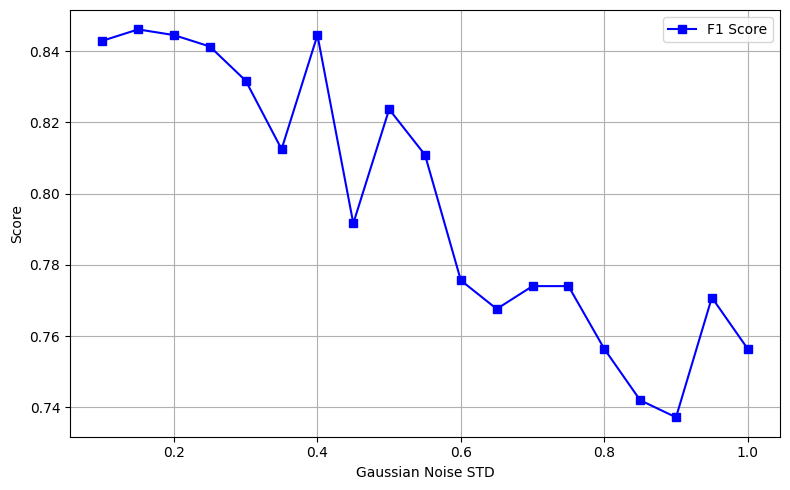

In [245]:
# plt.figure(figsize=(8,5))
# # plt.plot(noise_std, accuracies, marker="o", label="Accuracy", color="blue")
# plt.plot(noise_std, f1_scores, marker="s", label="F1 Score", color="blue")
# plt.xlabel("Gaussian Noise STD")
# plt.ylabel("F1 Score")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## CLASSICAL MODEL

In [247]:
# epochs = 10
epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
│    └─Softmax: 2-4                      --
Total params: 30
Trainable params: 30
Non-trainable params: 0

In [71]:
# run_kfold_training(classical_model, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=epochs, seed=42)
run_kfold_training(ClassicalModel, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|███████| 50/50 [00:00<00:00, 598.47it/s, loss=0.6085, acc=0.7420]


Train loss: 0.6241 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.6085 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 686.38it/s, loss=0.5801, acc=0.7420]


Train loss: 0.5954 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5801 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 662.94it/s, loss=0.5564, acc=0.7420]


Train loss: 0.5678 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5564 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 703.39it/s, loss=0.5400, acc=0.7420]


Train loss: 0.5471 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5400 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 643.85it/s, loss=0.5276, acc=0.7420]


Train loss: 0.5323 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5276 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 638.86it/s, loss=0.5172, acc=0.7420]


Train loss: 0.5205 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5172 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 572.03it/s, loss=0.5069, acc=0.7420]


Train loss: 0.5096 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.5069 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 620.23it/s, loss=0.4971, acc=0.7420]


Train loss: 0.4992 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.4971 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 633.82it/s, loss=0.4879, acc=0.7420]


Train loss: 0.4892 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.4879 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 704.36it/s, loss=0.4793, acc=0.7420]


Train loss: 0.4800 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.4793 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 678.26it/s, loss=0.4715, acc=0.7420]


Train loss: 0.4712 | Train acc: 0.7422 | Train rec: 0.7422 | Train prec: 0.5508 | Train f1: 0.6324
Val loss: 0.4715 | Val acc: 0.7420 | Val rec: 0.7420 | Val prec: 0.5506 | Val f1: 0.7420


Training: 100%|███████| 50/50 [00:00<00:00, 659.82it/s, loss=0.4644, acc=0.8866]


Train loss: 0.4636 | Train acc: 0.8636 | Train rec: 0.8636 | Train prec: 0.8641 | Train f1: 0.8526
Val loss: 0.4644 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8838 | Val f1: 0.8866


Training: 100%|███████| 50/50 [00:00<00:00, 710.09it/s, loss=0.4583, acc=0.8904]


Train loss: 0.4566 | Train acc: 0.8964 | Train rec: 0.8964 | Train prec: 0.8943 | Train f1: 0.8934
Val loss: 0.4583 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8880 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 709.60it/s, loss=0.4526, acc=0.8968]


Train loss: 0.4507 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8965 | Train f1: 0.8962
Val loss: 0.4526 | Val acc: 0.8968 | Val rec: 0.8968 | Val prec: 0.8950 | Val f1: 0.8968


Training: 100%|███████| 50/50 [00:00<00:00, 618.31it/s, loss=0.4476, acc=0.8994]


Train loss: 0.4455 | Train acc: 0.8983 | Train rec: 0.8983 | Train prec: 0.8962 | Train f1: 0.8961
Val loss: 0.4476 | Val acc: 0.8994 | Val rec: 0.8994 | Val prec: 0.8978 | Val f1: 0.8994


Training: 100%|███████| 50/50 [00:00<00:00, 632.74it/s, loss=0.4435, acc=0.9000]


Train loss: 0.4411 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8983 | Train f1: 0.8987
Val loss: 0.4435 | Val acc: 0.9000 | Val rec: 0.9000 | Val prec: 0.8988 | Val f1: 0.9000


Training: 100%|███████| 50/50 [00:00<00:00, 668.06it/s, loss=0.4398, acc=0.9013]


Train loss: 0.4372 | Train acc: 0.9025 | Train rec: 0.9025 | Train prec: 0.9007 | Train f1: 0.9011
Val loss: 0.4398 | Val acc: 0.9013 | Val rec: 0.9013 | Val prec: 0.9005 | Val f1: 0.9013


Training: 100%|███████| 50/50 [00:00<00:00, 644.36it/s, loss=0.4367, acc=0.9019]


Train loss: 0.4339 | Train acc: 0.9015 | Train rec: 0.9015 | Train prec: 0.8999 | Train f1: 0.9003
Val loss: 0.4367 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9011 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 650.52it/s, loss=0.4339, acc=0.9013]


Train loss: 0.4310 | Train acc: 0.9028 | Train rec: 0.9028 | Train prec: 0.9014 | Train f1: 0.9019
Val loss: 0.4339 | Val acc: 0.9013 | Val rec: 0.9013 | Val prec: 0.9005 | Val f1: 0.9013


Training: 100%|███████| 50/50 [00:00<00:00, 621.03it/s, loss=0.4314, acc=0.9025]


Train loss: 0.4285 | Train acc: 0.9041 | Train rec: 0.9041 | Train prec: 0.9026 | Train f1: 0.9030
Val loss: 0.4314 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9019 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 723.28it/s, loss=0.4295, acc=0.9006]


Train loss: 0.4264 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9031 | Train f1: 0.9035
Val loss: 0.4295 | Val acc: 0.9006 | Val rec: 0.9006 | Val prec: 0.9002 | Val f1: 0.9006


Training: 100%|███████| 50/50 [00:00<00:00, 601.76it/s, loss=0.4275, acc=0.9019]


Train loss: 0.4245 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9040 | Train f1: 0.9044
Val loss: 0.4275 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9015 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 645.98it/s, loss=0.4260, acc=0.9032]


Train loss: 0.4230 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9042 | Train f1: 0.9047
Val loss: 0.4260 | Val acc: 0.9032 | Val rec: 0.9032 | Val prec: 0.9027 | Val f1: 0.9032


Training: 100%|███████| 50/50 [00:00<00:00, 635.65it/s, loss=0.4245, acc=0.9019]


Train loss: 0.4214 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9048 | Train f1: 0.9053
Val loss: 0.4245 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9016 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 629.39it/s, loss=0.4232, acc=0.9019]


Train loss: 0.4201 | Train acc: 0.9041 | Train rec: 0.9041 | Train prec: 0.9031 | Train f1: 0.9035
Val loss: 0.4232 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9016 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 689.39it/s, loss=0.4221, acc=0.9019]


Train loss: 0.4189 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9044 | Train f1: 0.9048
Val loss: 0.4221 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9016 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 613.31it/s, loss=0.4211, acc=0.9019]


Train loss: 0.4178 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9044 | Train f1: 0.9047
Val loss: 0.4211 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9016 | Val f1: 0.9019


Training: 100%|███████| 50/50 [00:00<00:00, 657.96it/s, loss=0.4198, acc=0.9025]


Train loss: 0.4168 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9048 | Train f1: 0.9053
Val loss: 0.4198 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9022 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 591.65it/s, loss=0.4189, acc=0.9025]


Train loss: 0.4159 | Train acc: 0.9069 | Train rec: 0.9069 | Train prec: 0.9060 | Train f1: 0.9064
Val loss: 0.4189 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9025 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 608.03it/s, loss=0.4180, acc=0.9019]


Train loss: 0.4151 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9054 | Train f1: 0.9057
Val loss: 0.4180 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9018 | Val f1: 0.9019

 Fold 2/3


Training: 100%|███████| 50/50 [00:00<00:00, 625.83it/s, loss=0.6358, acc=0.7419]


Train loss: 0.6626 | Train acc: 0.7171 | Train rec: 0.7171 | Train prec: 0.6595 | Train f1: 0.6705
Val loss: 0.6358 | Val acc: 0.7419 | Val rec: 0.7419 | Val prec: 0.5512 | Val f1: 0.7419


Training: 100%|███████| 50/50 [00:00<00:00, 641.74it/s, loss=0.5821, acc=0.7470]


Train loss: 0.6091 | Train acc: 0.7429 | Train rec: 0.7429 | Train prec: 0.8091 | Train f1: 0.6343
Val loss: 0.5821 | Val acc: 0.7470 | Val rec: 0.7470 | Val prec: 0.7829 | Val f1: 0.7470


Training: 100%|███████| 50/50 [00:00<00:00, 631.20it/s, loss=0.5311, acc=0.8502]


Train loss: 0.5571 | Train acc: 0.8057 | Train rec: 0.8057 | Train prec: 0.8290 | Train f1: 0.7630
Val loss: 0.5311 | Val acc: 0.8502 | Val rec: 0.8502 | Val prec: 0.8546 | Val f1: 0.8502


Training: 100%|███████| 50/50 [00:00<00:00, 647.04it/s, loss=0.4891, acc=0.8846]


Train loss: 0.5105 | Train acc: 0.8672 | Train rec: 0.8672 | Train prec: 0.8679 | Train f1: 0.8568
Val loss: 0.4891 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8819 | Val f1: 0.8846


Training: 100%|███████| 50/50 [00:00<00:00, 694.73it/s, loss=0.4599, acc=0.9006]


Train loss: 0.4761 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8871 | Train f1: 0.8855
Val loss: 0.4599 | Val acc: 0.9006 | Val rec: 0.9006 | Val prec: 0.8987 | Val f1: 0.9006


Training: 100%|███████| 50/50 [00:00<00:00, 647.35it/s, loss=0.4412, acc=0.9031]


Train loss: 0.4533 | Train acc: 0.8930 | Train rec: 0.8930 | Train prec: 0.8906 | Train f1: 0.8907
Val loss: 0.4412 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9018 | Val f1: 0.9031


Training: 100%|███████| 50/50 [00:00<00:00, 712.15it/s, loss=0.4301, acc=0.9031]


Train loss: 0.4392 | Train acc: 0.8949 | Train rec: 0.8949 | Train prec: 0.8928 | Train f1: 0.8932
Val loss: 0.4301 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9024 | Val f1: 0.9031


Training: 100%|███████| 50/50 [00:00<00:00, 622.64it/s, loss=0.4233, acc=0.9012]


Train loss: 0.4308 | Train acc: 0.8965 | Train rec: 0.8965 | Train prec: 0.8951 | Train f1: 0.8956
Val loss: 0.4233 | Val acc: 0.9012 | Val rec: 0.9012 | Val prec: 0.9007 | Val f1: 0.9012


Training: 100%|███████| 50/50 [00:00<00:00, 621.74it/s, loss=0.4192, acc=0.9018]


Train loss: 0.4256 | Train acc: 0.8952 | Train rec: 0.8952 | Train prec: 0.8938 | Train f1: 0.8943
Val loss: 0.4192 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9014 | Val f1: 0.9018


Training: 100%|███████| 50/50 [00:00<00:00, 646.84it/s, loss=0.4163, acc=0.9031]


Train loss: 0.4221 | Train acc: 0.8961 | Train rec: 0.8961 | Train prec: 0.8948 | Train f1: 0.8953
Val loss: 0.4163 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9027 | Val f1: 0.9031


Training: 100%|███████| 50/50 [00:00<00:00, 684.63it/s, loss=0.4141, acc=0.9012]


Train loss: 0.4195 | Train acc: 0.8974 | Train rec: 0.8974 | Train prec: 0.8958 | Train f1: 0.8963
Val loss: 0.4141 | Val acc: 0.9012 | Val rec: 0.9012 | Val prec: 0.9008 | Val f1: 0.9012


Training: 100%|███████| 50/50 [00:00<00:00, 665.06it/s, loss=0.4125, acc=0.9031]


Train loss: 0.4175 | Train acc: 0.8984 | Train rec: 0.8984 | Train prec: 0.8969 | Train f1: 0.8974
Val loss: 0.4125 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9025 | Val f1: 0.9031


Training: 100%|███████| 50/50 [00:00<00:00, 596.11it/s, loss=0.4112, acc=0.9018]


Train loss: 0.4158 | Train acc: 0.8971 | Train rec: 0.8971 | Train prec: 0.8953 | Train f1: 0.8958
Val loss: 0.4112 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9010 | Val f1: 0.9018


Training: 100%|███████| 50/50 [00:00<00:00, 711.89it/s, loss=0.4100, acc=0.9025]


Train loss: 0.4145 | Train acc: 0.8977 | Train rec: 0.8977 | Train prec: 0.8963 | Train f1: 0.8968
Val loss: 0.4100 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9018 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 627.73it/s, loss=0.4090, acc=0.9025]


Train loss: 0.4134 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8978 | Train f1: 0.8983
Val loss: 0.4090 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9018 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 630.49it/s, loss=0.4081, acc=0.9025]


Train loss: 0.4124 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8989 | Train f1: 0.8993
Val loss: 0.4081 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9018 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 710.81it/s, loss=0.4074, acc=0.9018]


Train loss: 0.4116 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8988 | Train f1: 0.8993
Val loss: 0.4074 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9013 | Val f1: 0.9018


Training: 100%|███████| 50/50 [00:00<00:00, 621.18it/s, loss=0.4067, acc=0.9012]


Train loss: 0.4109 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8992 | Train f1: 0.8997
Val loss: 0.4067 | Val acc: 0.9012 | Val rec: 0.9012 | Val prec: 0.9004 | Val f1: 0.9012


Training: 100%|███████| 50/50 [00:00<00:00, 636.75it/s, loss=0.4062, acc=0.9038]


Train loss: 0.4103 | Train acc: 0.9016 | Train rec: 0.9016 | Train prec: 0.9002 | Train f1: 0.9007
Val loss: 0.4062 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9033 | Val f1: 0.9038


Training: 100%|███████| 50/50 [00:00<00:00, 540.59it/s, loss=0.4057, acc=0.9018]


Train loss: 0.4097 | Train acc: 0.9016 | Train rec: 0.9016 | Train prec: 0.9000 | Train f1: 0.9005
Val loss: 0.4057 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9013 | Val f1: 0.9018


Training: 100%|███████| 50/50 [00:00<00:00, 663.72it/s, loss=0.4052, acc=0.9018]


Train loss: 0.4093 | Train acc: 0.9016 | Train rec: 0.9016 | Train prec: 0.9002 | Train f1: 0.9007
Val loss: 0.4052 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9013 | Val f1: 0.9018


Training: 100%|███████| 50/50 [00:00<00:00, 614.47it/s, loss=0.4048, acc=0.9025]


Train loss: 0.4089 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8998 | Train f1: 0.9002
Val loss: 0.4048 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9020 | Val f1: 0.9025


Training: 100%|███████| 50/50 [00:00<00:00, 613.38it/s, loss=0.4044, acc=0.9038]


Train loss: 0.4085 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8996 | Train f1: 0.9000
Val loss: 0.4044 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9034 | Val f1: 0.9038


Training: 100%|███████| 50/50 [00:00<00:00, 671.97it/s, loss=0.4041, acc=0.9038]


Train loss: 0.4082 | Train acc: 0.9016 | Train rec: 0.9016 | Train prec: 0.9001 | Train f1: 0.9005
Val loss: 0.4041 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9031 | Val f1: 0.9038


Training: 100%|███████| 50/50 [00:00<00:00, 576.82it/s, loss=0.4037, acc=0.9038]


Train loss: 0.4079 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9007 | Train f1: 0.9011
Val loss: 0.4037 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9033 | Val f1: 0.9038


Training: 100%|███████| 50/50 [00:00<00:00, 441.01it/s, loss=0.4034, acc=0.9057]


Train loss: 0.4076 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9009 | Train f1: 0.9014
Val loss: 0.4034 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057


Training: 100%|███████| 50/50 [00:00<00:00, 641.00it/s, loss=0.4031, acc=0.9057]


Train loss: 0.4074 | Train acc: 0.9025 | Train rec: 0.9025 | Train prec: 0.9015 | Train f1: 0.9019
Val loss: 0.4031 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9055 | Val f1: 0.9057


Training: 100%|███████| 50/50 [00:00<00:00, 582.55it/s, loss=0.4029, acc=0.9050]


Train loss: 0.4073 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9010 | Train f1: 0.9014
Val loss: 0.4029 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9048 | Val f1: 0.9050


Training: 100%|███████| 50/50 [00:00<00:00, 642.03it/s, loss=0.4027, acc=0.9057]


Train loss: 0.4070 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8999 | Train f1: 0.9004
Val loss: 0.4027 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057


Training: 100%|███████| 50/50 [00:00<00:00, 643.47it/s, loss=0.4024, acc=0.9057]


Train loss: 0.4067 | Train acc: 0.9032 | Train rec: 0.9032 | Train prec: 0.9020 | Train f1: 0.9024
Val loss: 0.4024 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057

 Fold 3/3


Training: 100%|███████| 50/50 [00:00<00:00, 616.76it/s, loss=0.7039, acc=0.2951]


Train loss: 0.7362 | Train acc: 0.2580 | Train rec: 0.2580 | Train prec: 0.8087 | Train f1: 0.1063
Val loss: 0.7039 | Val acc: 0.2951 | Val rec: 0.2951 | Val prec: 0.8111 | Val f1: 0.2951


Training: 100%|███████| 50/50 [00:00<00:00, 630.64it/s, loss=0.6340, acc=0.7170]


Train loss: 0.6726 | Train acc: 0.5024 | Train rec: 0.5024 | Train prec: 0.8148 | Train f1: 0.5017
Val loss: 0.6340 | Val acc: 0.7170 | Val rec: 0.7170 | Val prec: 0.8282 | Val f1: 0.7170


Training: 100%|███████| 50/50 [00:00<00:00, 599.96it/s, loss=0.5686, acc=0.8502]


Train loss: 0.6040 | Train acc: 0.7674 | Train rec: 0.7674 | Train prec: 0.8361 | Train f1: 0.7811
Val loss: 0.5686 | Val acc: 0.8502 | Val rec: 0.8502 | Val prec: 0.8662 | Val f1: 0.8502


Training: 100%|███████| 50/50 [00:00<00:00, 626.94it/s, loss=0.5206, acc=0.8783]


Train loss: 0.5469 | Train acc: 0.8675 | Train rec: 0.8675 | Train prec: 0.8759 | Train f1: 0.8703
Val loss: 0.5206 | Val acc: 0.8783 | Val rec: 0.8783 | Val prec: 0.8827 | Val f1: 0.8783


Training: 100%|███████| 50/50 [00:00<00:00, 562.95it/s, loss=0.4885, acc=0.8866]


Train loss: 0.5067 | Train acc: 0.8812 | Train rec: 0.8812 | Train prec: 0.8843 | Train f1: 0.8824
Val loss: 0.4885 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8877 | Val f1: 0.8866


Training: 100%|███████| 50/50 [00:00<00:00, 674.67it/s, loss=0.4666, acc=0.8897]


Train loss: 0.4788 | Train acc: 0.8853 | Train rec: 0.8853 | Train prec: 0.8866 | Train f1: 0.8859
Val loss: 0.4666 | Val acc: 0.8897 | Val rec: 0.8897 | Val prec: 0.8893 | Val f1: 0.8897


Training: 100%|███████| 50/50 [00:00<00:00, 588.77it/s, loss=0.4519, acc=0.8904]


Train loss: 0.4592 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8879 | Train f1: 0.8879
Val loss: 0.4519 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8897 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 656.48it/s, loss=0.4421, acc=0.8904]


Train loss: 0.4461 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8900 | Train f1: 0.8900
Val loss: 0.4421 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8894 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 648.76it/s, loss=0.4357, acc=0.8891]


Train loss: 0.4373 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8899 | Train f1: 0.8901
Val loss: 0.4357 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8879 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 649.28it/s, loss=0.4314, acc=0.8891]


Train loss: 0.4313 | Train acc: 0.8907 | Train rec: 0.8907 | Train prec: 0.8903 | Train f1: 0.8905
Val loss: 0.4314 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8877 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 602.22it/s, loss=0.4285, acc=0.8878]


Train loss: 0.4273 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8936 | Train f1: 0.8940
Val loss: 0.4285 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8860 | Val f1: 0.8878


Training: 100%|███████| 50/50 [00:00<00:00, 667.66it/s, loss=0.4263, acc=0.8878]


Train loss: 0.4244 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8928 | Train f1: 0.8933
Val loss: 0.4263 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8860 | Val f1: 0.8878


Training: 100%|███████| 50/50 [00:00<00:00, 652.81it/s, loss=0.4248, acc=0.8872]


Train loss: 0.4224 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8931 | Train f1: 0.8935
Val loss: 0.4248 | Val acc: 0.8872 | Val rec: 0.8872 | Val prec: 0.8851 | Val f1: 0.8872


Training: 100%|███████| 50/50 [00:00<00:00, 569.69it/s, loss=0.4236, acc=0.8872]


Train loss: 0.4208 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8934 | Train f1: 0.8939
Val loss: 0.4236 | Val acc: 0.8872 | Val rec: 0.8872 | Val prec: 0.8851 | Val f1: 0.8872


Training: 100%|███████| 50/50 [00:00<00:00, 539.56it/s, loss=0.4227, acc=0.8891]


Train loss: 0.4197 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8923 | Train f1: 0.8928
Val loss: 0.4227 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8869 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 641.93it/s, loss=0.4221, acc=0.8885]


Train loss: 0.4188 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8927 | Train f1: 0.8932
Val loss: 0.4221 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8862 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 554.95it/s, loss=0.4215, acc=0.8885]


Train loss: 0.4179 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8933 | Train f1: 0.8938
Val loss: 0.4215 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8862 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 686.81it/s, loss=0.4210, acc=0.8891]


Train loss: 0.4173 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8925 | Train f1: 0.8930
Val loss: 0.4210 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8869 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 653.28it/s, loss=0.4206, acc=0.8891]


Train loss: 0.4168 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8929 | Train f1: 0.8934
Val loss: 0.4206 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8869 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 659.28it/s, loss=0.4203, acc=0.8878]


Train loss: 0.4164 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8930 | Train f1: 0.8935
Val loss: 0.4203 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8856 | Val f1: 0.8878


Training: 100%|███████| 50/50 [00:00<00:00, 687.27it/s, loss=0.4201, acc=0.8891]


Train loss: 0.4160 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8924 | Train f1: 0.8929
Val loss: 0.4201 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8868 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 641.78it/s, loss=0.4201, acc=0.8885]


Train loss: 0.4158 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8916 | Train f1: 0.8921
Val loss: 0.4201 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8860 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 649.07it/s, loss=0.4197, acc=0.8891]


Train loss: 0.4155 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8916 | Train f1: 0.8922
Val loss: 0.4197 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8867 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 617.47it/s, loss=0.4195, acc=0.8885]


Train loss: 0.4152 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8919 | Train f1: 0.8924
Val loss: 0.4195 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8862 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 654.51it/s, loss=0.4192, acc=0.8878]


Train loss: 0.4150 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8923 | Train f1: 0.8928
Val loss: 0.4192 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8856 | Val f1: 0.8878


Training: 100%|███████| 50/50 [00:00<00:00, 588.57it/s, loss=0.4193, acc=0.8891]


Train loss: 0.4149 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8917 | Train f1: 0.8923
Val loss: 0.4193 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8867 | Val f1: 0.8891


Training: 100%|███████| 50/50 [00:00<00:00, 617.43it/s, loss=0.4191, acc=0.8897]


Train loss: 0.4147 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8921 | Train f1: 0.8926
Val loss: 0.4191 | Val acc: 0.8897 | Val rec: 0.8897 | Val prec: 0.8874 | Val f1: 0.8897


Training: 100%|███████| 50/50 [00:00<00:00, 640.25it/s, loss=0.4189, acc=0.8904]


Train loss: 0.4145 | Train acc: 0.8926 | Train rec: 0.8926 | Train prec: 0.8912 | Train f1: 0.8918
Val loss: 0.4189 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8882 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 624.46it/s, loss=0.4188, acc=0.8904]


Train loss: 0.4144 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8919 | Train f1: 0.8924
Val loss: 0.4188 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8881 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 571.44it/s, loss=0.4187, acc=0.8910]


Train loss: 0.4143 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8921 | Train f1: 0.8927
Val loss: 0.4187 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8888 | Val f1: 0.8910


In [248]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

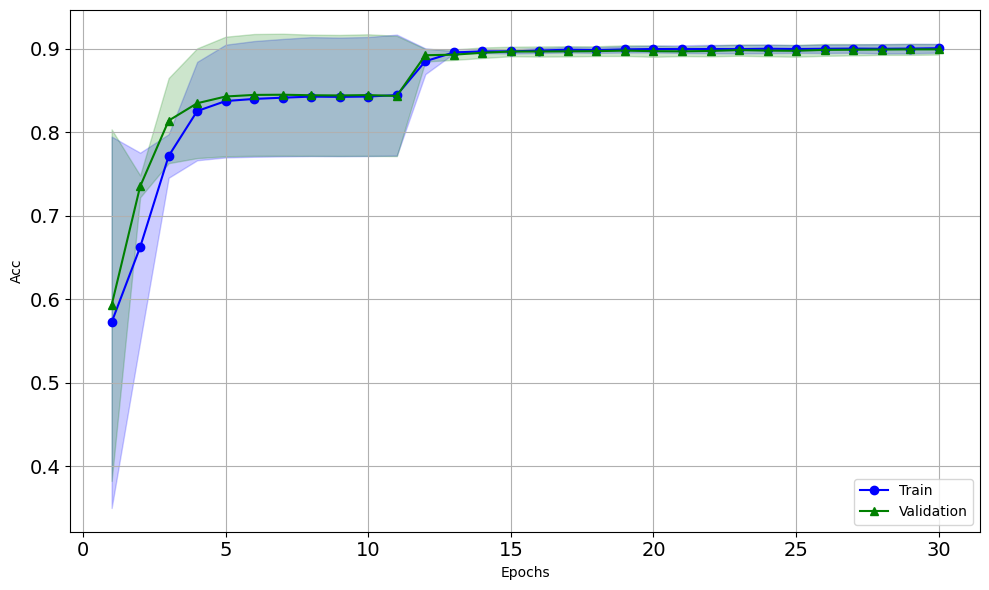

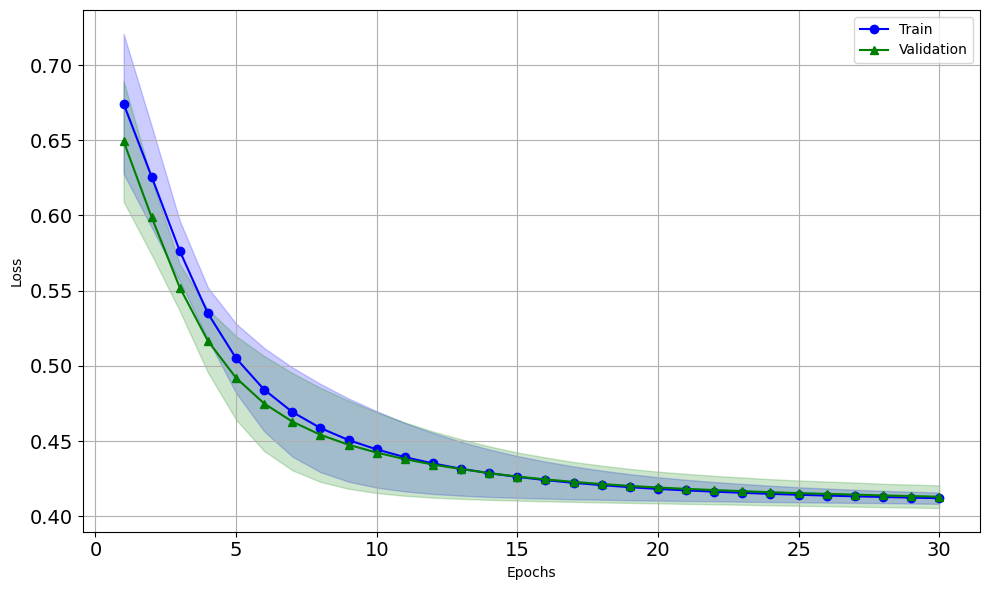

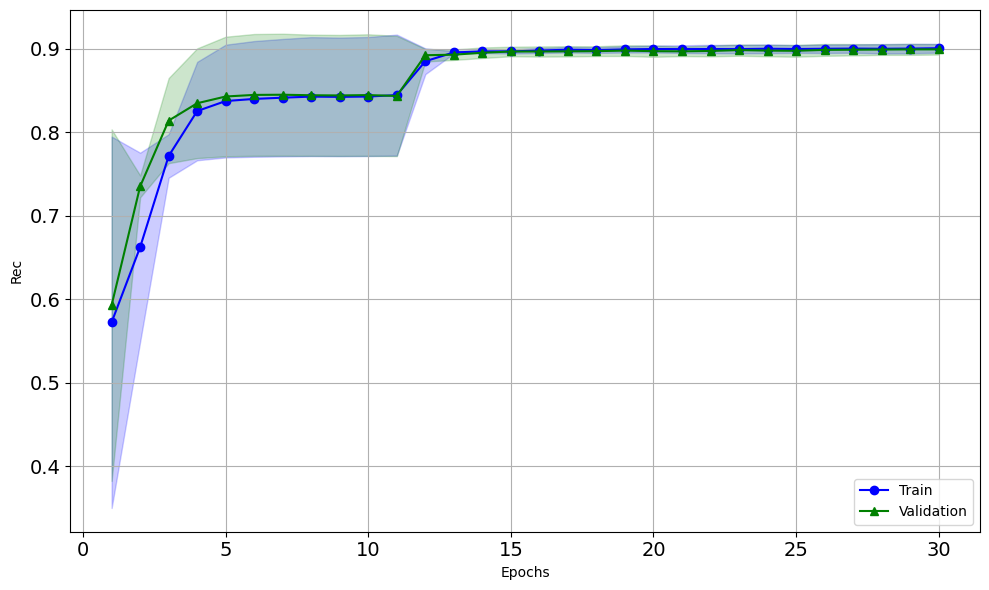

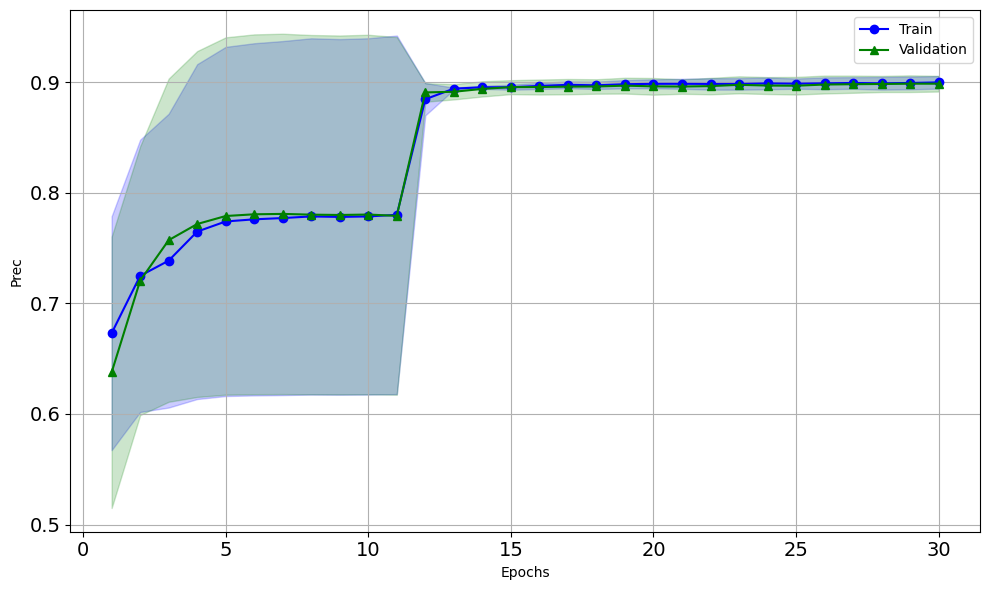

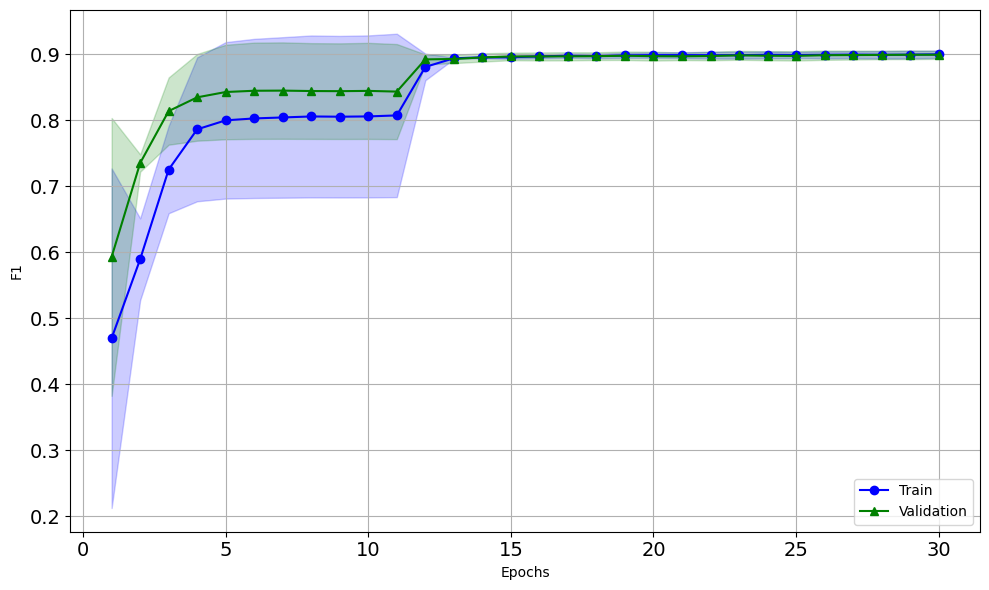

In [249]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range, classical=True, save_name=f"mean_{metric}_curve")
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [250]:
# c_train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }
# c_val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     # train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
#     train_loss, train_acc, train_prec, train_rec, train_f1, c_train_report = train_v2(classical_model, train_loader, optimizer, criterion, device)
#     # val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, c_val_report, val_preds, val_probs, val_labels = evaluate_v2(classical_model, val_loader, criterion, device)

#     c_train_metrics["acc"].append(train_acc)
#     c_train_metrics["loss"].append(train_loss)
#     c_train_metrics["rec"].append(train_rec)
#     c_train_metrics["prec"].append(train_prec)
#     c_train_metrics["f1"].append(train_f1)
        
#     c_val_metrics["acc"].append(val_acc)
#     c_val_metrics["loss"].append(val_loss)
#     c_val_metrics["rec"].append(val_rec)
#     c_val_metrics["prec"].append(val_prec)
#     c_val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(classical_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth")


#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_train_metrics.json", "w") as f:
#     json.dump(c_train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_val_metrics.json", "w") as f:
#     json.dump(c_val_metrics, f, indent=4)
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

In [251]:
# epochs = range(1, len(c_train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [252]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 2 with val_f1 = 0.9057


In [253]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{best_fold}_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training: 100%|███████| 20/20 [00:00<00:00, 459.73it/s, loss=0.4547, acc=0.8510]

Test loss: 0.4547 | Test acc: 0.8510 | Test rec: 0.8510 | Test prec: 0.8516 | Test f1: 0.8510


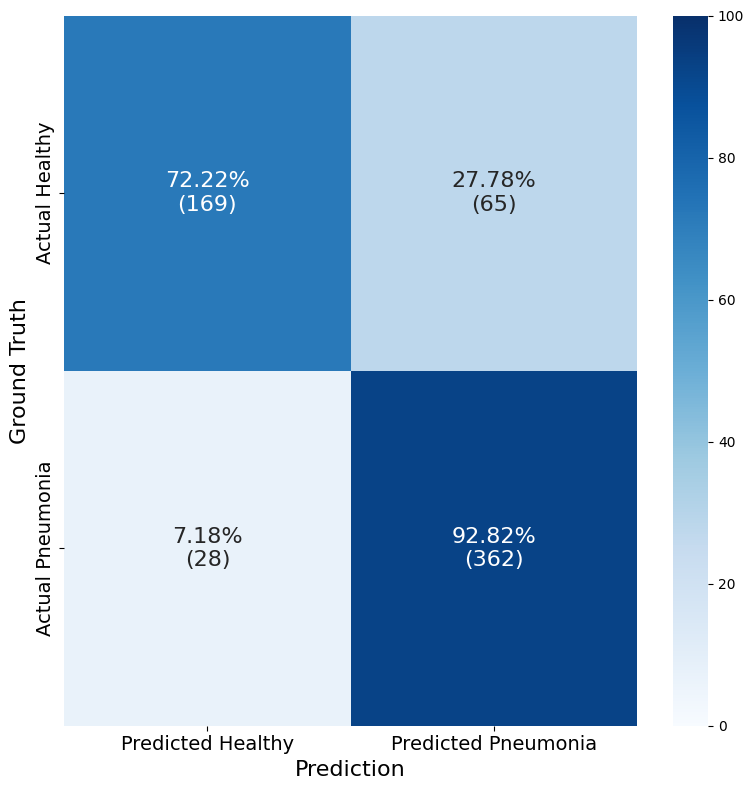

In [254]:
cm = confusion_matrix(test_labels, test_preds)

#normalize by row (for recall percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#normalize by entire sum of dataset
# cm_normalized = cm.astype('float') / cm.sum()

annot = np.empty_like(cm).astype(str)
n_classes = cm.shape[0]

for i in range(n_classes):
    for j in range(n_classes):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{percent:.2f}%\n({count})"

plt.figure(figsize=(8, 8))

sns.heatmap(cm_normalized, annot=annot, fmt="", cmap="Blues",
            vmin=0, vmax=100,
            xticklabels=[f"Predicted {lbl}" for lbl in labels],
            yticklabels=[f"Actual {lbl}" for lbl in labels],
           annot_kws={"size":16}
           )

plt.ylabel("Ground Truth", fontsize=16)
plt.xlabel("Prediction", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-cm", dpi=300)
plt.show()

AUROC: 0.9253342099495946


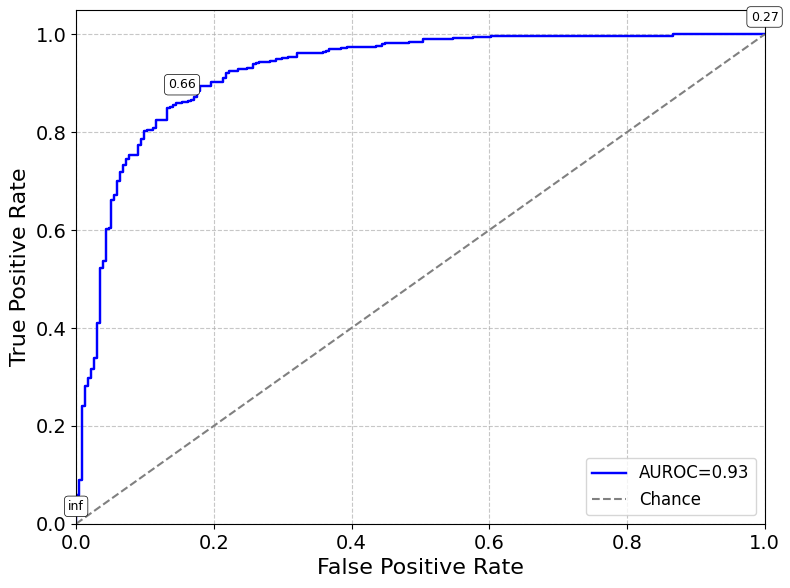

In [282]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

fpr, tpr, thresholds = roc_curve(all_labels_np, all_probs_np[:,1])
roc_auc = auc(fpr, tpr)

print("AUROC:", roc_auc)

fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(fpr, tpr, color="blue", lw=1.75, label=f"AUROC={roc_auc:.2f}")
ax.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance", lw=1.5)


for i in [0, len(thresholds) //2, len(thresholds)-1]:
    ax.annotate(f"{thresholds[i]:.2f}",
                (fpr[i], tpr[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha="center",
                fontsize=9,
                color="black",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
               )


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(loc="lower right", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()


plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-auroc", dpi=300)
plt.show()

# auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
# print("AUROC:", auroc)

# RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
# plt.grid()
# plt.show()

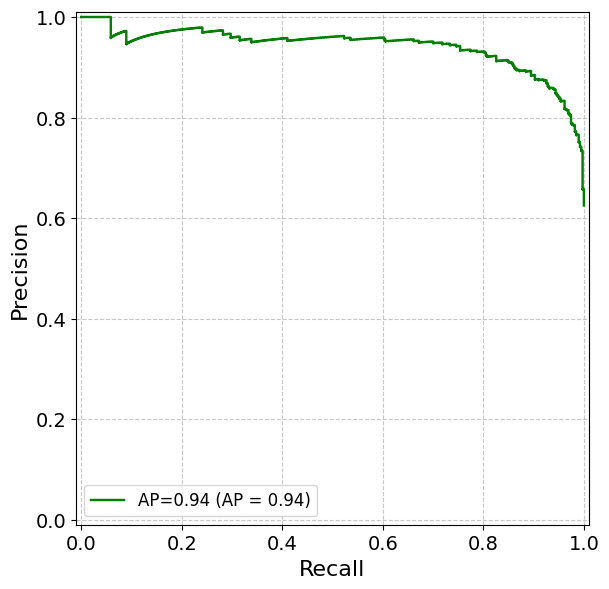

In [283]:
y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=pr_auc
)

disp.plot(ax=ax, lw=1.75, color="green", name=f"AP={pr_auc:.2f}")

ax.set_xlabel("Recall", fontsize=16)
ax.set_ylabel("Precision", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(loc="lower left", fontsize=12)

plt.tight_layout()


plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-precision_recall_curve", dpi=300)
plt.show()

In [284]:
cam, outputs, predictions = gradcam_model(test_classical_model, samples, quantum=False)
print(cam.shape)

torch.Size([16, 4])


In [285]:
print(cam)

tensor([[ 0.7623, -0.1328, -0.1763,  0.0126],
        [ 1.1318, -0.1972, -0.2617,  0.0187],
        [ 1.4972, -0.2608, -0.3462,  0.0247],
        [ 1.3425, -0.2339, -0.3104,  0.0221],
        [ 0.8225, -0.1433, -0.1902,  0.0136],
        [ 0.9458, -0.1648, -0.2187,  0.0156],
        [ 1.0837, -0.1888, -0.2506,  0.0179],
        [ 1.1817, -0.2059, -0.2732,  0.0195],
        [ 0.8410, -0.1465, -0.1945,  0.0139],
        [ 1.2005, -0.2092, -0.2776,  0.0198],
        [ 0.6734, -0.1173, -0.1557,  0.0111],
        [ 0.8314, -0.1448, -0.1922,  0.0137],
        [ 1.4044, -0.2447, -0.3247,  0.0232],
        [ 0.8567, -0.1493, -0.1981,  0.0141],
        [ 0.7682, -0.1338, -0.1776,  0.0127],
        [ 1.1807, -0.2057, -0.2730,  0.0195]])


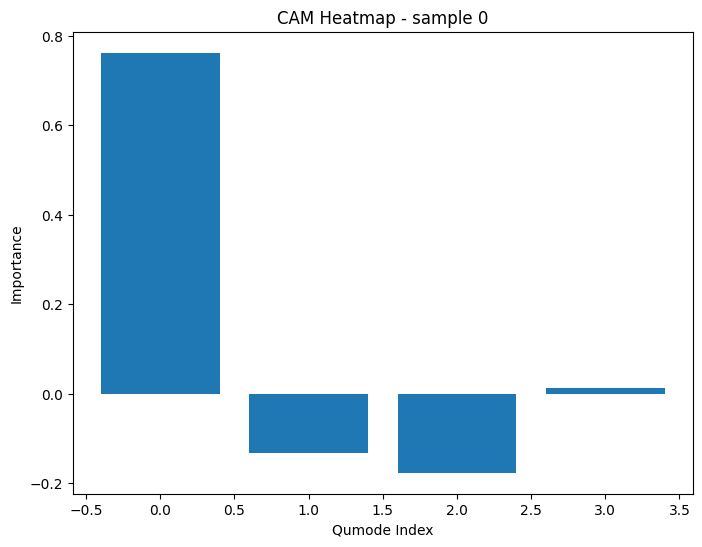

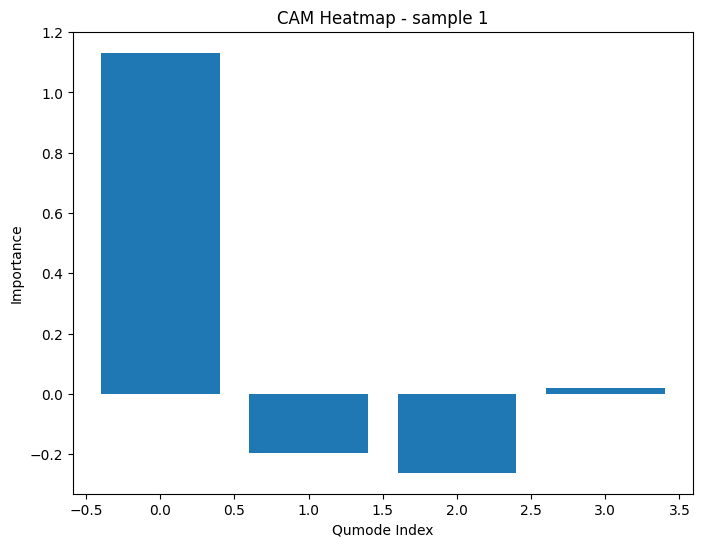

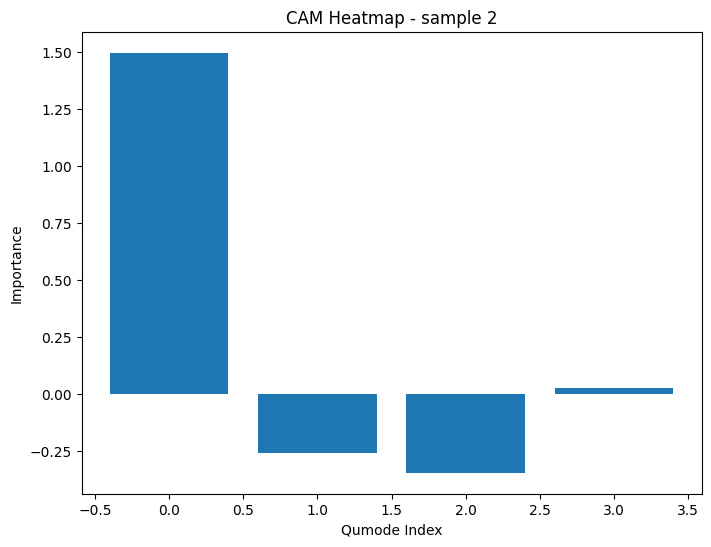

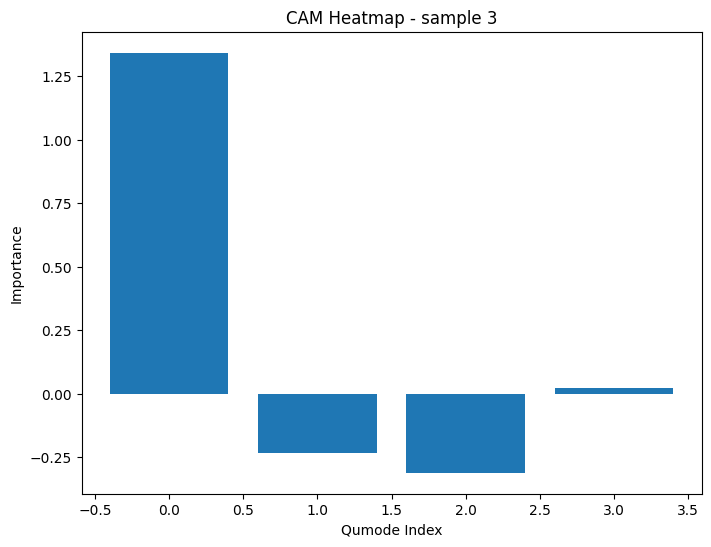

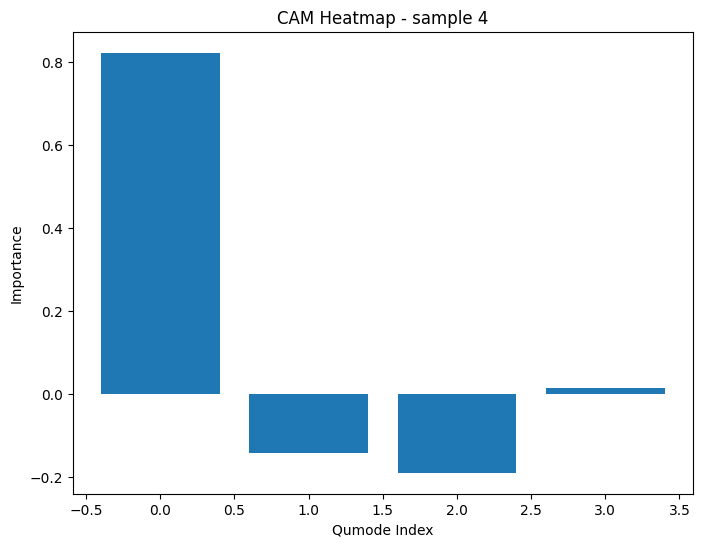

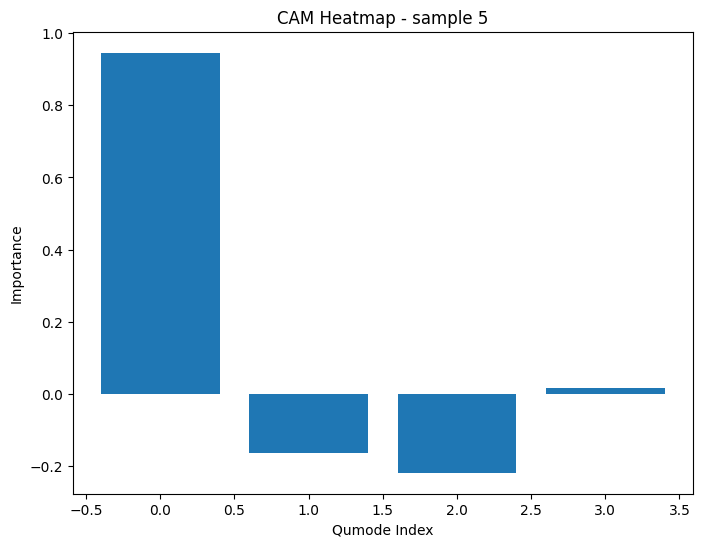

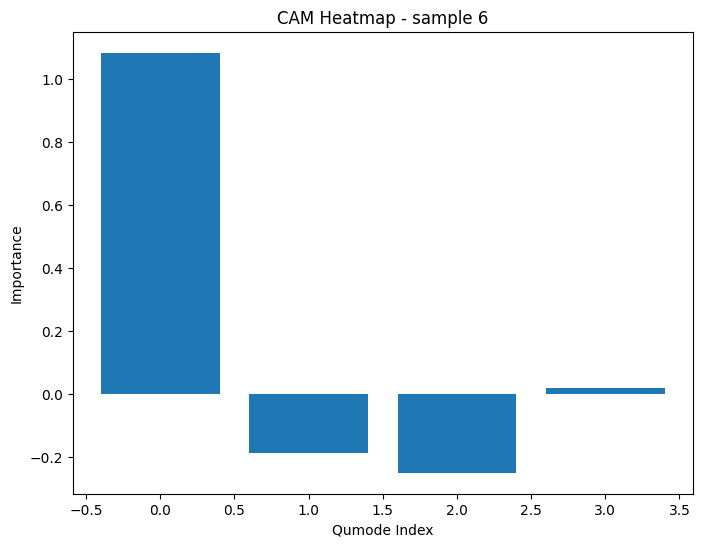

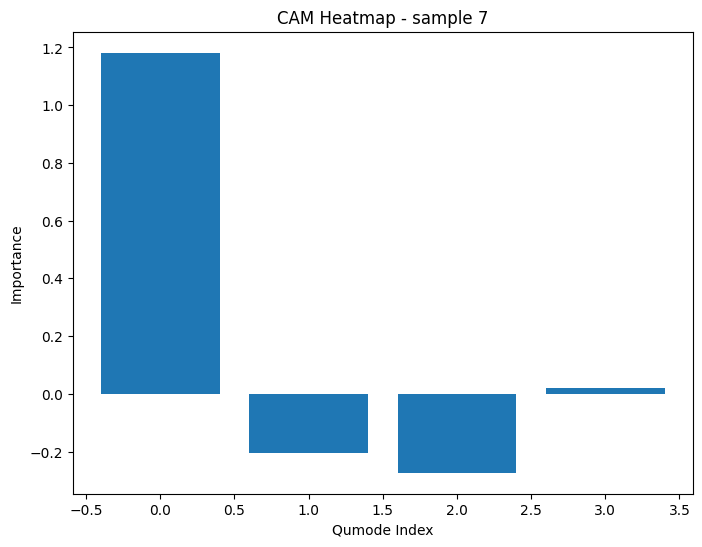

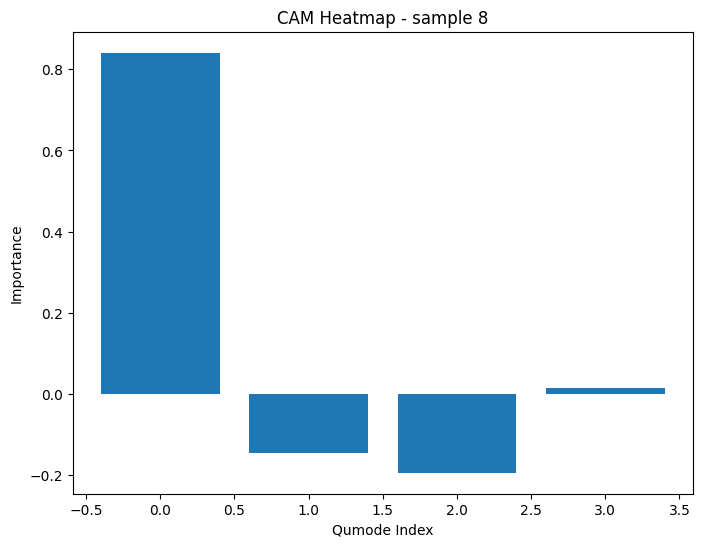

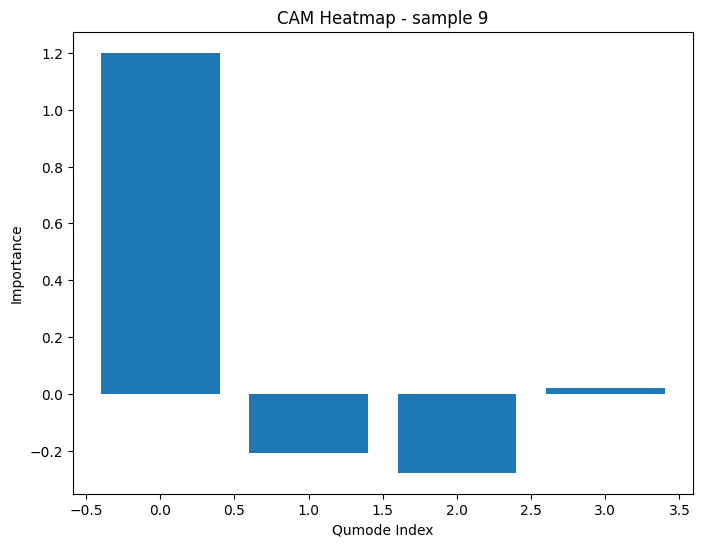

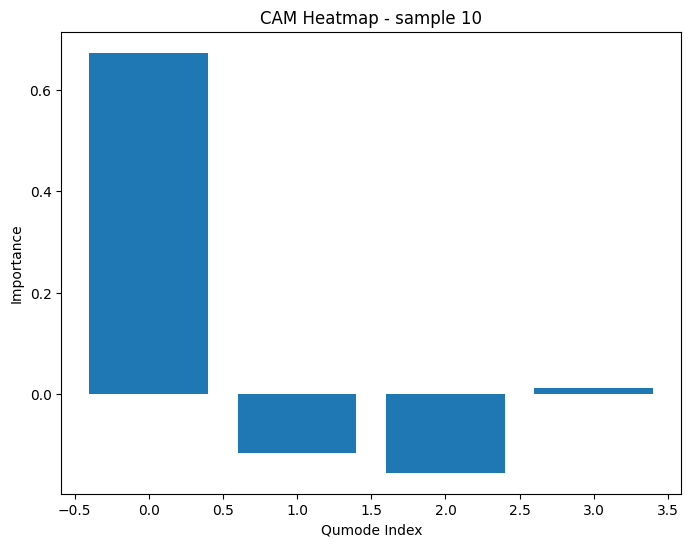

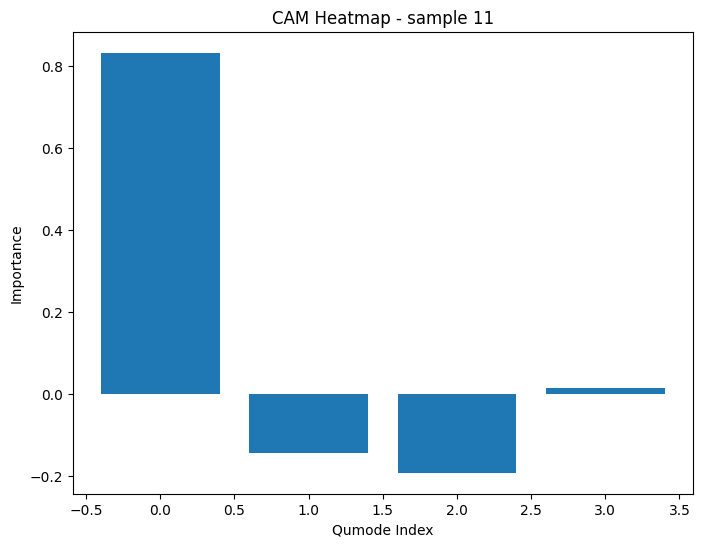

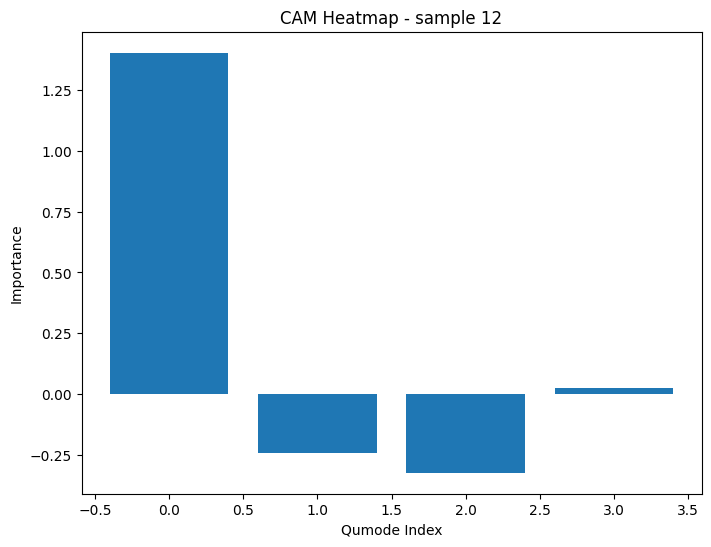

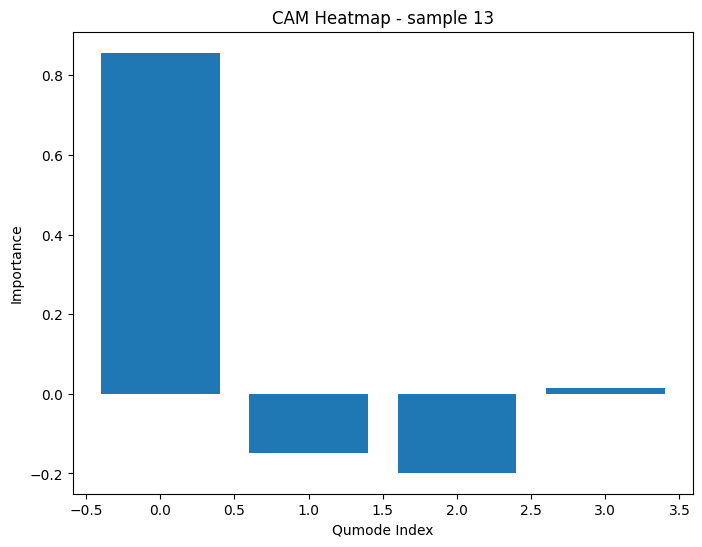

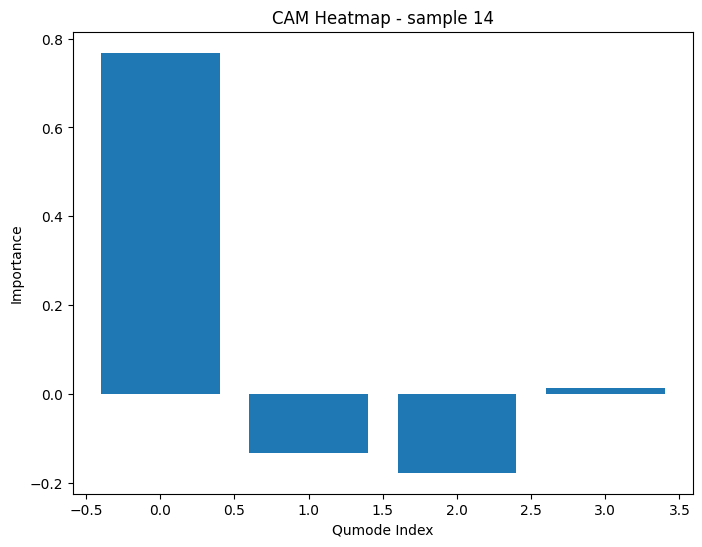

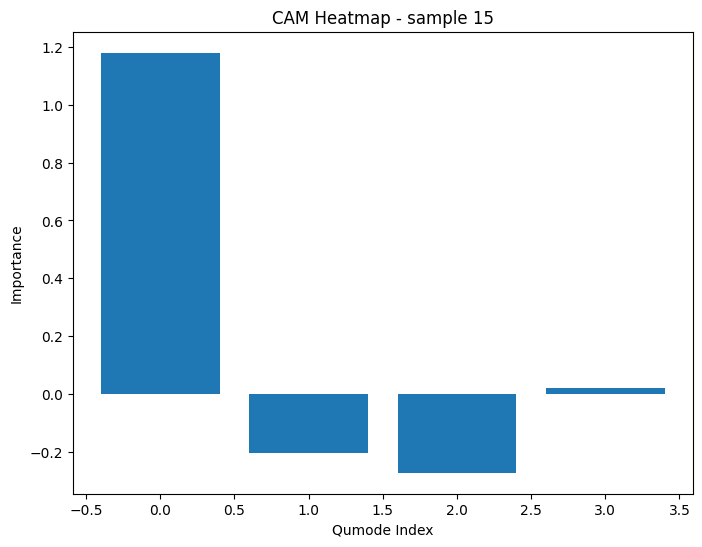

In [286]:
# plot_cam(cam)

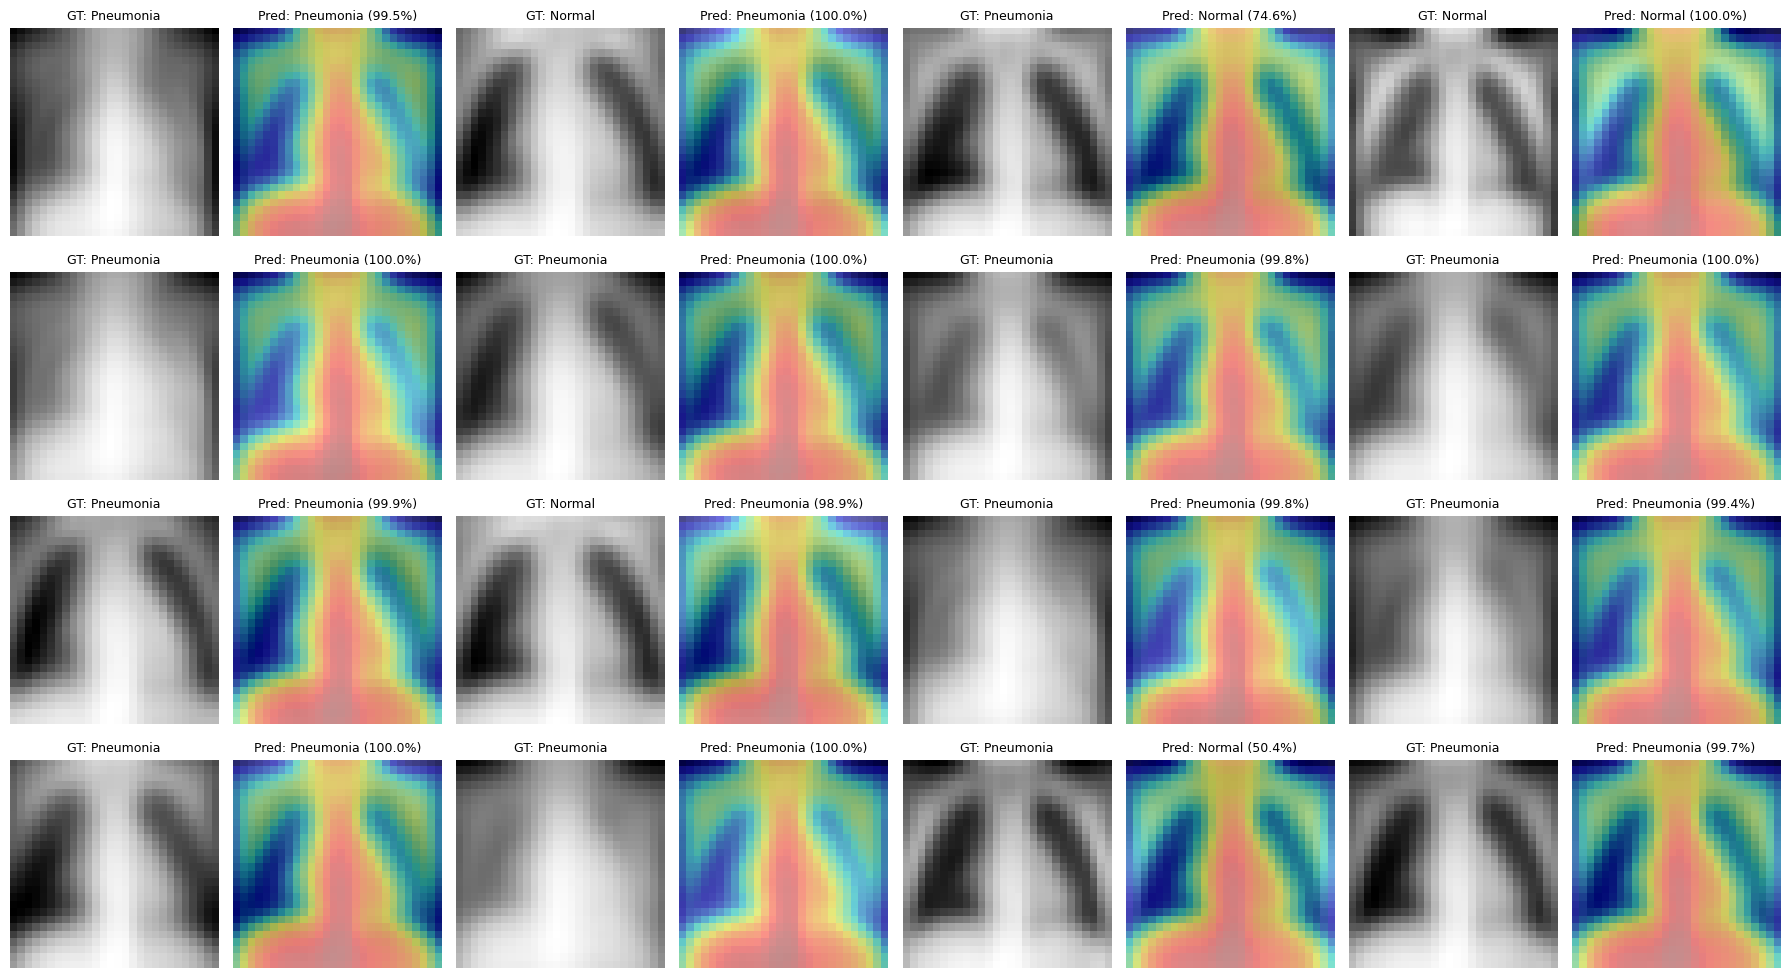

In [287]:
plot_reconstructed_heatmaps_with_predictions(
    samples=samples,
    cam=cam,
    preds=predictions,
    probs=outputs,
    labels=y_sample_labels,
    encoder=encoder,
    class_names=["Normal", "Pneumonia"]
)

## DISCRETE VARIABLE MODEL

In [257]:
## discrete variable circuit

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def dv_qcnn(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    for i in range(n_qubits):
        qml.RZ(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)


    qml.CNOT(wires=[0, 1])

    for i in range(n_qubits):
        qml.RZ(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)

    qml.CNOT(wires=[0,1])

    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    

In [258]:
dummy_inputs = torch.zeros(n_qubits)
dummy_weights = torch.zeros((2, n_qubits, 4))

drawer = qml.draw(dv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──RY(0.00)──RZ(0.00)──RY(0.00)─╭●─────────RZ(0.00)──RY(0.00)─╭●─┤  <Z>
1: ──RY(0.00)──RZ(0.00)──RY(0.00)─╰X─────────RZ(0.00)──RY(0.00)─╰X─┤  <Z>
2: ──RY(0.00)──RZ(0.00)──RY(0.00)──RZ(0.00)──RY(0.00)──────────────┤  <Z>
3: ──RY(0.00)──RZ(0.00)──RY(0.00)──RZ(0.00)──RY(0.00)──────────────┤  <Z>


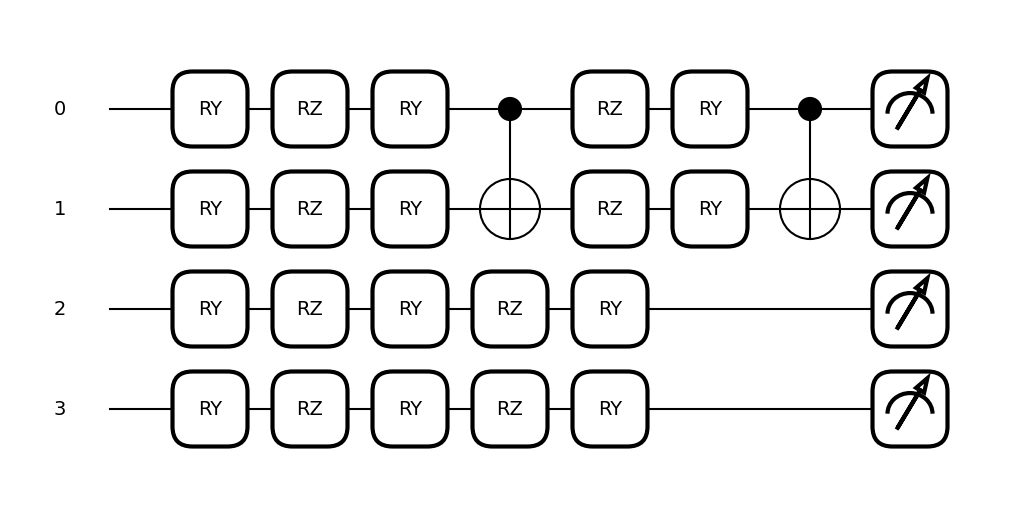

In [259]:
fig, ax = draw_mpl(dv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [260]:
class DVQuantumLinear(nn.Module):
    def __init__(self, n_qubits=4, n_classes=2):
        super().__init__()

        weight_shapes = {"weights": (2, n_qubits, 4)}

        qnode = qml.QNode(dv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)

        self.head = nn.Sequential(
            nn.Linear(n_qubits, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [261]:
epochs = 30
device = "cpu"
dv_model = DVQuantumLinear(n_qubits=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(dv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [262]:
from torchinfo import summary
summary(dv_model)

Layer (type:depth-idx)                   Param #
DVQuantumLinear                          --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
│    └─Softmax: 2-2                      --
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [263]:
dv_model.train()
for name, param in dv_model.named_parameters():
    print(f"{name} grad:", param.grad)
    print(f"{name} grad:, requires_grad={param.requires_grad}")

quantum.weights grad: None
quantum.weights grad:, requires_grad=True
head.0.weight grad: None
head.0.weight grad:, requires_grad=True
head.0.bias grad: None
head.0.bias grad:, requires_grad=True


In [264]:
dv_quantum_weights = list(dv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[ 2.4893427   3.948044    3.42253     1.2792612 ]
  [ 3.6252806   2.702754    0.72365284  4.2781963 ]
  [ 4.0886536   2.8590753   0.2866945   2.9777007 ]
  [-0.33921883  3.8538132   5.2053204   6.157867  ]]

 [[ 5.186942    4.6682777   3.1919923   4.4442053 ]
  [ 0.32417852  2.4249759   0.02452534  5.4812317 ]
  [ 1.573187    2.9794948   1.5241549   5.2115493 ]
  [ 3.6271465   2.7267423   1.6596003   4.6878304 ]]]


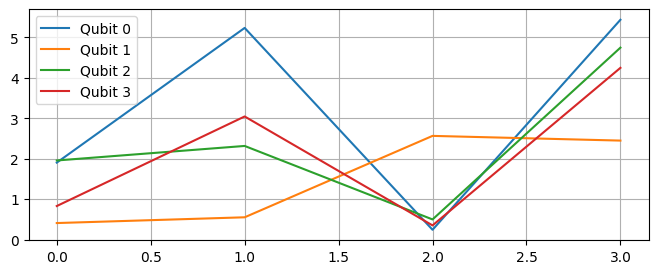

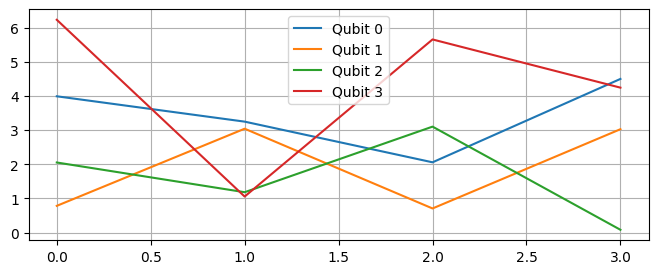

In [265]:
for layer in range(dv_quantum_weights.shape[0]):
    plt.figure(figsize=(8,3))
    for qubit in range(dv_quantum_weights.shape[1]):
        plt.plot(dv_quantum_weights[layer, qubit], label=f"Qubit {qubit}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [266]:
model_name = "dv-linear"

In [ ]:
run_kfold_training(DVQuantumLinear, train_dataset, optimizer, criterion, model_name, classical=False, k=3, num_epochs=epochs, seed=42)

In [267]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}
model_name = "dv-linear"


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

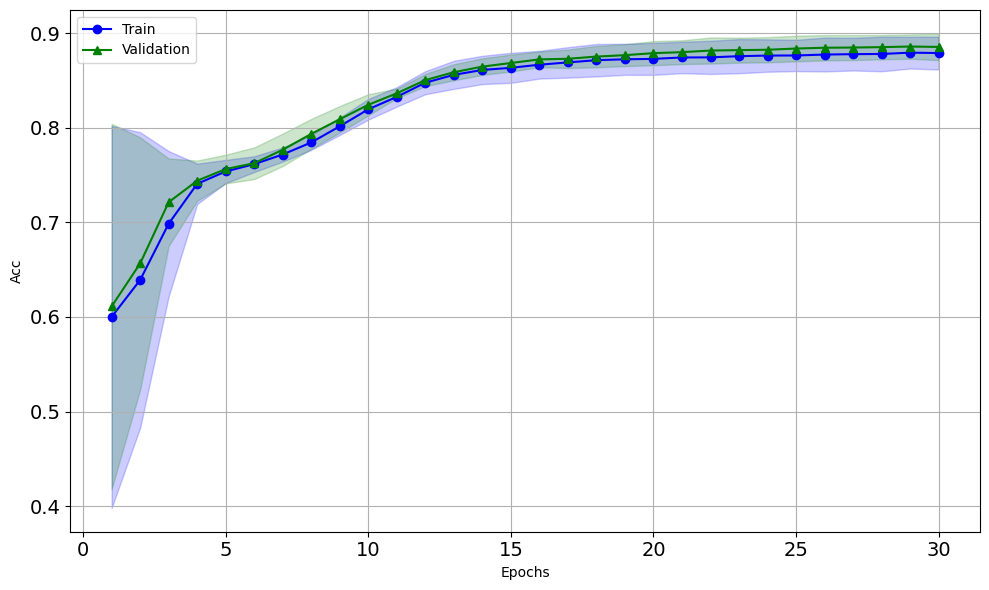

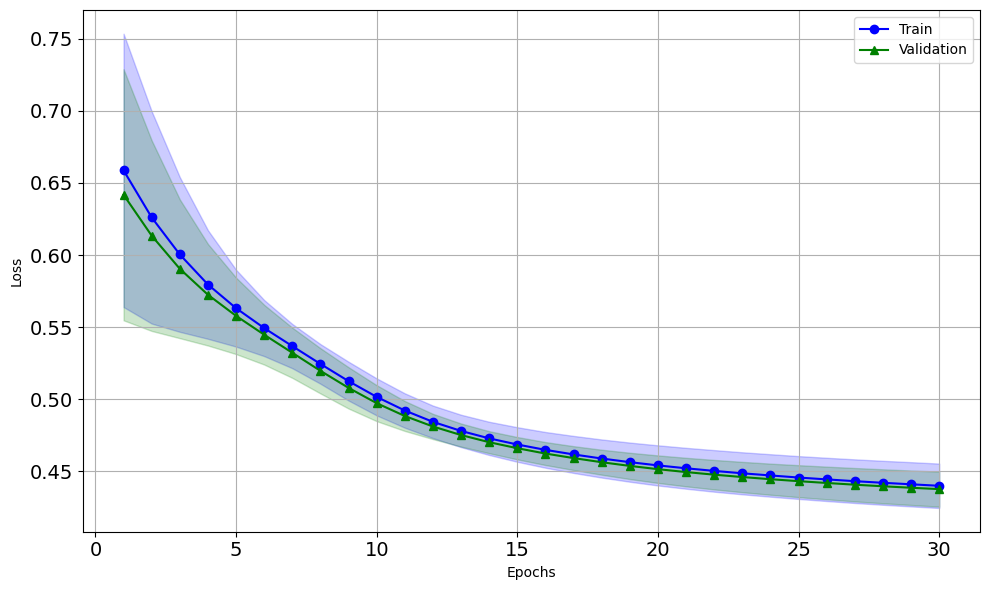

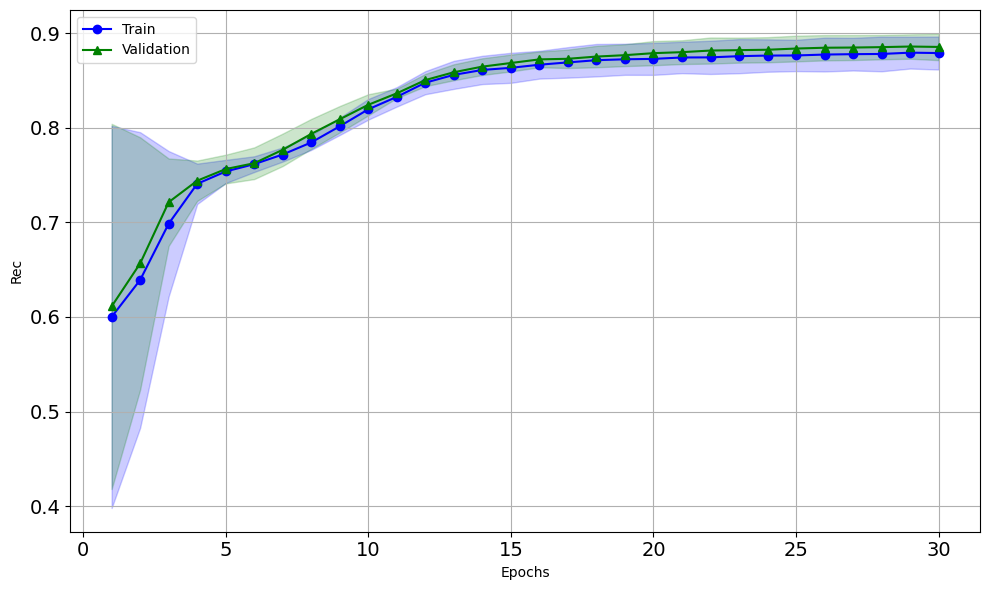

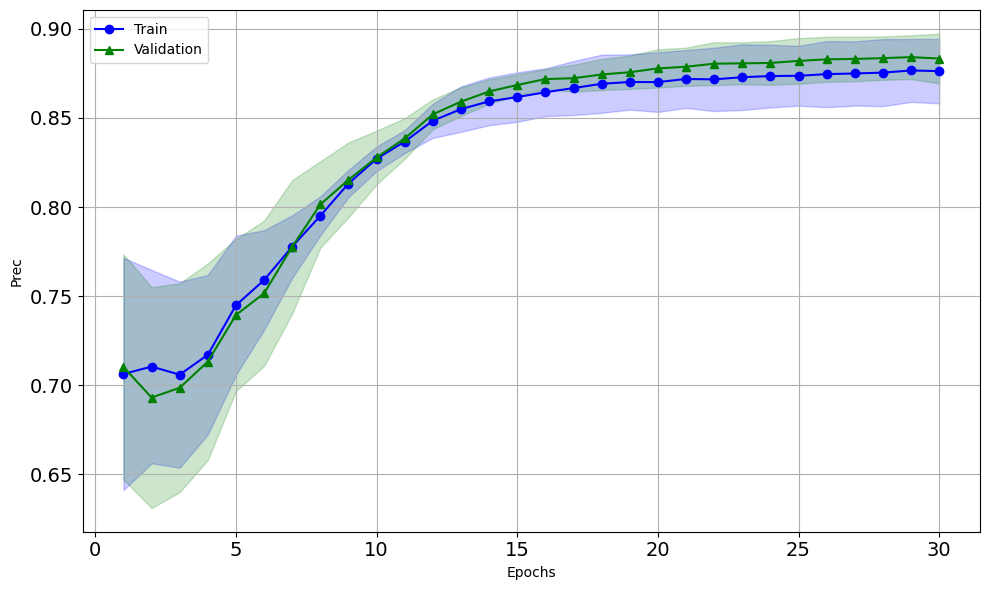

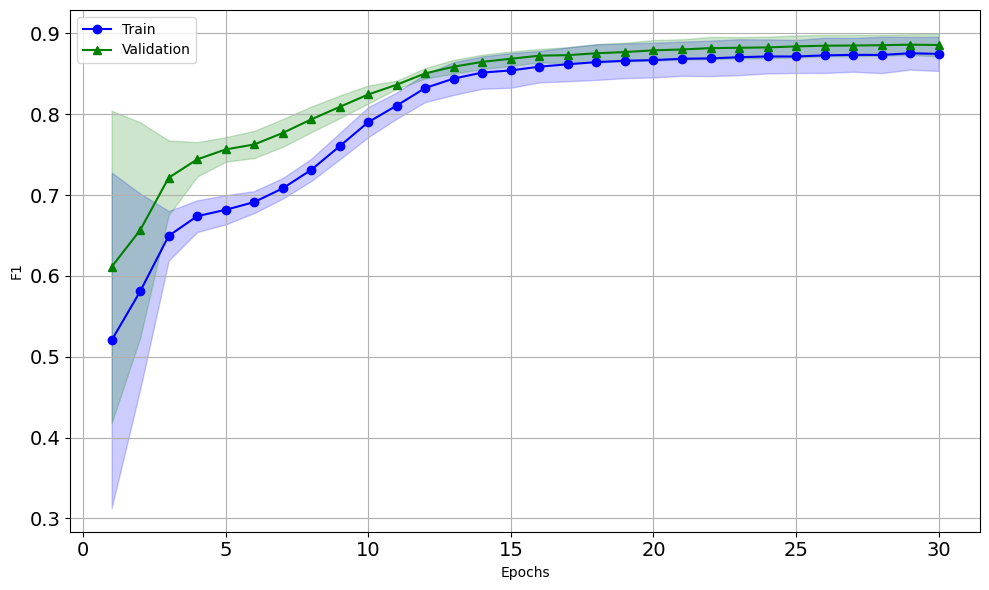

In [268]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/cv_{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [269]:


best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")



Best fold: 2 with val_f1 = 0.8987


In [270]:
device = "cpu"
# test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
# test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)
test_dv_model = DVQuantumLinear(4, 2).to(device)

# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{best_fold}_best.pth"))
test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_dv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/cv_{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████| 20/20 [00:02<00:00,  7.39it/s, loss=0.4598, acc=0.8574]

Test loss: 0.4598 | Test acc: 0.8574 | Test rec: 0.8574 | Test prec: 0.8612 | Test f1: 0.8574


In [271]:
for name, param in test_dv_model.quantum.named_parameters():
    print(name, param.data)

weights tensor([[[2.1374, 6.9850, 4.9034, 1.6898],
         [1.7443, 6.9378, 4.5833, 4.9970],
         [1.5876, 7.2262, 0.1996, 4.6012],
         [2.1623, 5.4705, 2.0316, 5.8510]],

        [[1.7138, 3.1490, 0.9471, 2.0019],
         [5.0387, 0.5672, 2.8065, 5.8165],
         [3.9310, 3.4097, 4.6067, 3.6758],
         [2.9235, 3.9556, 5.4309, 6.1037]]])


In [272]:
quantum_weights = list(test_dv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[2.137396   6.984984   4.9034033  1.6898282 ]
  [1.7443447  6.9378147  4.5833254  4.9970293 ]
  [1.5876483  7.2261643  0.19956245 4.6011963 ]
  [2.1622934  5.4705243  2.031579   5.8509765 ]]

 [[1.7138323  3.1489608  0.9470504  2.001941  ]
  [5.0386767  0.5672478  2.8064816  5.8164997 ]
  [3.9309933  3.4097168  4.6066813  3.6758196 ]
  [2.923491   3.9556286  5.4309316  6.103694  ]]]


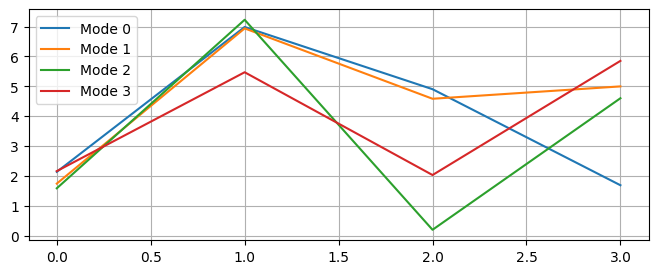

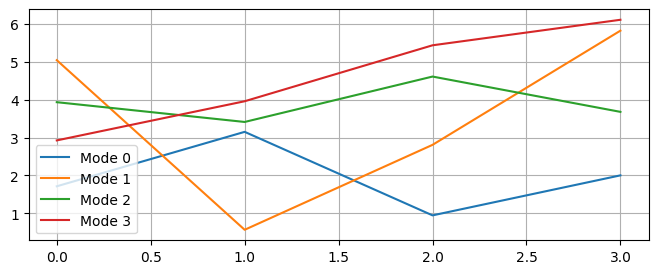

In [273]:
for layer in range(quantum_weights.shape[0]):
    plt.figure(figsize=(8, 3))
    for qubit in range(quantum_weights.shape[1]):
        plt.plot(quantum_weights[layer, qubit], label=f"Qubit {qubit}")
    plt.legend()
    plt.grid(True)
    plt.show()



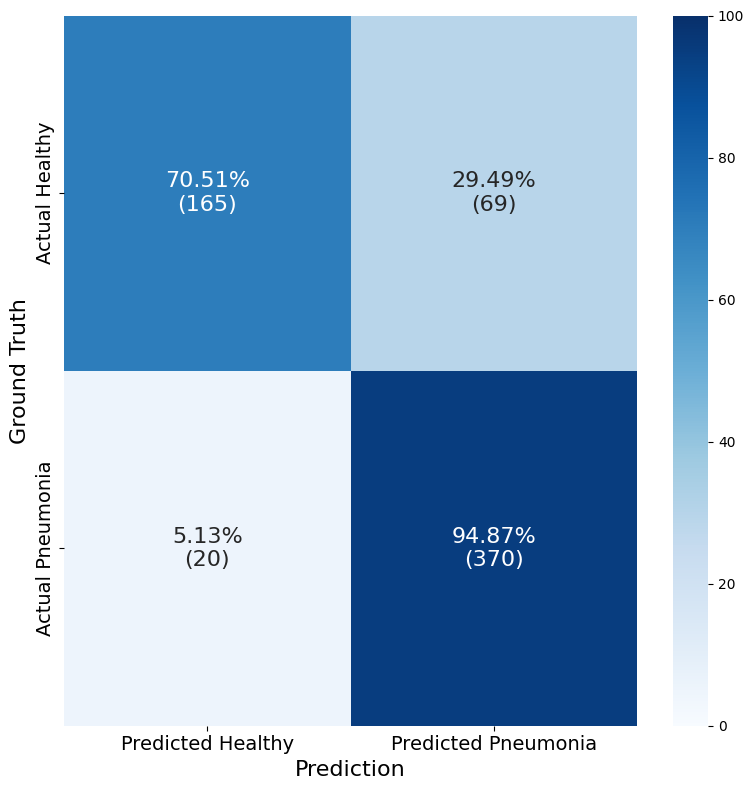

In [274]:
cm = confusion_matrix(test_labels, test_preds)

#normalize by row (for recall percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#normalize by entire sum of dataset
# cm_normalized = cm.astype('float') / cm.sum()

annot = np.empty_like(cm).astype(str)
n_classes = cm.shape[0]

for i in range(n_classes):
    for j in range(n_classes):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{percent:.2f}%\n({count})"

plt.figure(figsize=(8, 8))

sns.heatmap(cm_normalized, annot=annot, fmt="", cmap="Blues",
            vmin=0, vmax=100,
            xticklabels=[f"Predicted {lbl}" for lbl in labels],
            yticklabels=[f"Actual {lbl}" for lbl in labels],
           annot_kws={"size":16}
           )

plt.ylabel("Ground Truth", fontsize=16)
plt.xlabel("Prediction", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()


plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cm", dpi=300)
plt.show()

AUROC: 0.9253342099495946


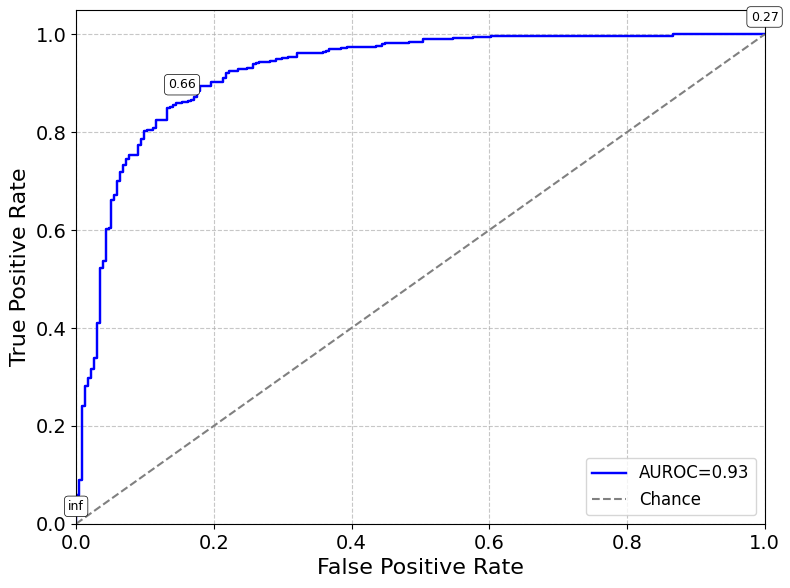

In [276]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

fpr, tpr, thresholds = roc_curve(all_labels_np, all_probs_np[:,1])
roc_auc = auc(fpr, tpr)

print("AUROC:", roc_auc)

fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(fpr, tpr, color="blue", lw=1.75, label=f"AUROC={roc_auc:.2f}")
ax.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance", lw=1.5)


for i in [0, len(thresholds) //2, len(thresholds)-1]:
    ax.annotate(f"{thresholds[i]:.2f}",
                (fpr[i], tpr[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha="center",
                fontsize=9,
                color="black",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
               )


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(loc="lower right", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()


plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cv-auroc", dpi=300)
plt.show()

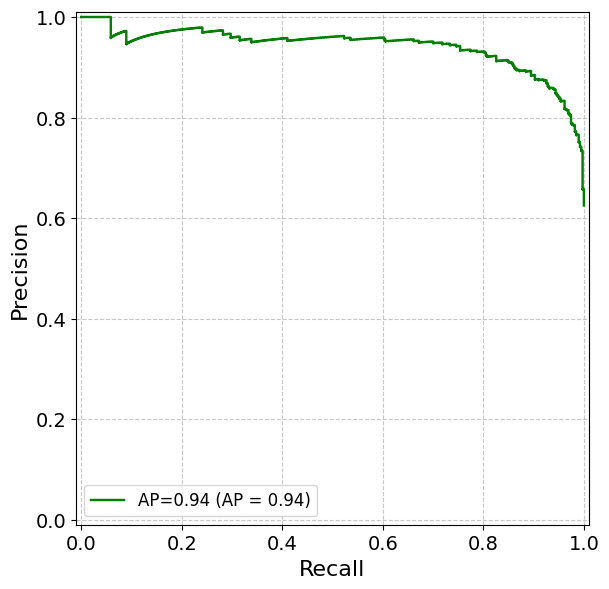

In [277]:
y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=pr_auc
)

disp.plot(ax=ax, lw=1.75, color="green", name=f"AP={pr_auc:.2f}")

ax.set_xlabel("Recall", fontsize=16)
ax.set_ylabel("Precision", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(loc="lower left", fontsize=12)

plt.tight_layout()

plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-precision_recall_curve", dpi=300)
plt.show()


In [278]:
cam, outputs, predictions = gradcam_model(test_dv_model, samples, quantum=True)
print(cam.shape)

torch.Size([16, 4])


In [279]:
print(cam)

tensor([[ 3.9794e-02,  8.4203e-02,  1.5259e-02,  1.0746e-01],
        [ 1.0410e-01,  9.2757e-02,  1.0560e-01,  1.1227e-01],
        [ 1.5605e+00, -9.6740e-01,  1.7995e+00, -1.8288e-01],
        [ 2.7248e-01, -6.1803e-01, -5.6782e-01,  4.3912e-01],
        [ 8.4219e-02,  9.9208e-02, -4.6763e-02,  1.2220e-01],
        [ 9.0899e-02,  9.7346e-02,  5.8302e-02,  1.0095e-01],
        [ 1.9519e-01,  1.5989e-01, -5.7872e-02,  2.0430e-01],
        [ 8.8834e-02,  1.2021e-01,  2.1737e-02,  1.3564e-01],
        [ 4.8308e-02,  7.1404e-02,  6.8757e-02,  5.9463e-02],
        [ 1.3701e+00,  3.0553e-01,  8.6707e-01,  8.8860e-01],
        [ 3.1568e-02,  6.5510e-02, -2.2523e-02,  6.9865e-02],
        [ 7.7359e-02,  1.0481e-01, -7.7842e-04,  1.4177e-01],
        [ 8.8484e-02,  8.9303e-02,  1.1583e-01,  1.2323e-01],
        [ 1.3605e-01,  1.4763e-01, -8.4971e-02,  1.6369e-01],
        [-8.6150e-01,  3.2248e-01,  1.1480e+00, -3.1026e+00],
        [ 4.4721e-01,  3.5529e-01,  2.9706e-01,  2.9971e-02]])


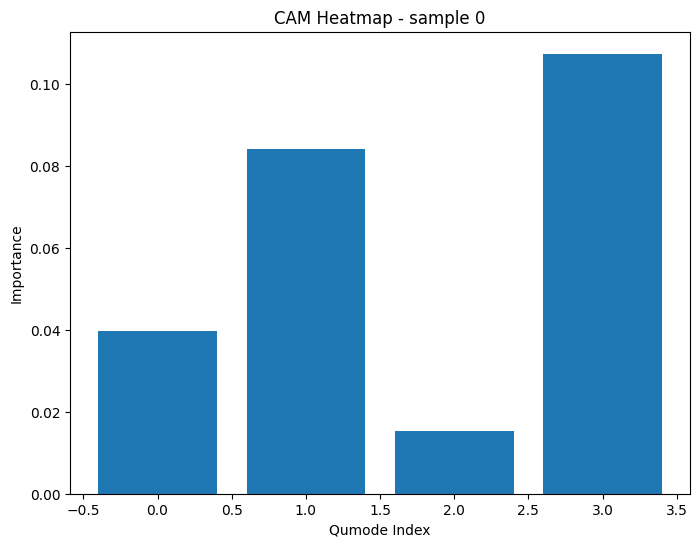

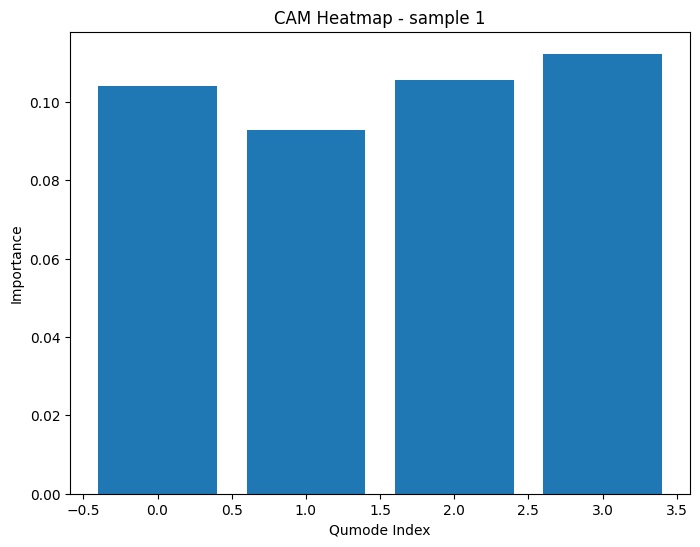

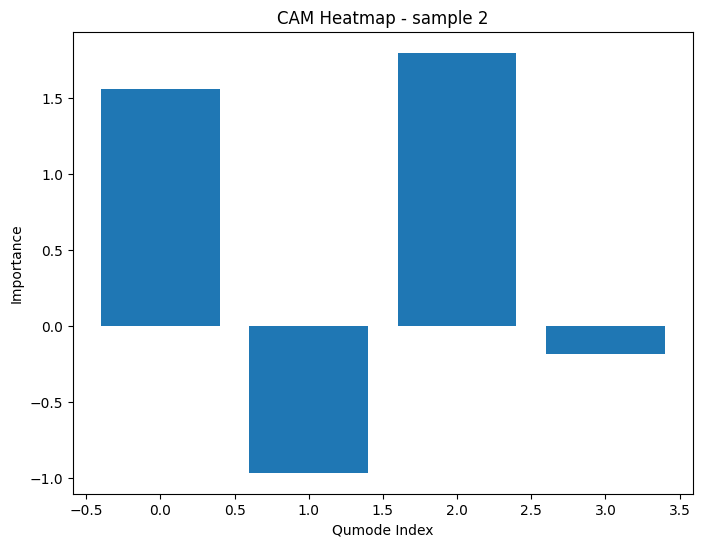

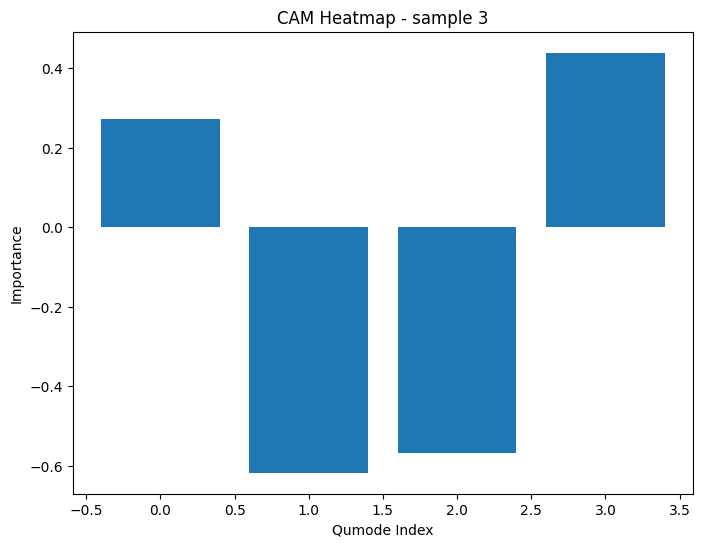

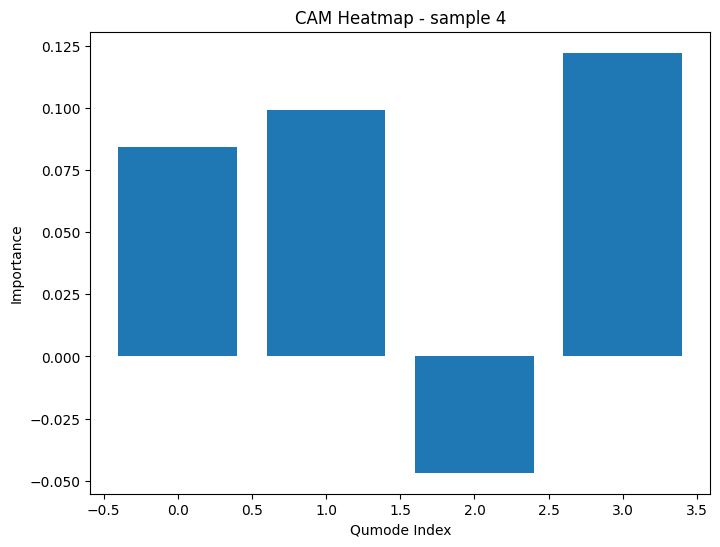

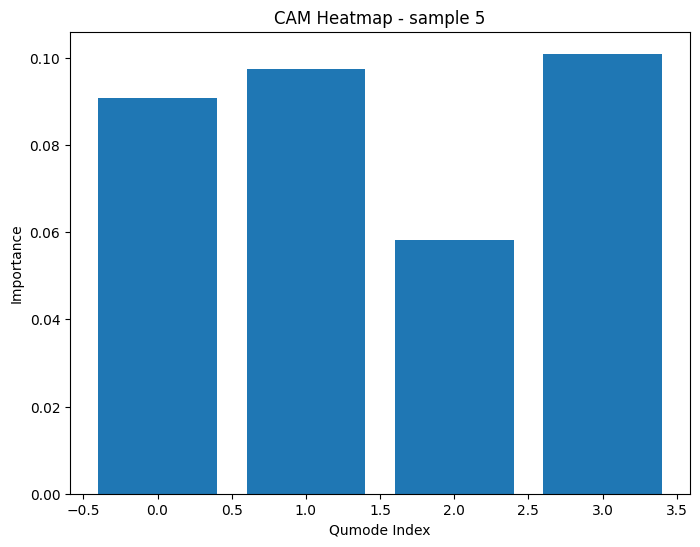

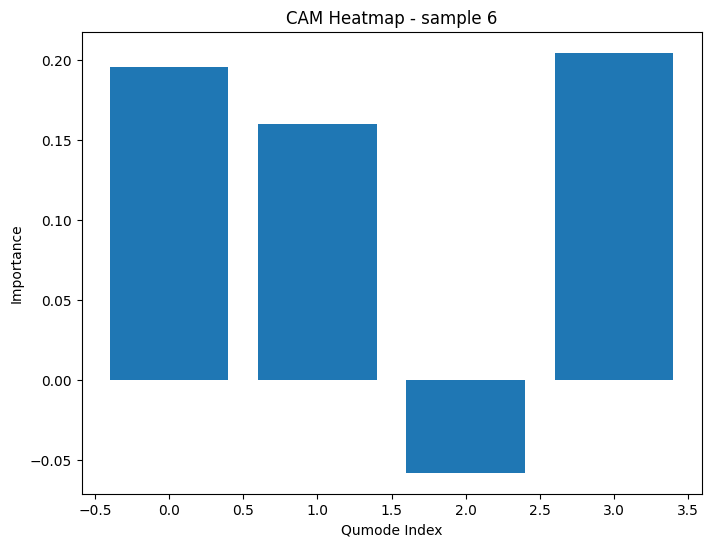

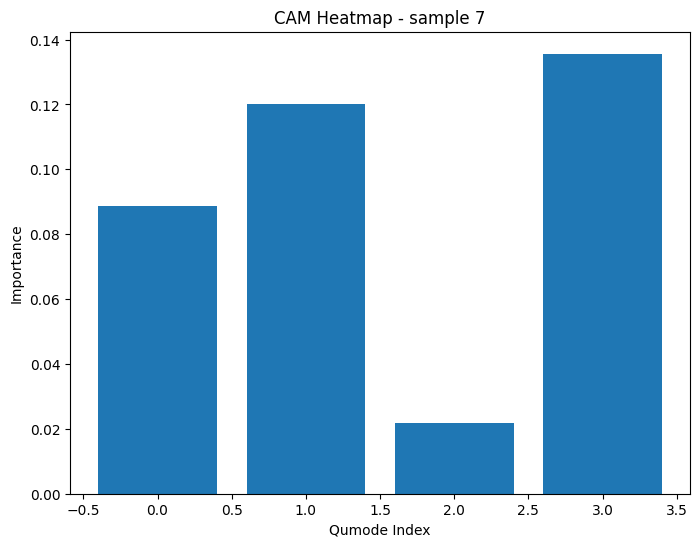

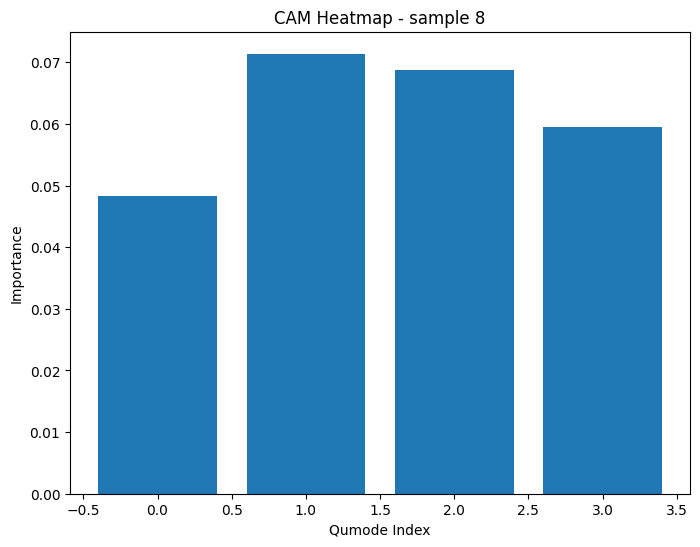

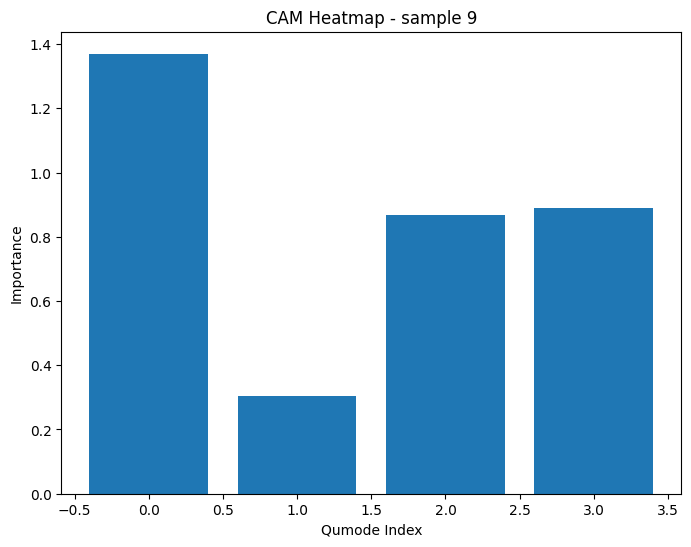

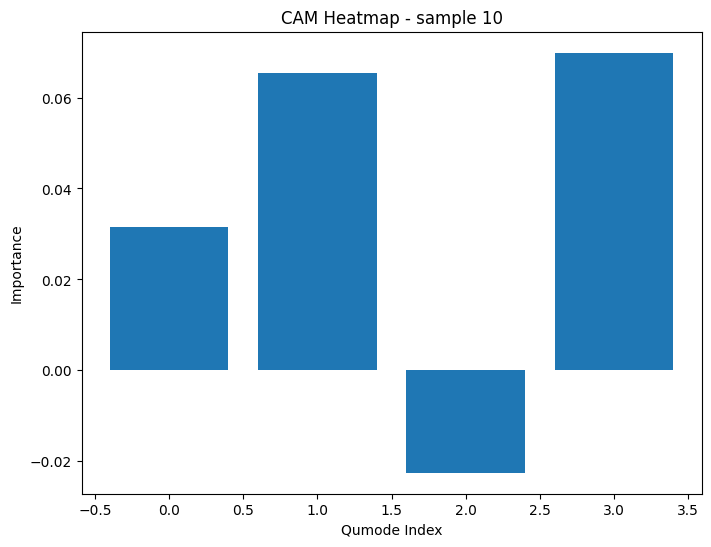

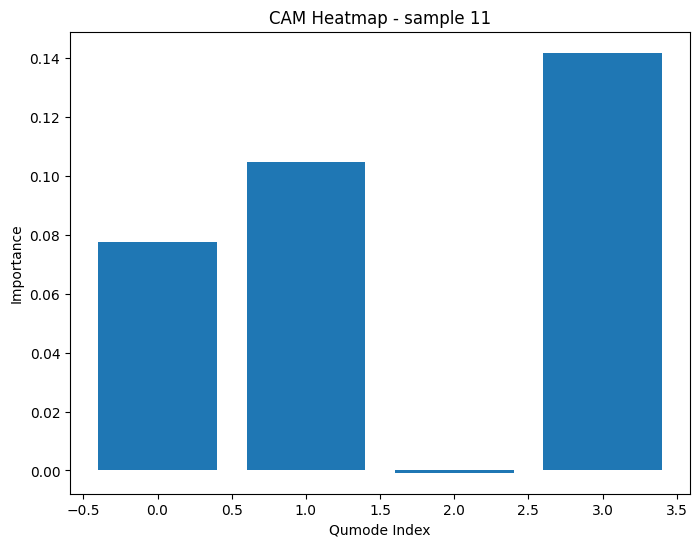

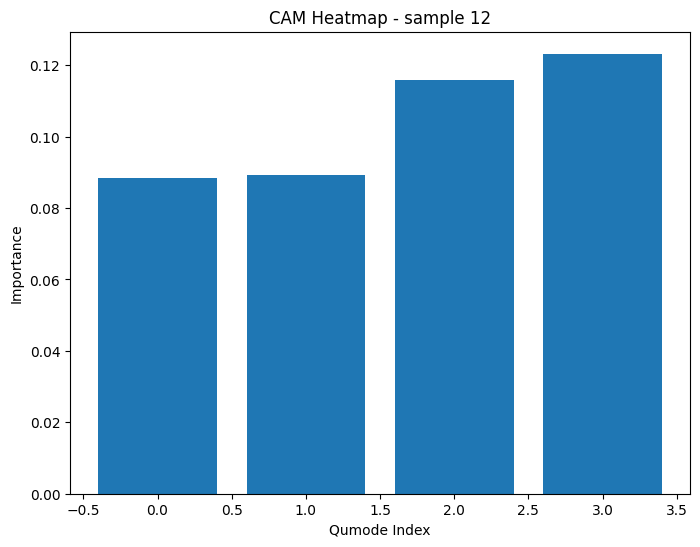

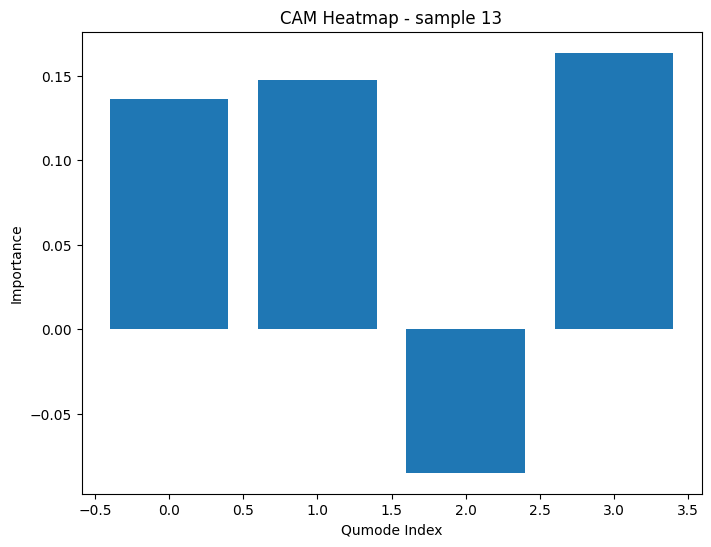

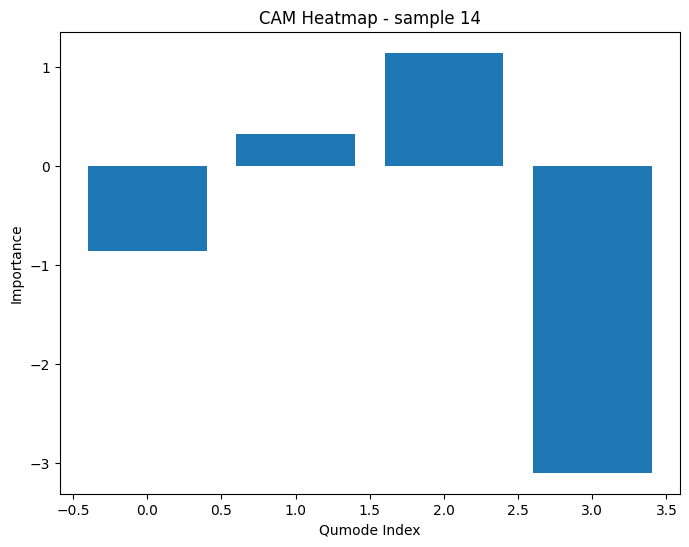

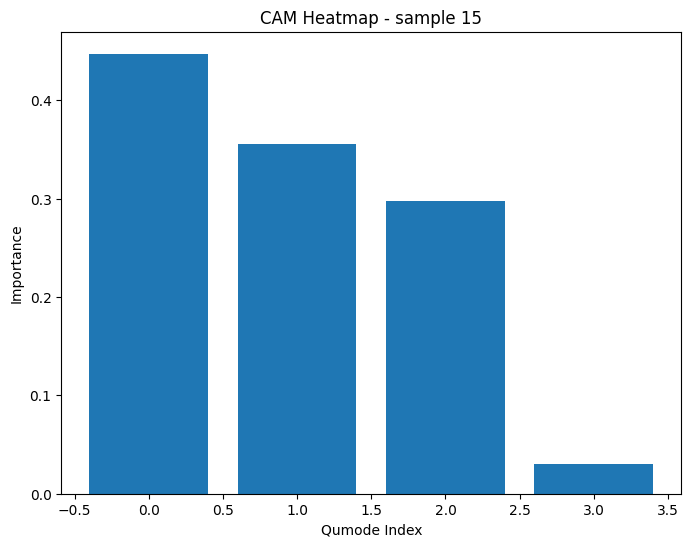

In [280]:
# plot_cam(cam)

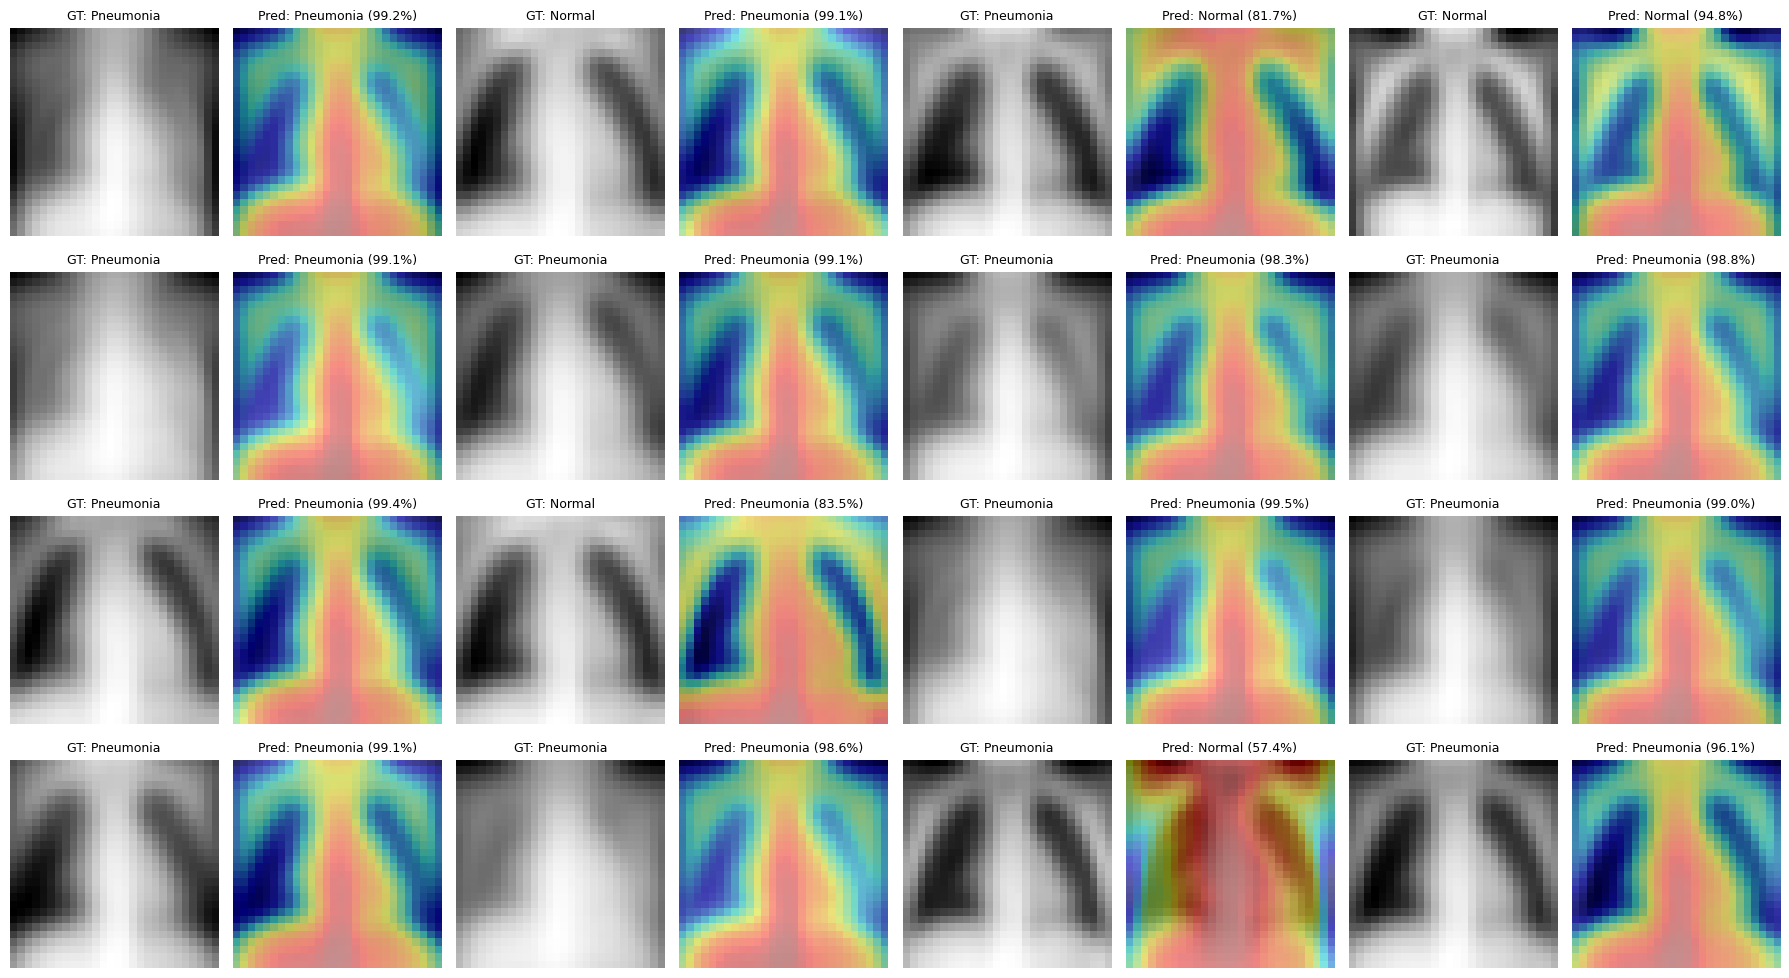

In [281]:
plot_reconstructed_heatmaps_with_predictions(
    samples=samples,
    cam=cam,
    preds=predictions,
    probs=outputs,
    labels=y_sample_labels,
    encoder=encoder,
    class_names=["Normal", "Pneumonia"]
)

## Model robustness comparison

In [298]:
cv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

classical_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}




In [299]:
cv_f1_scores = []
dv_f1_scores = []
classic_f1_scores = []

full_samples = []
full_labels = []

for x_batch, y_batch in test_loader:
    full_samples.append(x_batch)
    full_labels.append(y_batch)

full_samples = torch.cat(full_samples)
full_labels = torch.cat(full_labels)


for std in noise_std:
    
    # noisy_samples = (full_samples + torch.randn_like(full_samples) * std).clamp(0, 1).to(device)
    noisy_samples = (full_samples + torch.randn_like(full_samples) * std).to(device)
    full_labels = full_labels.to(device)
    print(f"[STD: {std:.2f}] Clean mean: {full_samples.mean().item():.4f}, Noisy mean: {noisy_samples.mean().item():.4f}")
    noisy_dataset = TensorDataset(noisy_samples, full_labels)
    noisy_loader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)
    
    _, cv_acc, cv_prec, cv_rec, cv_f1, _, _, _, _ = evaluate_v2(test_cv_model,
                                               noisy_loader,
                                              criterion,
                                              device)


    _, dv_acc, dv_prec, dv_rec, dv_f1, _, _, _, _ = evaluate_v2(test_dv_model,
                                           noisy_loader,
                                          criterion,
                                          device)



    _, classical_acc, classical_prec, classical_rec, classical_f1, _, _, _, _ = evaluate_v2(test_classical_model,
                                               noisy_loader,
                                              criterion,
                                              device)


    cv_noise_metrics["acc"].append(cv_acc)
    cv_noise_metrics["rec"].append(cv_rec)
    cv_noise_metrics["prec"].append(cv_prec)
    cv_noise_metrics["f1"].append(cv_f1)

    dv_noise_metrics["acc"].append(dv_acc)
    dv_noise_metrics["rec"].append(dv_rec)
    dv_noise_metrics["prec"].append(dv_prec)
    dv_noise_metrics["f1"].append(dv_f1)

    classical_noise_metrics["acc"].append(classical_acc)
    classical_noise_metrics["rec"].append(classical_rec)
    classical_noise_metrics["prec"].append(classical_prec)
    classical_noise_metrics["f1"].append(classical_f1)

    
    cv_f1_scores.append(cv_f1)
    dv_f1_scores.append(dv_f1)
    classic_f1_scores.append(classical_f1)

[STD: 0.10] Clean mean: 0.0186, Noisy mean: 0.0171


Training: 100%|███████| 20/20 [00:00<00:00, 506.75it/s, loss=0.4536, acc=0.8542]


[STD: 0.15] Clean mean: 0.0186, Noisy mean: 0.0224


Training: 100%|███████| 20/20 [00:00<00:00, 485.49it/s, loss=0.4616, acc=0.8397]


[STD: 0.20] Clean mean: 0.0186, Noisy mean: 0.0253


Training: 100%|███████| 20/20 [00:00<00:00, 499.66it/s, loss=0.4656, acc=0.8397]


[STD: 0.25] Clean mean: 0.0186, Noisy mean: 0.0109


Training: 100%|███████| 20/20 [00:00<00:00, 482.98it/s, loss=0.4610, acc=0.8510]


[STD: 0.30] Clean mean: 0.0186, Noisy mean: 0.0138


Training: 100%|███████| 20/20 [00:00<00:00, 555.27it/s, loss=0.4674, acc=0.8333]


[STD: 0.35] Clean mean: 0.0186, Noisy mean: 0.0197


Training: 100%|███████| 20/20 [00:00<00:00, 426.54it/s, loss=0.4781, acc=0.8269]


[STD: 0.40] Clean mean: 0.0186, Noisy mean: 0.0112


Training: 100%|███████| 20/20 [00:00<00:00, 469.98it/s, loss=0.4644, acc=0.8429]


[STD: 0.45] Clean mean: 0.0186, Noisy mean: 0.0011


Training: 100%|███████| 20/20 [00:00<00:00, 495.52it/s, loss=0.4876, acc=0.8253]


[STD: 0.50] Clean mean: 0.0186, Noisy mean: 0.0159


Training: 100%|███████| 20/20 [00:00<00:00, 513.84it/s, loss=0.4904, acc=0.8173]


[STD: 0.55] Clean mean: 0.0186, Noisy mean: 0.0085


Training: 100%|███████| 20/20 [00:00<00:00, 490.22it/s, loss=0.4889, acc=0.8157]


[STD: 0.60] Clean mean: 0.0186, Noisy mean: 0.0160


Training: 100%|███████| 20/20 [00:00<00:00, 453.01it/s, loss=0.5078, acc=0.7917]


[STD: 0.65] Clean mean: 0.0186, Noisy mean: 0.0347


Training: 100%|███████| 20/20 [00:00<00:00, 506.86it/s, loss=0.5156, acc=0.7885]


[STD: 0.70] Clean mean: 0.0186, Noisy mean: 0.0417


Training: 100%|███████| 20/20 [00:00<00:00, 529.71it/s, loss=0.5282, acc=0.7756]


[STD: 0.75] Clean mean: 0.0186, Noisy mean: 0.0067


Training: 100%|███████| 20/20 [00:00<00:00, 453.73it/s, loss=0.5277, acc=0.7708]


[STD: 0.80] Clean mean: 0.0186, Noisy mean: -0.0052


Training: 100%|███████| 20/20 [00:00<00:00, 508.07it/s, loss=0.5350, acc=0.7756]


[STD: 0.85] Clean mean: 0.0186, Noisy mean: 0.0361


Training: 100%|███████| 20/20 [00:00<00:00, 528.28it/s, loss=0.5521, acc=0.7564]


[STD: 0.90] Clean mean: 0.0186, Noisy mean: 0.0002


Training: 100%|███████| 20/20 [00:00<00:00, 461.73it/s, loss=0.5449, acc=0.7548]


[STD: 0.95] Clean mean: 0.0186, Noisy mean: -0.0280


Training: 100%|███████| 20/20 [00:00<00:00, 484.78it/s, loss=0.5638, acc=0.7292]


[STD: 1.00] Clean mean: 0.0186, Noisy mean: 0.0198


Training: 100%|███████| 20/20 [00:00<00:00, 501.69it/s, loss=0.5647, acc=0.7292]


In [300]:
with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/cv_noise_metrics.json", "w") as f:
    json.dump(cv_noise_metrics, f, indent=4)

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/dv_noise_metrics.json", "w") as f:
    json.dump(dv_noise_metrics, f, indent=4)

with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/classical_noise_metrics.json", "w") as f:
    json.dump(classical_noise_metrics, f, indent=4)


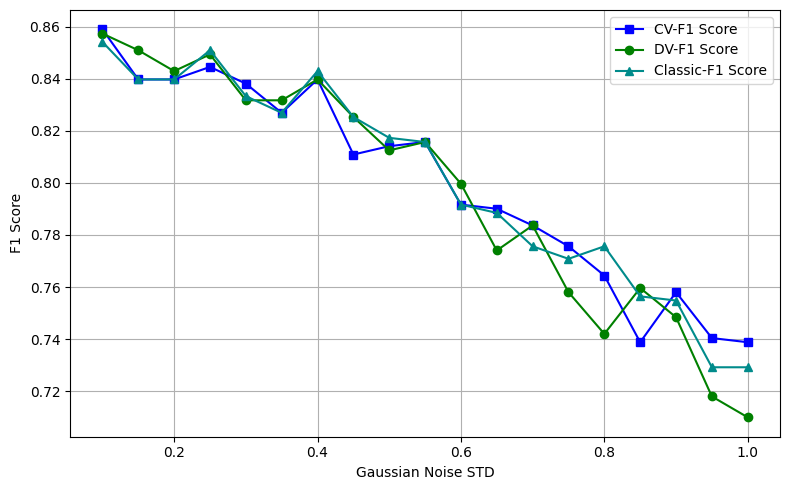

In [301]:
plt.figure(figsize=(8,5))
# plt.plot(noise_std, accuracies, marker="o", label="Accuracy", color="blue")
plt.plot(noise_std, cv_f1_scores, marker="s", label="CV-F1 Score", color="blue")
plt.plot(noise_std, dv_f1_scores, marker="o", label="DV-F1 Score", color="green")
plt.plot(noise_std, classic_f1_scores, marker="^", label="Classic-F1 Score", color="darkcyan")
plt.xlabel("Gaussian Noise STD")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/noise_performance_curve", dpi=300)
plt.show()